# Event-Related VASO

This is the analysis code for the event-ralted VASO project. It should cover all the steps from the DCM to BIDS conversion until the final plots.

The steps involve:
1. conversion from DCM tpo bids with heudiconv
1.1. If EPI anatomy [Chai et al.](https://www.sciencedirect.com/science/article/pii/S1053811921007291?via%3Dihub) was acquired, process anatomical data.
2. make event files
3. making two derivatives branches (one for V1 and one for S1)
4. Do the motion correction for each of them separately (with motion masks centered on the regions of interest)
5. truncate the data to get rid of the upper and lower half for the V1 and S1 data, respectivelty
6. extract event related averages 
6.1. for blocks
6.2. for events
6.3. for layers

## 1. BIDS conversion

I did the BIDS conversion for sub-05 06 and 07 already. Therefore, I will show it here for sub-08. Unfortunately, the code here cannot be run from within the notebook but has to be copied to the terminal.

In [ ]:
%%bash

docker run --rm -it -v /media/sebastian/Data/EVENTRELATED_PILOT/rawData:/base nipy/heudiconv:latest -d /base/DICOM/sub-{subject}/ses-{session}/*.IMA -o /base/Nifti/ -f convertall -s 08 -ss 001 -c none --overwrite
cp /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/.heudiconv/08/info/dicominfo_ses-001.tsv /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/code/sub-08_dicominfo_ses-001.tsv
docker run --rm -it -v /media/sebastian/Data/EVENTRELATED_PILOT/rawData:/base nipy/heudiconv:latest -d /base/DICOM/sub-{subject}/ses-{session}/*.IMA -o /base/Nifti/ -f /base/Nifti/code/heudiconv_heuristic_sub-08.py -s 08 -ss 001 -c dcm2niix -b --overwrite

In [ ]:
root = '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti'
os.system(f'mkdir -p {root}/derivatives/sub-08/ses-001/v1Focus')
os.system(f'mkdir -p {root}/derivatives/sub-08/ses-001/s1Focus')

## 2. Make event Files

In [ ]:
import numpy as np
import pandas as pd
import re
import nipype.interfaces.fsl as fsl


In [ ]:
subs = ['05', '06', '07', '08']
dataDir = '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/'

for sub in subs:

    # check number of blockStim runs
    nrBlockStim = len(glob.glob(dataDir + f'sub-{sub}/ses-001/func/sub-{sub}_ses-001_task-blockStim_run-00*_cbv.nii.gz'))

    for n in range(1,nrBlockStim+1):

        logFile = pd.read_csv(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-{sub}/ses-001/events/sub{sub}_sess001_30sOnOff_run%s.log'%(n), usecols=[0])

        for index, row in logFile.iterrows():
            if re.search('Keypress: 5', str(row)):
                firstVolRow = index
                break


        ColNames = ['startTime', 'type', 'event']

        logFile = pd.read_csv(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-{sub}/ses-001/events/sub{sub}_sess001_30sOnOff_run%s.log'%(n), sep = '\t',skiprows=firstVolRow, names = ColNames)



        stimStart = []
        stimStop = []

        for index, row in logFile.iterrows():
            if re.search('stimulation started', logFile['event'][index]):
                stimStart.append(logFile['startTime'][index])
            if re.search('stimulation stopped', logFile['event'][index]):
                stimStop.append(logFile['startTime'][index])


        durs = np.asarray(stimStop) - np.asarray(stimStart)


        design = pd.DataFrame({'startTime': stimStart, 'duration': durs, 'mod' : np.ones(len(durs))})
        np.savetxt(r'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-%s/ses-001/events/sub-%s_ses-001_task-blockStim_run-00%s.txt'%(sub, sub, n), design.values, fmt='%1.2f')

    # check number of eventStim runs
    nrEventStim = len(glob.glob(dataDir + f'sub-{sub}/ses-001/func/sub-{sub}_ses-001_task-eventStim_run-00*_cbv.nii.gz'))


    for n in range(1,nrEventStim+1):

        logFile = pd.read_csv(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-{sub}/ses-001/events/sub{sub}_sess001_EventRelated5Fingers_run%s.log'%(n), usecols=[0])

        for index, row in logFile.iterrows():
            if re.search('Keypress: 5', str(row)):
                firstVolRow = index
                break


        ColNames = ['startTime', 'type', 'event']

        logFile = pd.read_csv(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-{sub}/ses-001/events/sub{sub}_sess001_EventRelated5Fingers_run{n}.log',sep = '\t',skiprows=firstVolRow, names = ColNames)



        stimStart = []
        stimStop = []

        for index, row in logFile.iterrows():
            if re.search('visual stimulation started', logFile['event'][index]):
                stimStart.append(logFile['startTime'][index])
            if re.search('visual stimulation stopped', logFile['event'][index]):
                stimStop.append(logFile['startTime'][index])


        durs = np.asarray(stimStop) - np.asarray(stimStart)


        design = pd.DataFrame({'startTime': stimStart, 'duration': durs, 'mod' : np.ones(len(durs))})
        np.savetxt(r'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-%s/ses-001/events/sub-%s_ses-001_task-eventStim_run-00%s.txt'%(sub, sub, n), design.values, fmt='%1.2f')




    # cp -r /media/sebastian/Data/s1anfunco_backup/s1_anfunco_analysis_04-05-2021/sub16/func/vaso/stimulation/run1/VASO.feat/reg .
    # cp mean_func.nii.gz reg/standard.nii.gz


## 3. Make two branches

In the derivatives folde, make a branch for V1 and S1 separately.

In [ ]:
%%bash


# for sub in 08
for sub in 05 06 07
do
for focus in s1
do
cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/'$focus'Focus/'
cp mocoToEachRun/*moco*.nii .

done
done

In [ ]:
%%bash


# for sub in 08
for sub in 05 06 07
do

cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/v1Focus/'
cp oldAnalysis/*reference.nii .
cp oldAnalysis/*confounds.nii .
cp -r oldAnalysis/motionParameters .

cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/s1Focus/'
cp mocoToEachRun/*reference.nii .
cp mocoToEachRun/*confounds.nii .
cp -r mocoToEachRun/motionParameters .


done

## 4. Preprocess data in the two branches


### 4.1 Do motion correction separately

In [ ]:
%%bash


# for sub in 08
for sub in 05 06 07
do
for focus in v1 s1

do
echo ""
echo ""
echo ""
echo ""
echo 'processing sub-'$sub''

mkdir '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/'$focus'Focus/'
cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/'$focus'Focus/'

declare -a runs=('/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-'$sub'/ses-001/func/*.nii.gz')
echo $runs

echo 'Found '${#runs[@]}' run(s) for sub-'$sub''

for run in $runs
do
echo 'processing run '$run''

# define basename for output files
base=`basename $run _cbv.nii.gz`

###########################################
###### parameters that are not used  ######
###########################################

ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS=8
export ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS
tr=1
basevol=1000 # ANTs indexing

mkdir -p motionParameters/nn_motion/${base}
mkdir -p motionParameters/n_motion/${base}


###########################################
####### preparig odd and even images ######
###########################################

#for classical Magentom VASO sequences
3dcalc -a $run'[0..$(2)]' -expr 'a' -prefix ${base}_notnulled.nii -overwrite
3dcalc -a $run'[1..$(2)]' -expr 'a' -prefix ${base}_nulled.nii -overwrite

# for Terra 7T VASO sequence
#3dcopy $1'[0..$(2)]' nulled.nii
#3dcopy $1'[1..$(2)]' notnulled.nii


# 3dAutomask -prefix moma.nii -peels 3 -dilate 2  notnulled.nii

###########################################
####### Do MOCO on notnulled  #############
###########################################

n_vols=`PrintHeader ${base}_notnulled.nii | grep Dimens | cut -d ',' -f 4 | cut -d ']' -f 1`

echo "seperating $n_vols time steps to save RAM"
ImageMath 4 vol_.nii TimeSeriesDisassemble ${base}_notnulled.nii # vol_1000.nii, vol_1001.nii ...
cp vol_1003.nii vol_1000.nii # removing steady state effects
cp vol_1004.nii vol_1001.nii
cp vol_1005.nii vol_1002.nii
3dMean -prefix ${base}_nn_reference.nii vol_1004.nii vol_1005.nii # there is no overwrite here, in case of multiple series
nthvol=$(($basevol + $n_vols - 1)) # Zero indexing
echo "doing the alignemt"
for i in $(eval echo "{$basevol..$nthvol}");
do
antsRegistration \
--dimensionality 3 \
--float 1 \
--collapse-output-transforms 1 \
--output [ vol_${i}_,vol_${i}_Warped.nii.gz,vol_${i}_InverseWarped.nii.gz ] \
--interpolation BSpline[2] \
--use-histogram-matching 1 \
--winsorize-image-intensities [ 0.005,0.995 ] \
-x '$focus'Moma.nii \
--initial-moving-transform [ ${base}_nn_reference.nii,vol_${i}.nii,1 ] \
--transform Rigid[ 0.1 ] \
--metric MI[ ${base}_nn_reference.nii,vol_${i}.nii,1,32,Regular,0.25 ] \
--convergence [ 250x100,1e-6,10 ] \
--shrink-factors 2x1 \
--smoothing-sigmas 1x0vox
#--transform SyN[ 0.1,3,0 ] \
#--metric CC[ nn_reference.nii,vol_${i}.nii,1,4 ] \
#--convergence [ 50x0,1e-6,10 ] \
#--shrink-factors 2x1 \
#--smoothing-sigmas 1x0vox
done

echo "reassembling the time points"
ImageMath 4 ${base}_moco_notnulled.nii TimeSeriesAssemble $tr 0 vol_*_Warped.nii.gz
mv vol_*.nii motionParameters/nn_motion/${base}
mv vol_*_0GenericAffine.mat motionParameters/nn_motion/${base}
mv vol_*_1Warp.nii.gz motionParameters/nn_motion/${base}
mv vol_*_1InverseWarp.nii.gz motionParameters/nn_motion/${base}
mv vol_*_InverseWarped.nii.gz motionParameters/nn_motion/${base}
mv vol_*_Warped.nii.gz motionParameters/nn_motion/${base}


###########################################
####### Do MOCO on nulled  ################
###########################################

n_vols=`PrintHeader ${base}_nulled.nii | grep Dimens | cut -d ',' -f 4 | cut -d ']' -f 1`

echo "seperating $n_vols time steps to save RAM"
ImageMath 4 vol_.nii TimeSeriesDisassemble ${base}_nulled.nii # vol_1000.nii, vol_1001.nii ...
cp vol_1003.nii vol_1000.nii # removing steady state effects
cp vol_1004.nii vol_1001.nii
cp vol_1005.nii vol_1002.nii
3dMean -prefix ${base}_n_reference.nii vol_1004.nii vol_1005.nii # there is no overwrite here, in case of multiple series
nthvol=$(($basevol + $n_vols - 1)) # Zero indexing
echo "doing the alignemt"
for i in $(eval echo "{$basevol..$nthvol}");
do
antsRegistration \
--dimensionality 3 \
--float 1 \
--collapse-output-transforms 1 \
--output [ vol_${i}_,vol_${i}_Warped.nii.gz,vol_${i}_InverseWarped.nii.gz ] \
--interpolation BSpline[2] \
--use-histogram-matching 1 \
--winsorize-image-intensities [ 0.005,0.995 ] \
-x '$focus'Moma.nii \
--initial-moving-transform [ ${base}_n_reference.nii,vol_${i}.nii,1 ] \
--transform Rigid[ 0.1 ] \
--metric MI[ ${base}_n_reference.nii,vol_${i}.nii,1,32,Regular,0.25 ] \
--convergence [ 250x100,1e-6,10 ] \
--shrink-factors 2x1 \
--smoothing-sigmas 1x0vox
#--transform SyN[ 0.1,3,0 ] \
#--metric CC[ n_reference.nii,vol_${i}.nii,1,4 ] \
#--convergence [ 50x0,1e-6,10 ] \
#--shrink-factors 2x1 \
#--smoothing-sigmas 1x0voxdone
done
echo "reassembling the time points"
ImageMath 4 ${base}_moco_nulled.nii TimeSeriesAssemble $tr 0 vol_*_Warped.nii.gz
mv vol_*.nii motionParameters/n_motion/${base}
mv vol_*_0GenericAffine.mat motionParameters/n_motion/${base}
mv vol_*_1Warp.nii.gz motionParameters/n_motion/${base}
mv vol_*_1InverseWarp.nii.gz motionParameters/n_motion/${base}
mv vol_*_InverseWarped.nii.gz motionParameters/n_motion/${base}
mv vol_*_Warped.nii.gz motionParameters/n_motion/${base}


##############################
#### fsl_motion_outliers  ####
##############################

fsl_motion_outliers -i ${base}_nulled.nii -o ${base}_nulled_confounds.txt
fsl_motion_outliers -i ${base}_notnulled.nii -o ${base}_notnulled_confounds.txt

done
done
done

In [ ]:
%%bash

imageTypes=("n" "nn")

# for sub in 05
for sub in 05 06 07 08

do

for focus in s1
# for focus in v1 s1

do
echo ""
echo ""
echo ""
echo ""
echo 'processing sub-'$sub''

declare -a runs=('/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-'$sub'/ses-001/func/*.nii.gz')
echo $runs

echo 'Found '${#runs[@]}' run(s) for sub-'$sub''

for run in $runs
do
echo 'processing run '$run''

# define basename for output files
base=`basename $run _cbv.nii.gz`



cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/'$focus'Focus/'

n_vols=`PrintHeader ${base}_moco_notnulled.nii | grep Dimens | cut -d ',' -f 4 | cut -d ']' -f 1`
num=$((n_vols + 1000))

echo $num

for imageType in "${imageTypes[@]}"
do

cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/'$focus'Focus/motionParameters/'$imageType'_motion/'${base}''

for (( k=1000; k<$num; k++ ))
do
ConvertTransformFile \
3 \
'vol_'$k'_0GenericAffine.mat' \
'vol_'$k'_0GenericAffine_af.mat' \
--convertToAffineType


c3d_affine_tool \
-ref '../../../'${base}'_'$imageType'_reference.nii' \
-src 'vol_'$k'.nii' \
-itk 'vol_'$k'_0GenericAffine_af.mat' -ras2fsl \
-o 'vol_'$k'_0GenericAffine_FSL.mat' \
-info-full
done

done

done

done

done

In [ ]:
subs[1:]

In [ ]:
import itertools

modalities = ["n", 'nn']
modalitiesDict = {'n': 'VASO', 'nn': 'BOLD'}

for sub in subs[1:]:
    runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-*Stim_run-00*_cbv.nii.gz'))
    
    lstsubMot  = []
    lstsubMot_Nme  = []
    lstTR_sub = []
    sub_list =[]
    modalityList = []
    runsList = []
    
    for run in runs:
            
        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        print(base)


        for k in range(1,len(runs)+1):

            for modality in modalities:

                affinemats = sorted(glob.glob(f'{root}/{sub}/ses-001/s1Focus/motionParameters/{modality}_motion/{base}/vol_*_0GenericAffine_FSL.mat'))
                print(len(affinemats))

                volids=[]
                for n in range(len(affinemats)):
                    volids.append(n+1000)

                for volid in volids:

                    # Current mats
                    currMats = f'{root}/{sub}/ses-001/s1Focus/motionParameters/{modality}_motion/{base}/vol_{volid}_0GenericAffine_FSL.mat'

                    tmp = fsl.AvScale(all_param=True,mat_file=currMats);

                    tmpReadout = tmp.run();

                    # Get the rotations (in rads) and translations (in mm) per volume

                    aryTmpMot = list(itertools.chain.from_iterable([tmpReadout.outputs.translations,tmpReadout.outputs.rot_angles]));




                    # Save the roation and translations
                    lstsubMot.append(aryTmpMot)
                    lstTR_sub.append([int(volid)+1-1000 for i in range(6)])
                    lstsubMot_Nme.append([f'TX {modalitiesDict[modality]}',f'TY {modalitiesDict[modality]}',f'TZ {modalitiesDict[modality]}',f'RX {modalitiesDict[modality]}',f'RY {modalitiesDict[modality]}',f'RZ {modalitiesDict[modality]}'])
                    sub_list.append([str(sub) for i in range(6)])
                    modalityList.append([str(modalitiesDict[modality]) for i in range(6)])
                    runsList.append([str(f'{base}') for i in range(6)])




        aryCurr = np.array(lstsubMot)
        aryCurr_Ses =  aryCurr.reshape((aryCurr.size,-1))
        aryCurr_TR = np.array(lstTR_sub)
        aryCurr_TR_Ses = aryCurr_TR.reshape((aryCurr_TR.size,-1))
        aryCurr_Nme = np.array(lstsubMot_Nme)
        aryCurr_Nme_Ses = aryCurr_Nme.reshape((aryCurr_Nme.size,-1))
        aryIdx = np.arange(1,len(aryCurr_Nme_Ses)+1)

        aryCurr_mod = np.array(modalityList)
        aryCurr_mod = aryCurr_mod.reshape((aryCurr_mod.size,-1))

        aryCurr_subname = np.array(sub_list)
        aryCurr_subs =  aryCurr_subname.reshape((aryCurr_subname.size,-1))

        aryCurr_runsList = np.array(runsList)
        aryCurr_runs =  aryCurr_runsList.reshape((aryCurr_runsList.size,-1))



        data_dict = {
            'subject': aryCurr_subs[:,0],
            'Time/TR': aryCurr_TR_Ses[:,0],
            'Motion_Name': aryCurr_Nme_Ses[:,0],
            'Motion': aryCurr_Ses[:,0],
            'idx':aryIdx,
            'modality': aryCurr_mod[:,0],
            'run': aryCurr_runs[:,0]}

        pd_ses = pd.DataFrame(data=data_dict)
        pd_ses.to_csv(f'{root}/{sub}/ses-001/s1Focus/motionParameters/{sub}motionParameters.csv', index=False)

In [ ]:
sub_FD = []
timepoints = []
subjects=[]
mods = []
runList = []

for sub in subs[1:]:
    runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-eventStim_run-00*_cbv.nii.gz'))
    
    for run in runs:
            
        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        print(base)
    
        for modality in modalities:

            TX = pd_ses['Motion'].loc[(pd_ses['run'].str.contains(base) == 1)&(pd_ses['Motion_Name'].str.contains("TX") == 1)&(pd_ses['subject']==sub)&(pd_ses['modality']==modalitiesDict[modality])].tolist()
            TY = pd_ses['Motion'].loc[(pd_ses['run'].str.contains(base) == 1)&(pd_ses['Motion_Name'].str.contains("TY") == 1)&(pd_ses['subject']==sub)&(pd_ses['modality']==modalitiesDict[modality])].tolist()
            TZ = pd_ses['Motion'].loc[(pd_ses['run'].str.contains(base) == 1)&(pd_ses['Motion_Name'].str.contains("TZ") == 1)&(pd_ses['subject']==sub)&(pd_ses['modality']==modalitiesDict[modality])].tolist()

            RX = pd_ses['Motion'].loc[(pd_ses['run'].str.contains(base) == 1)&(pd_ses['Motion_Name'].str.contains("RX") == 1)&(pd_ses['subject']==sub)&(pd_ses['modality']==modalitiesDict[modality])].tolist()
            RY = pd_ses['Motion'].loc[(pd_ses['run'].str.contains(base) == 1)&(pd_ses['Motion_Name'].str.contains("RY") == 1)&(pd_ses['subject']==sub)&(pd_ses['modality']==modalitiesDict[modality])].tolist()
            RZ = pd_ses['Motion'].loc[(pd_ses['run'].str.contains(base) == 1)&(pd_ses['Motion_Name'].str.contains("RZ") == 1)&(pd_ses['subject']==sub)&(pd_ses['modality']==modalitiesDict[modality])].tolist()

            for n in range(len(TX)-1):
                FD_trial = abs(TX[n]-TX[n+1])+abs(TY[n]-TY[n+1])+abs(TZ[n]-TZ[n+1])+abs((50*RX[n])-(50*RX[n+1]))+abs((50*RY[n])-(50*RY[n+1]))+abs((50*RZ[n])-(50*RZ[n+1]))
                sub_FD.append(FD_trial)
                timepoints.append(n)
                subjects.append(sub)
                mods.append(modalitiesDict[modality])
                runList.append(base)


    FDs = pd.DataFrame({'subject':subjects, 'volume':timepoints, 'FD':sub_FD, 'modality': mods, 'run': runList})
    FDs.to_csv(f'{root}/{sub}/ses-001/s1Focus/motionParameters/{sub}_FDs.csv', index=False)

### 4.2 Truncate data to upper and lower parts

In [ ]:
%%bash

# for sub in 05 06 07 08

# for sub in 05 06 07
# do
# echo ""
# echo ""
# echo ""
# echo ""
# echo 'processing sub-'$sub''

# cd /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-$sub/ses-001/v1Focus/



# declare -a runs=('/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-'$sub'/ses-001/func/*.nii.gz')
# echo $runs

# echo 'Found '${#runs[@]}' run(s) for sub-'$sub''

# for run in $runs
# do
# echo 'processing run '$run''

# # define basename for output files
# base=`basename $run _cbv.nii.gz`

# fslroi ${base}_moco_nulled.nii ${base}_moco_nulled_trunc.nii.gz 0 150 0 50 0 16
# fslroi ${base}_moco_notnulled.nii ${base}_moco_notnulled_trunc.nii.gz 0 150 0 50 0 16

# done
# done

# for sub in 05 06 07 08
# for sub in 05 06 07
for sub in 08
do
echo ""
echo ""
echo ""
echo ""
echo 'processing sub-'$sub''

cd /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-$sub/ses-001/s1Focus/


declare -a runs=('/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-'$sub'/ses-001/func/*.nii.gz')
echo $runs

echo 'Found '${#runs[@]}' run(s) for sub-'$sub''

for run in $runs
do
echo 'processing run '$run''

# define basename for output files
base=`basename $run _cbv.nii.gz`

fslroi ${base}_moco_nulled.nii ${base}_moco_nulled_trunc.nii.gz 0 150 80 70 0 16
fslroi ${base}_moco_notnulled.nii ${base}_moco_notnulled_trunc.nii.gz 0 150 80 70 0 16

done
done


### 4.3 Do BOCO on both parts

In [ ]:
%%bash


# for sub in 05 06 07
for sub in 08
do
# for focus in v1 s1
for focus in s1
do

echo ""
echo ""
echo ""
echo ""
echo 'processing sub-'$sub''

cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/'$focus'Focus/'

declare -a runs=('/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-'$sub'/ses-001/func/*.nii.gz')
echo $runs

echo 'Found '${#runs[@]}' run(s) for sub-'$sub''

for run in $runs
do
echo 'processing run '$run''

# define basename for output files
base=`basename $run _cbv.nii.gz`


##################################################
#### Temporal upsampling so VASO matches BOLD ####
##################################################

echo "temporal upsampling and shifting happens now"
3dUpsample -overwrite  -datum short -prefix ${base}_Nulled_intemp.nii -n 2 -input ${base}_moco_nulled_trunc.nii.gz
3dUpsample -overwrite  -datum short -prefix ${base}_BOLD_intemp.nii   -n 2 -input ${base}_moco_notnulled_trunc.nii.gz

##for Magentom clasical VASO sequence
NumVol=`3dinfo -nv ${base}_Nulled_intemp.nii`
3dTcat -overwrite -prefix ${base}_Nulled_intemp.nii ${base}_Nulled_intemp.nii'[0]' ${base}_Nulled_intemp.nii'[0..'`expr $NumVol - 2`']'

echo "I am correcting for the proper TR in the header"
3drefit -TR 1.3088939024390243 ${base}_BOLD_intemp.nii
3drefit -TR 1.3088939024390243 ${base}_Nulled_intemp.nii

echo "BOLD correction happens now"
LN_BOCO -Nulled ${base}_Nulled_intemp.nii -BOLD ${base}_BOLD_intemp.nii -output ${base}

"calculating Mean and tSNR maps"
3dTstat -mean -prefix ${base}_mean_nulled.nii ${base}_moco_nulled_trunc.nii.gz -overwrite
3dTstat -mean -prefix ${base}_mean_notnulled.nii ${base}_moco_notnulled_trunc.nii.gz -overwrite


echo "calculating T1 in EPI space"
3dTcat -prefix combined.nii  ${base}_moco_nulled_trunc.nii.gz ${base}_moco_notnulled_trunc.nii.gz -overwrite
3dTstat -cvarinv -overwrite  -prefix ${base}_T1w.nii combined.nii
rm combined.nii

echo "curtosis and skew"
LN_SKEW -input ${base}_BOLD_intemp.nii
LN_SKEW -input ${base}_VASO_LN.nii


fslmaths ${base}_VASO_LN.nii -mul 100 ${base}_VASO.nii.gz -odt short


done
done
done


### 4.4 Average eventStim runs

For the subjects for which we acquired 4 eventStim runs, we can average the A and B runs respectively. For this, we need to make the number of volumes equal.

In [ ]:
for sub in subs[-1:]:
    print(sub)
    runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-event*_run-00*_cbv.nii.gz'))
    if len(runs) < 3:
        continue
    for focus in ['v1', 's1']:
        for combination in ['13', '24']:
            os.system(f'mkdir -p {root}/{sub}/ses-001/{focus}Focus/avg{combination}')

            for imageType in ['nulled', 'notnulled']:
                data1 = nb.load(f'{root}/{sub}/ses-001/{focus}Focus/{sub}_ses-001_task-eventStim_run-00{combination[0]}_moco_{imageType}_trunc.nii.gz').get_fdata()
                data2 = nb.load(f'{root}/{sub}/ses-001/{focus}Focus/{sub}_ses-001_task-eventStim_run-00{combination[1]}_moco_{imageType}_trunc.nii.gz').get_fdata()
                header = nb.load(f'{root}/{sub}/ses-001/{focus}Focus/{sub}_ses-001_task-eventStim_run-00{combination[0]}_moco_{imageType}_trunc.nii.gz')
                if data1.shape[-1] < data2.shape[-1]:
                    minTimePoints = data1.shape[-1]
                else:
                    minTimePoints = data2.shape[-1]


                data1time = data1[:,:,:,:minTimePoints]
                data2time = data2[:,:,:,:minTimePoints]
                avg = ((data2time+data1time)/2)

                new_img = nb.Nifti1Image(avg, header.affine, header.header)
                new_img.to_filename(f'{root}/{sub}/ses-001/{focus}Focus/avg{combination}/moco_{imageType}_trunc.nii.gz')

### 4.5 Run BOCO on averaged eventStim runs

In [ ]:
%%bash


# for sub in 06 07
for sub in 08
do
for focus in v1 s1
do

echo ""
echo ""
echo ""
echo ""
echo 'processing sub-'$sub''

for combination in 13 24
do

cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/'$focus'Focus/avg'$combination''

##################################################
#### Temporal upsampling so VASO matches BOLD ####
##################################################

echo "temporal upsampling and shifting happens now"
3dUpsample -overwrite  -datum short -prefix Nulled_intemp.nii.gz -n 2 -input moco_nulled_trunc.nii.gz
3dUpsample -overwrite  -datum short -prefix BOLD_intemp.nii.gz   -n 2 -input moco_notnulled_trunc.nii.gz

##for Magentom clasical VASO sequence
NumVol=`3dinfo -nv Nulled_intemp.nii.gz`
3dTcat -overwrite -prefix Nulled_intemp.nii.gz Nulled_intemp.nii.gz'[0]' Nulled_intemp.nii.gz'[0..'`expr $NumVol - 2`']'

echo "I am correcting for the proper TR in the header"
3drefit -TR 1.3088939024390243 BOLD_intemp.nii.gz
3drefit -TR 1.3088939024390243 Nulled_intemp.nii.gz

echo "BOLD correction happens now"
LN_BOCO -Nulled Nulled_intemp.nii.gz -BOLD BOLD_intemp.nii.gz

nii "calculating Mean and tSNR maps"
3dTstat -mean -prefix mean_nulled.nii.gz moco_nulled.nii.gz -overwrite
3dTstat -mean -prefix mean_notnulled.nii.gz moco_notnulled.nii.gz -overwrite
# 3dTstat  -overwrite -mean  -prefix BOLD.Mean.nii.gz BOLD_intemp.nii.gz'[1..$]'
# 3dTstat  -overwrite -cvarinv  -prefix BOLD.tSNR.nii.gz BOLD_intemp.nii.gz'[1..$]'
# 3dTstat  -overwrite -mean  -prefix VASO.Mean.nii.gz VASO_LN.nii.gz'[1..$]'
# 3dTstat  -overwrite -cvarinv -prefix VASO.tSNR.nii.gz VASO_LN.nii.gz'[1..$]'

echo "calculating T1 in EPI space"
3dTcat -prefix combined.nii.gz  moco_nulled_trunc.nii.gz moco_notnulled_trunc.nii.gz -overwrite
3dTstat -cvarinv -overwrite  -prefix T1w.nii.gz combined.nii.gz
rm combined.nii.gz
#3dcalc -a mean_nulled.nii.gz -b mean_notnulled.nii.gz -expr 'abs(b-a)/(a+b)' -prefix T1w.nii.gz -overwrite

echo "curtosis and skew"
#LN_SKEW -timeseries BOLD.nii.gz
#LN_SKEW -timeseries VASO_LN.nii.gz


fslmaths VASO_LN.nii -mul 100 VASO.nii.gz -odt short

done
done
done


## 5 Analysis

### 5.1 Prepare GLM

In [ ]:
# Set this to the directory all of the sub### directories live in
root = '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives'
subs = ['sub-05', 'sub-06', 'sub-07', 'sub-08']
# subs = ['sub-05']

# Set this to the directory where you'll dump all the fsf files
# May want to make it a separate directory, because you can delete them all o
#   once Feat runs
fsfDir = f"{root}/designFiles"

modalities = {'BOLD_intemp':'1', 'VASO':'-1'}

for sub in subs:
    for modality in modalities:
        print(modality)
        print(modalities[modality])
        runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-*_run-00*_cbv.nii.gz'))

        for run in runs:
            
            base = os.path.basename(run).rsplit('.', 2)[0][:-4]
            print(base)
            eventFile = f'{root}/{sub}/ses-001/events/{base}.txt'
            
            
            if modality=='BOLD_intemp':
                actualData = f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/{sub}/ses-001/v1Focus/{base}_{modality}.nii'
            if modality=='VASO':
                actualData = f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/{sub}/ses-001/v1Focus/{base}_{modality}.nii.gz'
            
            
            runData = nb.load(actualData).get_fdata()
            nrVolumes = str(runData.shape[-1])
            print(nrVolumes)
            
            
            for focus in ['v1', 's1']:
                subFolder = f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/{sub}/ses-001/{focus}Focus'

                replacements = {'INFILE':f'{subFolder}/{base}_{modality}', 'OUTFOLDER': f'{subFolder}/{base}_{modality}', 'EVENTFILE': eventFile, 'CONTRASTVALUE': modalities[modality], 'NRVOLUMES': nrVolumes}



                with open(f"{fsfDir}/designTemplate.fsf") as infile:
                    with open(f"{fsfDir}/{base}_{modality}_{focus}Focus.fsf", 'w') as outfile:
                        for line in infile:
                            for src, target in replacements.items():
                                line = line.replace(src, target)
                            outfile.write(line)
  
  

### 5.2 Run first level GLMs

In [ ]:
import glob
import os

subs = ['sub-08']

root = '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives'
fsfDir = f"{root}/designFiles"

for sub in subs:
    feats = sorted(glob.glob(f'{fsfDir}/{sub}_*s1Focus.fsf'))
    for feat in feats:
        print(feat)
        os.system(f'feat {feat}')

In [ ]:
import glob
import os

# subs = ['sub-05', 'sub-08']

root = '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives'
fsfDir = f"{root}/designFiles"

for sub in subs:
    feats = sorted(glob.glob(f'{fsfDir}/{sub}_*event*.fsf'))
    for feat in feats:
        print(feat)
        os.system(f'feat {feat}')

### 5.4 Prepare second level GLMs

In [ ]:
featFolders = sorted(glob.glob(f'{root}/*/ses-001/*Focus/*.feat'))
include = []

for folder in featFolders:
    if not os.path.exists(f'{folder}/reg/standard.nii.gz'):
        include.append(folder)

In [ ]:
include = []

for folder in featFolders:
    if not os.path.exists(f'{folder}/reg/standard.nii.gz'):
        include.append(folder)

In [ ]:
%%bash -s "{" ".join(include)}" 

for folder in $1
do
cd $folder
mkdir reg
cp $FSLDIR/etc/flirtsch/ident.mat reg/example_func2standard.mat
cp mean_func.nii.gz reg/standard.nii.gz

done

### 5.4 Run second level GLMs

### 5.3 Draw masks

Based on the GLM results of the blockStim, we can now draw masks. 

## 6. Extract Event-Related Averages

From the masks we just created, we can now extract event-related averages for the block- and event-wise stimulation. This will help us to characterize the response.

### 6.1 For Blocks

In [ ]:
import numpy as np
import glob
import nibabel as nb
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import plotting
import seaborn as sns
from scipy.interpolate import interp1d
import os
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [362]:
subs = ['sub-05', 'sub-06','sub-07', 'sub-08']
root = '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives'

numberOfRuns = 2
modalities = ['BOLD', 'VASO']

blockResults = {}
for focus in ['s1Focus', 'v1Focus']:
    blockResults[focus] = {}
    for sub in subs:
        print(sub)
        blockResults[focus][sub] = {}

        runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-bloc*_run-00*_cbv.nii.gz'))

        for run in runs:

            base = os.path.basename(run).rsplit('.', 2)[0][:-4]
            blockResults[focus][sub][base] = {}


            for modality in modalities:
                blockResults[focus][sub][base][modality] = {}

                print(f'processing {base}')

                run = f'{root}/{sub}/ses-001/{focus}/{base}_{modality}_scaled_slice.nii.gz'
                mask = nb.load(f'{root}/{sub}/ses-001/{focus}/{sub}_masks/{base}_3layers_layers_equidist_slice.nii.gz').get_fdata()

                Nii = nb.load(run)
                # As before, get the data as an array.
                data = Nii.get_fdata()[:,:,:,:-2]
                # load the nifty-header to get some meta-data.
                header = Nii.header

                # As the number of volumes which is the 4th position of
                # get_shape. This seems to be unused so I will comment it out to check.
                # nr_volumes = int(header.get_data_shape()[3])

                # Or the TR, which is the 4th position of get_zooms().
                tr = header.get_zooms()[3]

                 # Get scan duration in s
                runTime = data.shape[-1]*tr

                events = pd.read_csv(f'{root}/{sub}/ses-001/events/{base}.txt', sep = ' ', names = ['start','duration','trialType'])

                # Load information on run-wise motion
                FDs = pd.read_csv(f'{root}/{sub}/ses-001/{focus}/motionParameters/{sub}_FDs.csv')



                for i, row in events.iterrows():

                    onset = round(row['start']/tr)
                    # Do the same for the offset
                    offset = round(onset + row['duration']/tr)

                    # check whether trial is fully there
                    if offset > data.shape[3]:
                        break

                    # Because we want the % signal-change, we need the mean
                    # of the voxel we are looking at. This is done with
                    # some fancy matrix operations.
                    mask_mean = np.mean(data[:, :, :]
                                        [mask.astype(bool)])

                    # truncate motion data to event
                    tmp = FDs.loc[(FDs['volume']>=(onset-2)/2)&(FDs['volume']<=(offset+2)/2)&(FDs['run'].str.contains(f'{base}'))]

                    if not (tmp['FD']>=2).any():
                        blockResults[focus][sub][base][modality][f'trial {i}'] = np.mean((((data[:, :, :, int(onset-4):int(offset+ 8)][mask.astype(bool)]) / mask_mean)- 1) * 100,axis=0)

            

sub-05
processing sub-05_ses-001_task-blockStim_run-001
processing sub-05_ses-001_task-blockStim_run-001
processing sub-05_ses-001_task-blockStim_run-002
processing sub-05_ses-001_task-blockStim_run-002
sub-06
processing sub-06_ses-001_task-blockStim_run-001
processing sub-06_ses-001_task-blockStim_run-001
processing sub-06_ses-001_task-blockStim_run-002
processing sub-06_ses-001_task-blockStim_run-002
sub-07
processing sub-07_ses-001_task-blockStim_run-001
processing sub-07_ses-001_task-blockStim_run-001
processing sub-07_ses-001_task-blockStim_run-002
processing sub-07_ses-001_task-blockStim_run-002
sub-08
processing sub-08_ses-001_task-blockStim_run-001
processing sub-08_ses-001_task-blockStim_run-001
processing sub-08_ses-001_task-blockStim_run-002
processing sub-08_ses-001_task-blockStim_run-002
sub-05
processing sub-05_ses-001_task-blockStim_run-001
processing sub-05_ses-001_task-blockStim_run-001
processing sub-05_ses-001_task-blockStim_run-002
processing sub-05_ses-001_task-blo

In [363]:
import json

jsonObject = json.dumps(blockResults)

with open(f'{root}/blockResults.json', w) as outFile:
    outFile.write(jsonObject)

TypeError: Object of type ndarray is not JSON serializable

In [365]:
%%bash

pip install deepdish

In [366]:
import deepdish as dd

dd.io.save(f'{root}/blockResults.h5', blockResults)

/home/sebastian/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: 'sub-05'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/sebastian/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: 'sub-05_ses-001_task-blockStim_run-001'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/sebastian/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: 'trial 0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this ob

In [367]:
d = dd.io.load(f'{root}/blockResults.h5')

In [371]:
d == blockResults

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [340]:
subs = ['sub-05', 'sub-06','sub-07', 'sub-08']
root = '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives'

numberOfRuns = 2
modalities = ['BOLD', 'VASO']

blockResults = {}

for sub in subs:
    print(sub)
    blockResults[sub] = {}

    runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-bloc*_run-00*_cbv.nii.gz'))

    for run in runs:
            
        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        blockResults[sub][base] = {}
        
        
        for modality in modalities:
            blockResults[sub][base][modality] = {}
            
            print(f'processing {base}')

            run = f'{root}/{sub}/ses-001/v1Focus/{base}_{modality}_scaled_slice.nii.gz'
            mask = nb.load(f'{root}/{sub}/ses-001/v1Focus/{sub}_masks/{base}_3layers_layers_equidist_slice.nii.gz').get_fdata()

            Nii = nb.load(run)
            # As before, get the data as an array.
            data = Nii.get_fdata()[:,:,:,:-2]
            # load the nifty-header to get some meta-data.
            header = Nii.header

            # As the number of volumes which is the 4th position of
            # get_shape. This seems to be unused so I will comment it out to check.
            # nr_volumes = int(header.get_data_shape()[3])

            # Or the TR, which is the 4th position of get_zooms().
            tr = header.get_zooms()[3]

             # Get scan duration in s
            runTime = data.shape[-1]*tr

            events = pd.read_csv(f'{root}/{sub}/ses-001/events/{base}.txt', sep = ' ', names = ['start','duration','trialType'])

            # Load information on run-wise motion
            FDs = pd.read_csv(f'{root}/{sub}/ses-001/v1Focus/motionParameters/{sub}_FDs.csv')


            
            for i, row in events.iterrows():

                onset = round(row['start']/tr)
                # Do the same for the offset
                offset = round(onset + row['duration']/tr)
                
                # check whether trial is fully there
                if offset > data.shape[3]:
                    break
                    
                # Because we want the % signal-change, we need the mean
                # of the voxel we are looking at. This is done with
                # some fancy matrix operations.
                mask_mean = np.mean(data[:, :, :]
                                    [mask.astype(bool)])
                
                # truncate motion data to event
                tmp = FDs.loc[(FDs['volume']>=(onset-2)/2)&(FDs['volume']<=(offset+2)/2)&(FDs['run'].str.contains(f'{base}'))]

                if not (tmp['FD']>=2).any():
                    blockResults[sub][base][modality][f'trial {i}'] = np.mean((((data[:, :, :, int(onset-4):int(offset+ 8)][mask.astype(bool)]) / mask_mean)- 1) * 100,axis=0)

            

sub-05
processing sub-05_ses-001_task-blockStim_run-001
processing sub-05_ses-001_task-blockStim_run-001
processing sub-05_ses-001_task-blockStim_run-002
processing sub-05_ses-001_task-blockStim_run-002
sub-06
processing sub-06_ses-001_task-blockStim_run-001
processing sub-06_ses-001_task-blockStim_run-001
processing sub-06_ses-001_task-blockStim_run-002
processing sub-06_ses-001_task-blockStim_run-002
sub-07
processing sub-07_ses-001_task-blockStim_run-001
processing sub-07_ses-001_task-blockStim_run-001
processing sub-07_ses-001_task-blockStim_run-002
processing sub-07_ses-001_task-blockStim_run-002
sub-08
processing sub-08_ses-001_task-blockStim_run-001
processing sub-08_ses-001_task-blockStim_run-001
processing sub-08_ses-001_task-blockStim_run-002
processing sub-08_ses-001_task-blockStim_run-002


In [ ]:
subList = []
dataList = []
xList = []
modalityList = []
trialList = []
runList = []
focusList = []

for focus in ['s1Focus', 'v1Focus']:

    for sub in subs:
        print(sub)

        runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-bloc*_run-00*_cbv.nii.gz'))


        for run in runs:

            base = os.path.basename(run).rsplit('.', 2)[0][:-4]


            for modality in modalities:

                subTrials = []
                for key, value in blockResults[focus][sub][base][modality].items():
                    subTrials.append(key)

                for trial in subTrials:
                    print(trial)

                    for n in range(len(blockResults[focus][sub][base][modality][trial])):

                        if modality == "BOLD":
                            dataList.append(blockResults[focus][sub][base][modality][trial][n])

                        if modality == "VASO":
                            dataList.append(-blockResults[focus][sub][base][modality][trial][n])

                        modalityList.append(modality)
                        trialList.append(trial)
                        runList.append(base)
                        xList.append(n)
                        subList.append(sub)
                        focusList.append(focus)


blockData = pd.DataFrame({'subject': subList,'x':xList, 'data': dataList, 'modality': modalityList, 'trial': trialList, 'run':runList, 'focus': focusList})

NameError: name 'foccus' is not defined

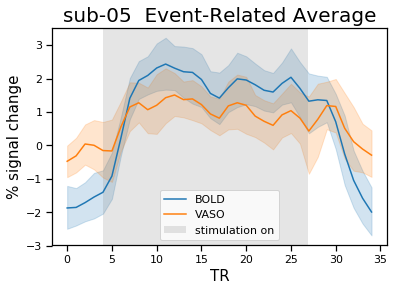

In [375]:
for sub in subs:
    
    subData = blockData.loc[blockData['subject'] == sub]

    sns.lineplot(data=subData, x='x', y='data', hue='modality')



    plt.axvspan(4, 4+(30/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
    plt.ylabel('% signal change', fontsize=15)
    plt.xlabel('TR', fontsize=15)
    plt.title(f"{sub}  Event-Related Average", fontsize=20)
#     plt.title(f"{sub} Event-Related Average")
    plt.legend(loc='lower center')
    
    values = np.arange(-4,len(blockResults[focus]['sub-08']['sub-08_ses-001_task-blockStim_run-002']['BOLD']['trial 1'])-4,4)
    spacing = np.arange(0,len(blockResults[focus]['sub-08']['sub-08_ses-001_task-blockStim_run-002']['BOLD']['trial 1']),4)

    plt.xticks(spacing,values, fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f'{root}/{sub}/ses-001/v1Focus/{sub}_blockResultsFromLayers.png')
    plt.show()

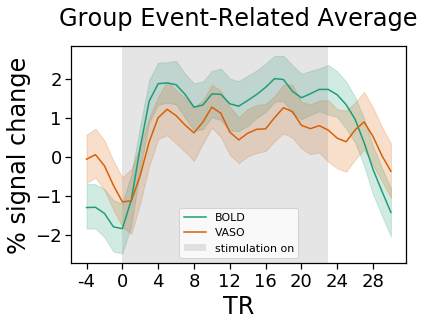

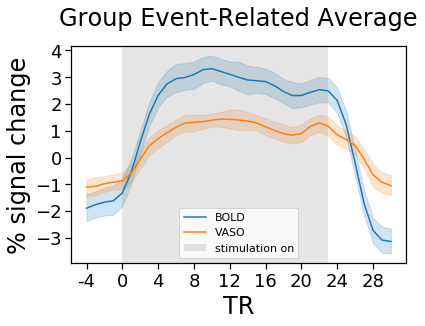

In [385]:
for focus, cmap in zip(['s1Focus', 'v1Focus'],['Dark2', 'tab10']):
    sns.lineplot(data=blockData.loc[blockData['focus']==focus], x='x', y='data', hue='modality', palette = cmap)


    plt.axvspan(4, 4+(30/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
    plt.ylabel('% signal change', fontsize=24)
    plt.xlabel('TR', fontsize=24)
    plt.title(f"Group Event-Related Average", fontsize=24, pad=20)
    plt.legend(loc='lower center')


    values = np.arange(-4,len(blockResults[focus]['sub-08']['sub-08_ses-001_task-blockStim_run-002']['BOLD']['trial 1'])-4,4)
    spacing = np.arange(0,len(blockResults[focus]['sub-08']['sub-08_ses-001_task-blockStim_run-002']['BOLD']['trial 1']),4)

    plt.xticks(spacing,values, fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'{root}/Group{focus}BlockResultsFromLayers.png', bbox_inches = "tight")
    plt.show()

In [ ]:
sns.lineplot(data=blockData, x='x', y='data', hue='modality')


plt.axvspan(4, 4+(30/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
plt.ylabel('% signal change', fontsize=15)
plt.xlabel('TR', fontsize=15)
plt.title(f"Group Event-Related Average", fontsize=20)
plt.legend(loc='lower center')


values = np.arange(-4,len(blockResults['sub-08']['sub-08_ses-001_task-blockStim_run-002']['BOLD']['trial 1'])-4,4)
spacing = np.arange(0,len(blockResults['sub-08']['sub-08_ses-001_task-blockStim_run-002']['BOLD']['trial 1']),4)

plt.xticks(spacing,values, fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(f'{root}/Group_V1blockResultsFromLayers.png')
plt.show()

### 6.2 For Events

In [379]:

subs = ['sub-05', 'sub-06','sub-07', 'sub-08']

modalities = ['BOLD', 'VASO']

eventResults = {}
for focus, cmap in zip(['s1Focus', 'v1Focus'],['Dark2', 'tab10']):
    eventResults[focus] = {}
    for sub in subs:
        print(sub)
        eventResults[focus][sub] = {}

        runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-event*_run-00*_cbv.nii.gz'))

        for run in runs:

            base = os.path.basename(run).rsplit('.', 2)[0][:-4]
            eventResults[focus][sub][base] = {}


            for modality in modalities:
                eventResults[focus][sub][base][modality] = {}

                print(f'processing {base}')

                run = f'{root}/{sub}/ses-001/{focus}/{base}_{modality}_scaled_slice.nii.gz'
                mask = nb.load(f'{root}/{sub}/ses-001/{focus}/{sub}_masks/{base}_3layers_layers_equidist_slice.nii.gz').get_fdata()

                Nii = nb.load(run)
                # As before, get the data as an array.
                data = Nii.get_fdata()[:,:,:,:-2]
                # load the nifty-header to get some meta-data.
                header = Nii.header

                # As the number of volumes which is the 4th position of
                # get_shape. This seems to be unused so I will comment it out to check.
                # nr_volumes = int(header.get_data_shape()[3])

                # Or the TR, which is the 4th position of get_zooms().
                tr = header.get_zooms()[3]

                 # Get scan duration in s
                runTime = data.shape[-1]*tr

                events = pd.read_csv(f'{root}/{sub}/ses-001/events/{base}.txt', sep = ' ', names = ['start','duration','trialType'])

                # Load information on run-wise motion
                FDs = pd.read_csv(f'{root}/{sub}/ses-001/{focus}/motionParameters/{sub}_FDs.csv')



                for i, row in events.iterrows():

                    onset = round(row['start']/tr)
                    # Do the same for the offset
                    offset = round(onset + row['duration']/tr)

                    # check whether trial is fully there
                    if offset > data.shape[3]:
                        break

                    # Because we want the % signal-change, we need the mean
                    # of the voxel we are looking at. This is done with
                    # some fancy matrix operations.
                    mask_mean = np.mean(data[:, :, :]
                                        [mask.astype(bool)])

                    # truncate motion data to event
                    tmp = FDs.loc[(FDs['volume']>=(onset-2)/2)&(FDs['volume']<=(offset+2)/2)&(FDs['run'].str.contains(f'{base}'))]

                    if not (tmp['FD']>=2).any():
                        eventResults[focus][sub][base][modality][f'trial {i}'] = np.mean((((data[:, :, :, int(onset-4):int(offset+ 8)][mask.astype(bool)]) / mask_mean)- 1) * 100,axis=0)

sub-05
processing sub-05_ses-001_task-eventStim_run-001
processing sub-05_ses-001_task-eventStim_run-001
processing sub-05_ses-001_task-eventStim_run-002
processing sub-05_ses-001_task-eventStim_run-002
sub-06
processing sub-06_ses-001_task-eventStim_run-001
processing sub-06_ses-001_task-eventStim_run-001
processing sub-06_ses-001_task-eventStim_run-002
processing sub-06_ses-001_task-eventStim_run-002
processing sub-06_ses-001_task-eventStim_run-003
processing sub-06_ses-001_task-eventStim_run-003
processing sub-06_ses-001_task-eventStim_run-004
processing sub-06_ses-001_task-eventStim_run-004
sub-07
processing sub-07_ses-001_task-eventStim_run-001
processing sub-07_ses-001_task-eventStim_run-001
processing sub-07_ses-001_task-eventStim_run-002
processing sub-07_ses-001_task-eventStim_run-002
processing sub-07_ses-001_task-eventStim_run-003
processing sub-07_ses-001_task-eventStim_run-003
processing sub-07_ses-001_task-eventStim_run-004
processing sub-07_ses-001_task-eventStim_run-004

In [ ]:
## Event results created wih layers



subList = []
dataList = []
xList = []
modalityList = []
trialList = []
runList = []
focusList = []
for focus, cmap in zip(['s1Focus', 'v1Focus'],['Dark2', 'tab10']):

    for sub in subs:
        print(sub)

        runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-event*_run-00*_cbv.nii.gz'))

        for run in runs:

            base = os.path.basename(run).rsplit('.', 2)[0][:-4]


            for modality in modalities:

                subTrials = []
                for key, value in eventResults[focus][sub][base][modality].items():
                    subTrials.append(key)

                for trial in subTrials[:-1]:
                    print(trial)

                    for n in range(len(eventResults[focus][sub][base][modality][trial])):

                        if modality == "BOLD":
                            dataList.append(eventResults[focus][sub][base][modality][trial][n])

                        if modality == "VASO":
                            dataList.append(-eventResults[focus][sub][base][modality][trial][n])

                        modalityList.append(modality)
                        trialList.append(trial)
                        runList.append(base)
                        xList.append(n)
                        subList.append(sub)
                        focusList.append(focus)
        

eventData = pd.DataFrame({'subject': subList,'x':xList, 'data': dataList, 'modality': modalityList, 'trial': trialList, 'run':runList, 'focus': focusList})

In [ ]:
for sub in subs:
    
    subData = eventData.loc[eventData['subject'] == sub]

    sns.lineplot(data=subData, x='x', y='data', hue='modality')



    plt.axvspan(4, 4+(2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
    plt.ylabel('% signal change', fontsize=15)
    plt.xlabel('TR', fontsize=15)
    plt.title(f"{sub}  Event-Related Average", fontsize=20)
    plt.legend(loc='upper right')
    
    values = np.arange(-4,len(eventResults['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD']['trial 1'])-4,2)
    spacing = np.arange(0,len(eventResults['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD']['trial 1']),2)
    plt.xticks(spacing,values, fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(f'{root}/{sub}/ses-001/v1Focus/{sub}_V1EventResultsFromLayers.png')
    plt.show()

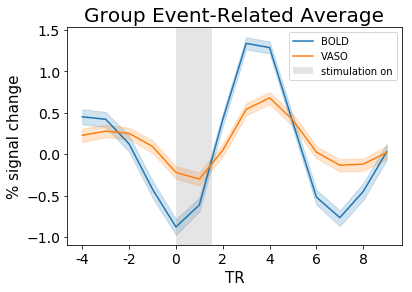

In [122]:
for focus, cmap in zip(['s1Focus', 'v1Focus'],['Dark2', 'tab10']):
    sns.lineplot(data=eventData, x='x', y='data', hue='modality', palette=cmap)


    plt.axvspan(4, 4+(2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
    plt.ylabel('% signal change', fontsize=15)
    plt.xlabel('TR', fontsize=15)
    plt.title(f"Group Event-Related Average", fontsize=20)
    plt.legend(loc='upper right')

    values = np.arange(-4,len(eventResults[focus]['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD']['trial 1'])-4,2)
    spacing = np.arange(0,len(eventResults[focus]['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD']['trial 1']),2)
    plt.xticks(spacing,values, fontsize=14)
    plt.yticks(fontsize=14)
    # plt.xticks(spacing,values)
    plt.savefig(f'{root}/GroupV1EventResultsFromLayers.png', bbox_inches = "tight")
    plt.show()

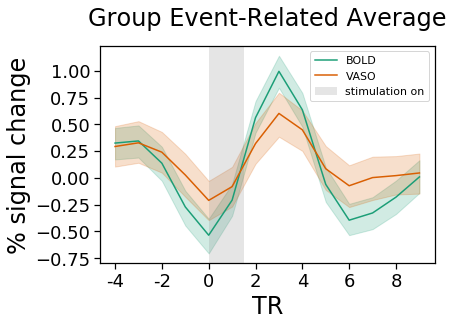

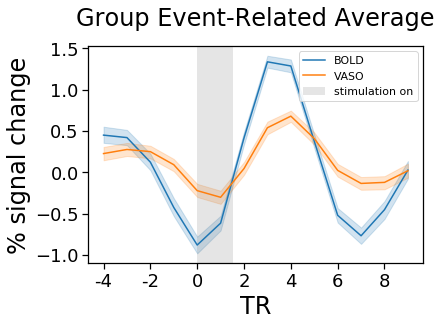

In [386]:
for focus, cmap in zip(['s1Focus', 'v1Focus'],['Dark2', 'tab10']):
    sns.lineplot(data=eventData.loc[eventData['focus']==focus], x='x', y='data', hue='modality', palette=cmap)


    plt.axvspan(4, 4+(2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
    plt.ylabel('% signal change', fontsize=24)
    plt.xlabel('TR', fontsize=24)
    plt.title(f"Group Event-Related Average", fontsize=24, pad=20)
    plt.legend(loc='upper right')



    values = np.arange(-4,len(eventResults[focus]['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD']['trial 1'])-4,2)
    spacing = np.arange(0,len(eventResults[focus]['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD']['trial 1']),2)

    plt.xticks(spacing,values, fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(f'{root}/Group{focus}EventResultsFromLayers.png', bbox_inches = "tight")
    plt.show()

### 6.3 For Layers

In [ ]:
%%bash

delta_x=$(3dinfo -di /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-05/ses-001/v1Focus/sub-05_ses-001_T1w.nii)
delta_y=$(3dinfo -dj /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-05/ses-001/v1Focus/sub-05_ses-001_T1w.nii)
delta_z=$(3dinfo -dk /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-05/ses-001/v1Focus/sub-05_ses-001_T1w.nii)
sdelta_x=$(echo "((sqrt($delta_x * $delta_x) / 5))"|bc -l)
sdelta_y=$(echo "((sqrt($delta_y * $delta_y) / 5))"|bc -l)
sdelta_z=$(echo "((sqrt($delta_z * $delta_z) / 1))"|bc -l)

for sub in 08
do
echo ""
echo ""
echo ""
echo ""
echo 'processing sub-'$sub''

cd /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-$sub/ses-001/s1Focus/

3dresample -dxyz $sdelta_x $sdelta_y $sdelta_z -rmode Cu -overwrite -prefix eventStim_secondLevel_VASO.gfeat/cope1.feat/stats/zstat1_scaled.nii.gz -input eventStim_secondLevel_VASO.gfeat/cope1.feat/stats/zstat1.nii.gz
# 3dresample -dxyz $sdelta_x $sdelta_y $sdelta_z -rmode Cu -overwrite -prefix eventStim_secondLevel_BOLD.gfeat/cope1.feat/stats/zstat1_scaled.nii.gz -input eventStim_secondLevel_BOLD.gfeat/cope1.feat/stats/zstat1.nii.gz

done

In [200]:
%%bash
for sub in 06
do
declare -a runs=('/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-'$sub'/ses-001/func/*event*.nii.gz')
echo $runs

echo 'Found '${#runs[@]}' run(s) for sub-'$sub''

for run in $runs
do
echo 'processing run '$run''

# define basename for output files
base=`basename $run _cbv.nii.gz`

cd /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-06/ses-001/s1Focus/

delta_x=$(3dinfo -di ''${base}'_T1w.nii')
delta_y=$(3dinfo -dj ''${base}'_T1w.nii')
delta_z=$(3dinfo -dk ''${base}'_T1w.nii')
sdelta_x=$(echo "((sqrt($delta_x * $delta_x) / 5))"|bc -l)
sdelta_y=$(echo "((sqrt($delta_y * $delta_y) / 5))"|bc -l)
sdelta_z=$(echo "((sqrt($delta_z * $delta_z) / 1))"|bc -l)

3dresample -dxyz $sdelta_x $sdelta_y $sdelta_z -rmode Cu -overwrite -prefix ''${base}'_VASO_peakAdjust.feat/stats/zstat1_scaled.nii.gz' -input ''${base}'_VASO_peakAdjust.feat/stats/zstat1.nii.gz'


done
done

/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-06/ses-001/func/sub-06_ses-001_task-eventStim_run-001_cbv.nii.gz /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-06/ses-001/func/sub-06_ses-001_task-eventStim_run-002_cbv.nii.gz /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-06/ses-001/func/sub-06_ses-001_task-eventStim_run-003_cbv.nii.gz /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-06/ses-001/func/sub-06_ses-001_task-eventStim_run-004_cbv.nii.gz
Found 1 run(s) for sub-06
processing run /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-06/ses-001/func/sub-06_ses-001_task-eventStim_run-001_cbv.nii.gz
processing run /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-06/ses-001/func/sub-06_ses-001_task-eventStim_run-002_cbv.nii.gz
processing run /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-06/ses-001/func/sub-06_ses-001_task-eventStim_run-003_cbv.nii.gz
processing run /media/sebastian/Data/EVENTRELATED_PILOT/rawDa

*+ WARNING:   If you are performing spatial transformations on an oblique dset,
  such as /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-06/ses-001/s1Focus/sub-06_ses-001_task-eventStim_run-001_VASO_peakAdjust.feat/stats/zstat1.nii.gz,
  or viewing/combining it with volumes of differing obliquity,
  you should consider running: 
     3dWarp -deoblique 
  on this and  other oblique datasets in the same session.
 See 3dWarp -help for details.
++ Oblique dataset:/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-06/ses-001/s1Focus/sub-06_ses-001_task-eventStim_run-001_VASO_peakAdjust.feat/stats/zstat1.nii.gz is 35.500004 degrees from plumb.
*+ WARNING:   If you are performing spatial transformations on an oblique dset,
  such as /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-06/ses-001/s1Focus/sub-06_ses-001_task-eventStim_run-002_VASO_peakAdjust.feat/stats/zstat1.nii.gz,
  or viewing/combining it with volumes of differin

In [ ]:
%%bash


for sub in 05 06 07 08
do
echo ""
echo ""
echo ""
echo ""
echo 'processing sub-'$sub''

cd /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-$sub/ses-001/v1Focus/

declare -a runs=('/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-'$sub'/ses-001/func/*.nii.gz')
echo $runs

echo 'Found '${#runs[@]}' run(s) for sub-'$sub''

for run in $runs
do
echo 'processing run '$run''

# define basename for output files
base=`basename $run _cbv.nii.gz`

# fslmaths ''${base}'_VASO.feat/stats/cope1.nii.gz' -div ''${base}'_VASO.feat/mean_func.nii.gz' ''${base}'_VASO.feat/stats/beta1.nii.gz'
# fslmaths ''${base}'_BOLD_intemp.feat/stats/cope1.nii.gz' -div ''${base}'_BOLD_intemp.feat/mean_func.nii.gz' ''${base}'_BOLD_intemp.feat/stats/beta1.nii.gz'



delta_x=$(3dinfo -di ''${base}'_T1w.nii')
delta_y=$(3dinfo -dj ''${base}'_T1w.nii')
delta_z=$(3dinfo -dk ''${base}'_T1w.nii')
sdelta_x=$(echo "((sqrt($delta_x * $delta_x) / 5))"|bc -l)
sdelta_y=$(echo "((sqrt($delta_y * $delta_y) / 5))"|bc -l)
sdelta_z=$(echo "((sqrt($delta_z * $delta_z) / 1))"|bc -l)

3dresample -dxyz $sdelta_x $sdelta_y $sdelta_z -rmode Cu -overwrite -prefix ''${base}'_VASO.feat/stats/pe1_scaled.nii.gz' -input ''${base}'_VASO.feat/stats/pe1.nii.gz'
3dresample -dxyz $sdelta_x $sdelta_y $sdelta_z -rmode Cu -overwrite -prefix ''${base}'_BOLD_intemp.feat/stats/pe1_scaled.nii.gz' -input ''${base}'_BOLD_intemp.feat/stats/pe1.nii.gz'


# 3dresample -dxyz $sdelta_x $sdelta_y $sdelta_z -rmode Cu -overwrite -prefix ''${base}'_VASO.feat/stats/beta1_scaled.nii.gz' -input ''${base}'_VASO.feat/stats/beta1.nii.gz'
# 3dresample -dxyz $sdelta_x $sdelta_y $sdelta_z -rmode Cu -overwrite -prefix ''${base}'_BOLD_intemp.feat/stats/beta1_scaled.nii.gz' -input ''${base}'_BOLD_intemp.feat/stats/beta1.nii.gz'


# 3dresample -dxyz $sdelta_x $sdelta_y $sdelta_z -rmode Cu -overwrite -prefix ''${base}'_BOLD_scaled.nii' -input ''${base}'_BOLD_intemp.nii'
# 3dresample -dxyz $sdelta_x $sdelta_y $sdelta_z -rmode Cu -overwrite -prefix ''${base}'_VASO_scaled.nii' -input ''${base}'_VASO.nii.gz'

done
done


In [ ]:
%%bash

for sub in 08
do
echo ""
echo ""
echo ""
echo ""
echo 'processing sub-'$sub''

cd /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-$sub/ses-001/v1Focus/


fslroi rim_layers_equidist.nii rim_layers_equidist_trunc.nii 390 100 0 200 4 3



declare -a runs=('/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-'$sub'/ses-001/func/*event*.nii.gz')
echo $runs

echo 'Found '${#runs[@]}' run(s) for sub-'$sub''

for run in $runs
do
echo 'processing run '$run''

# define basename for output files
base=`basename $run _cbv.nii.gz`

fslroi ''${base}'_BOLD_scaled.nii' ''${base}'_BOLD_scaled_trunc.nii' 390 100 0 200 4 3
fslroi ''${base}'_VASO_scaled.nii' ''${base}'_VASO_scaled_trunc.nii' 390 100 0 200 4 3


done
done


In [ ]:
### find slice of mask
import numpy as np
import glob
import nibabel as nb
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import plotting
import seaborn as sns
from scipy.interpolate import interp1d
import os
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

root = '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives'
modalities = ['BOLD', 'VASO']

subs = ['sub-05', 'sub-06','sub-07','sub-08']
# subs = ['sub-05']
sliceNrs = []

for sub in subs:
    print(sub) 
    mask = nb.load(f'{root}/{sub}/ses-001/v1Focus/{sub}_masks/{sub}_ses-001_task-eventStim_run-001_layers_equidist.nii').get_fdata()
    print(mask.shape)
    non = np.nonzero(mask)
    sliceNR = np.unique(non[-1])[0]
    print(sliceNR)
    sliceNrs.append(str(sliceNR))

In [ ]:
%%bash




for sub in 05
do
echo ""
echo ""
echo ""
echo ""
echo 'processing sub-'$sub''


declare -a runs=('/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-'$sub'/ses-001/func/*.nii.gz')
echo $runs

echo 'Found '${#runs[@]}' run(s) for sub-'$sub''

for run in $runs
do
echo 'processing run '$run''

# define basename for output files
base=`basename $run _cbv.nii.gz`

cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/v1Focus/sub-'$sub'_masks/'


LN2_LAYERS -rim ''${base}'_rim.nii.gz' -nr_layers 11 -output ''${base}'_11layers'
LN2_LAYERS -rim ''${base}'_rim.nii.gz' -nr_layers 3 -output ''${base}'_3layers'


fslroi ''${base}'_11layers_layers_equidist.nii' ''${base}'_11layers_layers_equidist_slice.nii' 0 750 0 250 12 3
fslroi ''${base}'_3layers_layers_equidist.nii' ''${base}'_3layers_layers_equidist_slice.nii' 0 750 0 250 12 3

cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/v1Focus/'

# fslroi ''${base}'_VASO_scaled.nii' ''${base}'_VASO_scaled_slice.nii' 0 750 0 250 12 3
# echo 'VASO done'
# fslroi ''${base}'_BOLD_scaled.nii' ''${base}'_BOLD_scaled_slice.nii' 0 750 0 250 12 3
# echo 'BOLD done'

 
 fslroi ''${base}'_BOLD_intemp.feat/stats/beta1_scaled.nii.gz' ''${base}'_BOLD_intemp.feat/stats/beta1_scaled_slice.nii.gz'


done
done

In [ ]:
%%bash




for sub in 06
do
echo ""
echo ""
echo ""
echo ""
echo 'processing sub-'$sub''

cd /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-$sub/ses-001/v1Focus/


declare -a runs=('/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-'$sub'/ses-001/func/*.nii.gz')
echo $runs

echo 'Found '${#runs[@]}' run(s) for sub-'$sub''

for run in $runs
do
echo 'processing run '$run''

# define basename for output files
base=`basename $run _cbv.nii.gz`

cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/v1Focus/sub-'$sub'_masks/'


LN2_LAYERS -rim ''${base}'_rim.nii.gz' -nr_layers 11 -output ''${base}'_11layers'
LN2_LAYERS -rim ''${base}'_rim.nii.gz' -nr_layers 3 -output ''${base}'_3layers'


fslroi ''${base}'_11layers_layers_equidist.nii' ''${base}'_11layers_layers_equidist_slice.nii' 0 750 0 250 4 3
fslroi ''${base}'_3layers_layers_equidist.nii' ''${base}'_3layers_layers_equidist_slice.nii' 0 750 0 250 4 3

cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/v1Focus/'


# fslroi ''${base}'_VASO_scaled.nii' ''${base}'_VASO_scaled_slice.nii' 0 750 0 250 4 3
# echo 'VASO done'
# fslroi ''${base}'_BOLD_scaled.nii' ''${base}'_BOLD_scaled_slice.nii' 0 750 0 250 4 3
# echo 'BOLD done'



done
done

In [ ]:
%%bash




for sub in 07
do
echo ""
echo ""
echo ""
echo ""
echo 'processing sub-'$sub''

cd /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-$sub/ses-001/v1Focus/


declare -a runs=('/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-'$sub'/ses-001/func/*.nii.gz')
echo $runs

echo 'Found '${#runs[@]}' run(s) for sub-'$sub''

for run in $runs
do
echo 'processing run '$run''

# define basename for output files
base=`basename $run _cbv.nii.gz`


cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/v1Focus/sub-'$sub'_masks/'


LN2_LAYERS -rim ''${base}'_rim.nii.gz' -nr_layers 11 -output ''${base}'_11layers'
LN2_LAYERS -rim ''${base}'_rim.nii.gz' -nr_layers 3 -output ''${base}'_3layers'


fslroi ''${base}'_11layers_layers_equidist.nii' ''${base}'_11layers_layers_equidist_slice.nii' 0 750 0 250 2 3
fslroi ''${base}'_3layers_layers_equidist.nii' ''${base}'_3layers_layers_equidist_slice.nii' 0 750 0 250 2 3

# cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/v1Focus/'
# fslroi ''${base}'_VASO_scaled.nii' ''${base}'_VASO_scaled_slice.nii' 0 750 0 250 2 3
# echo 'VASO done'
# fslroi ''${base}'_BOLD_scaled.nii' ''${base}'_BOLD_scaled_slice.nii' 0 750 0 250 2 3
# echo 'BOLD done'


done
done

In [ ]:
%%bash



for sub in 08
do
echo ""
echo ""
echo ""
echo ""
echo 'processing sub-'$sub''

cd /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-$sub/ses-001/v1Focus/


declare -a runs=('/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-'$sub'/ses-001/func/*.nii.gz')
echo $runs

echo 'Found '${#runs[@]}' run(s) for sub-'$sub''

for run in $runs
do
echo 'processing run '$run''

# define basename for output files
base=`basename $run _cbv.nii.gz`

cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/v1Focus/sub-'$sub'_masks/'


LN2_LAYERS -rim ''${base}'_rim.nii.gz' -nr_layers 11 -output ''${base}'_11layers'
LN2_LAYERS -rim ''${base}'_rim.nii.gz' -nr_layers 3 -output ''${base}'_3layers'


fslroi ''${base}'_11layers_layers_equidist.nii' ''${base}'_11layers_layers_equidist_slice.nii' 0 750 0 250 4 3
fslroi ''${base}'_3layers_layers_equidist.nii' ''${base}'_3layers_layers_equidist_slice.nii' 0 750 0 250 4 3

# cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/v1Focus/'

# fslroi ''${base}'_VASO_scaled.nii' ''${base}'_VASO_scaled_slice.nii' 0 750 0 250 4 3
# echo 'VASO done'
# fslroi ''${base}'_BOLD_scaled.nii' ''${base}'_BOLD_scaled_slice.nii' 0 750 0 250 4 3
# echo 'BOLD done'


done
done

In [ ]:
root = '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives'

subs = ['sub-05', 'sub-06','sub-07','sub-08']
# subs = ['sub-05']

# subs = ['sub-08']
modalities = ['BOLD', 'VASO']


layerEventResults = {}

for focus, cmap in zip(['s1Focus', 'v1Focus'],['Dark2', 'tab10']):
    layerEventResults[focus] = {}
    for sub in subs:
        print(sub)
        layerEventResults[focus][sub] = {}

        runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-eventStim_run-00*_cbv.nii.gz'))

        for run in runs:

            base = os.path.basename(run).rsplit('.', 2)[0][:-4]
            print(base)
            layerEventResults[focus][sub][base] = {}

            mask = nb.load(f'{root}/{sub}/ses-001/{focus}/{sub}_masks/{base}_3layers_layers_equidist_slice.nii.gz').get_fdata()

            idx_layers = np.unique(mask.astype("int"))
            idx_layers = idx_layers[1:]

            for modality in modalities:
                print(modality)
                layerEventResults[focus][sub][base][modality] = {}

                skippedTrials = 0


                run = f'{root}/{sub}/ses-001/{focus}/{base}_{modality}_scaled_slice.nii.gz'

                Nii = nb.load(run)
                # As before, get the data as an array.
                data = Nii.get_fdata()[:,:,:,:-2]
                # load the nifty-header to get some meta-data.
                header = Nii.header

                # As the number of volumes which is the 4th position of
                # get_shape. This seems to be unused so I will comment it out to check.
                # nr_volumes = int(header.get_data_shape()[3])

                # Or the TR, which is the 4th position of get_zooms().
                tr = header.get_zooms()[3]

                 # Get scan duration in s
                runTime = data.shape[-1]*tr

                events = pd.read_csv(f'{root}/{sub}/ses-001/events/{base}.txt', sep = ' ', names = ['start','duration','trialType'])[:-1]

                # Load information on run-wise motion
                FDs = pd.read_csv(f'{root}/{sub}/ses-001/{focus}/motionParameters/{sub}_FDs.csv')

                # Because we want the % signal-change, we need the mean
                # of the voxel we are looking at. This is done with
                # some fancy matrix operations.

                for j in idx_layers:  # Compute bin averages

                    layerEventResults[focus][sub][base][modality][f'layer {j}'] = {}

                    layerRoi = mask == j



                    mask_mean = np.mean(data[:, :, :]
                                        [layerRoi.astype(bool)])

                    includedTrials = []

                    for i, row in events.iterrows():


                        onset = round(row['start']/tr)
                        # Do the same for the offset
                        offset = round(onset + row['duration']/tr)


                        # truncate motion data to event
                        tmp = FDs.loc[(FDs['volume']>=(onset-2)/2)&(FDs['volume']<=(offset+2)/2)&(FDs['run'].str.contains(f'{base}[-17:]'))]


                        if not (tmp['FD']>=2).any():

                            layerEventResults[focus][sub][base][modality][f'layer {j}'][f'trial {i}'] = np.mean((((data[:, :, :, int(onset-4):int(offset+ 8)][layerRoi.astype(bool)]) / mask_mean)- 1) * 100,axis=0)
                            includedTrials.append(f'trial {i}')



In [ ]:
subList = []
dataList = []
xList = []
modalityList = []
trialList = []
runList = []
layerList = []
focusList = []

layers = {'1':'deep','2':'middle','3':'superficial'}

# subs = ['sub-05']
for focus, cmap in zip(['s1Focus', 'v1Focus'],['Dark2', 'tab10']):
    for sub in subs:
        print(sub)
        runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-event*_run-00*_cbv.nii.gz'))

        for run in runs:

            base = os.path.basename(run).rsplit('.', 2)[0][:-4]
            print(base)

            for modality in modalities:
                print(modality)

                for j in range(1, 4):

                    subTrials = []
                    for key, value in layerEventResults[focus][sub][base][modality][f'layer {j}'].items():
                        subTrials.append(key)

                    for trial in subTrials[:-1]:

                        for n in range(len(layerEventResults[focus][sub][base][modality][f'layer {j}'][trial])):

                            if modality == "BOLD":
                                dataList.append(layerEventResults[focus][sub][base][modality][f'layer {j}'][trial][n])

                            if modality == "VASO":
                                dataList.append(-layerEventResults[focus][sub][base][modality][f'layer {j}'][trial][n])

                            modalityList.append(modality)
                            trialList.append(trial)
                            runList.append(base)
                            xList.append(n)
                            subList.append(sub)
                            layerList.append(layers[str(j)])
                            focusList.append(focus)


layerEventData = pd.DataFrame({'subject': subList,'x':xList, 'data': dataList, 'modality': modalityList, 'trial': trialList, 'run':runList, 'layer':layerList, 'focus': focusList})

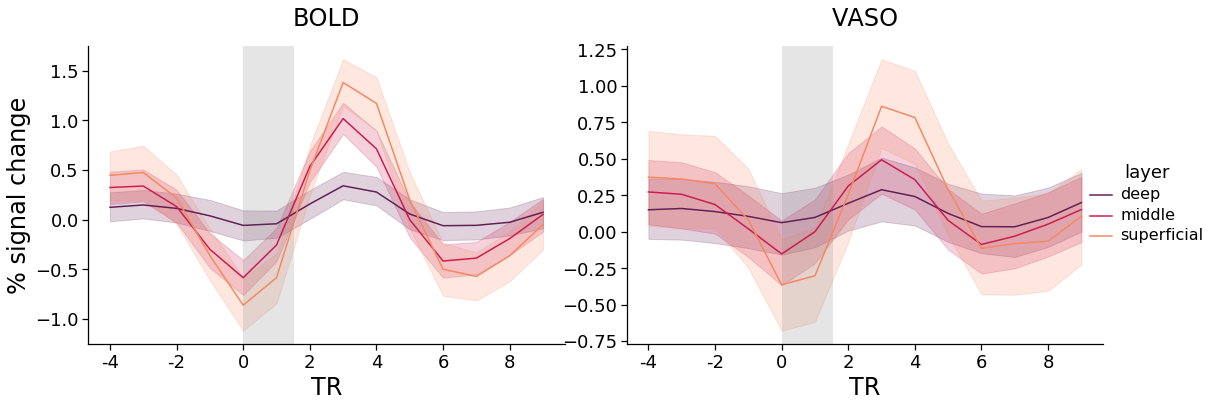

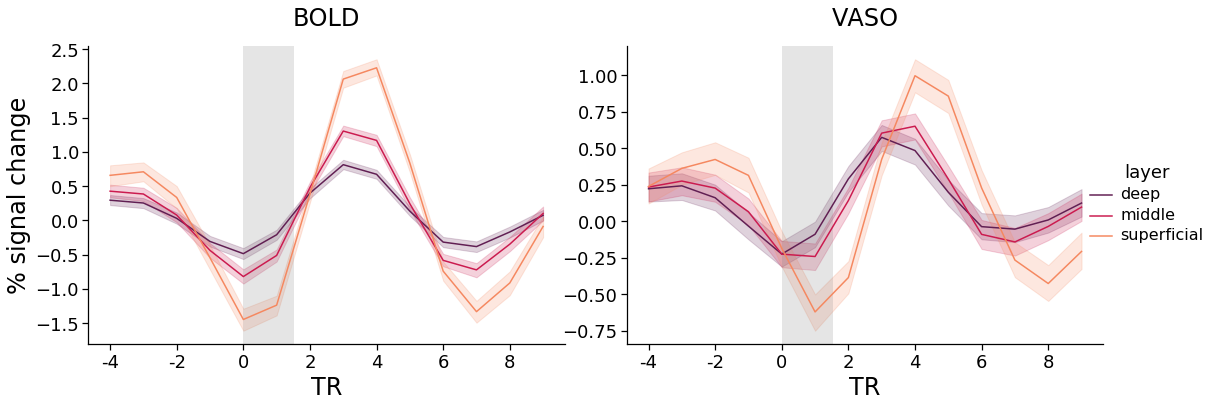

In [393]:
for focus, cmap in zip(['s1Focus', 'v1Focus'],['Dark2', 'tab10']):
    
    g = sns.FacetGrid(layerEventData.loc[layerEventData['focus']==focus], col="modality", hue="layer", sharey=False, height= 5, aspect = 1.5,palette='rocket')
    g.map_dataframe(sns.lineplot, x="x", y="data")
    g.add_legend()
    g.axes[0,0].set_ylabel('% signal change', fontsize=24)

    g.axes[0,1].set_xlabel('TR', fontsize=24)
    g.axes[0,0].set_xlabel('TR', fontsize=24)


    g.axes[0,1].set_title('VASO', fontsize=24, pad=20)
    g.axes[0,0].set_title('BOLD', fontsize=24, pad=20)


    g.axes[0,0].axvspan(4, 4 + (2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
    g.axes[0,1].axvspan(4, 4 + (2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')


    plt.setp(g._legend.get_title(), fontsize=18)
    plt.setp(g._legend.get_texts(), fontsize=16)



    values = np.arange(-4,len(layerEventResults[focus]['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD'][f'layer {3}']['trial 1'])-4,2)
    spacing = np.arange(0,len(layerEventResults[focus]['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD'][f'layer {3}']['trial 1']),2)

    g.axes[0,0].set_xticks(spacing)

    g.axes[0,0].set_xticklabels(values,fontsize=18)
    g.axes[0,1].set_xticklabels(values,fontsize=18)


    plt.setp(g.axes[0,0].get_yticklabels(), fontsize=18)
    plt.setp(g.axes[0,1].get_yticklabels(), fontsize=18)




    g.savefig(f"{root}/eventResults{focus}LayersModalityVsLayers.png")

In [358]:
g = sns.FacetGrid(eventData, col="modality", hue="layer", sharey=False, height= 5, aspect = 1.5, palette='rocket')
# g = sns.FacetGrid(eventData, col="modality", hue="layer", sharey=False, height= 5, aspect = 1.5)

g.map_dataframe(sns.lineplot, x="x", y="data")
g.add_legend()
g.axes[0,0].set_ylabel('% signal change', fontsize=15)

g.axes[0,1].set_xlabel('TR', fontsize=15)
g.axes[0,0].set_xlabel('TR', fontsize=15)


g.axes[0,1].set_title('VASO', fontsize=20)
g.axes[0,0].set_title('BOLD', fontsize=20)


g.axes[0,0].axvspan(4, 4 + (2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
g.axes[0,1].axvspan(4, 4 + (2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')


plt.setp(g._legend.get_title(), fontsize=15)
plt.setp(g._legend.get_texts(), fontsize=12)






values = np.arange(-4,len(singleEventResults['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD'][f'layer {3}']['trial 1'])-4,2)
spacing = np.arange(0,len(singleEventResults['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD'][f'layer {3}']['trial 1']),2)

g.axes[0,0].set_xticks(spacing)

g.axes[0,0].set_xticklabels(values,fontsize=14)
g.axes[0,1].set_xticklabels(values,fontsize=14)


plt.setp(g.axes[0,0].get_yticklabels(), fontsize=14)
plt.setp(g.axes[0,1].get_yticklabels(), fontsize=14)



g.savefig("/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/eventResultsV1LayersModalityVsLayers.png")

KeyError: 'layer'

In [ ]:
for sub in subs:
    tmp = eventData.loc[eventData['subject']==sub]
    g = sns.FacetGrid(tmp, col="modality", hue="layer", sharey=False, height= 5, aspect = 1.5)
    g.map_dataframe(sns.lineplot, x="x", y="data")
    g.add_legend()
    g.axes[0,0].set_ylabel('% signal change', fontsize=15)

    g.axes[0,1].set_xlabel('TR', fontsize=15)
    g.axes[0,0].set_xlabel('TR', fontsize=15)


    g.axes[0,1].set_title('VASO', fontsize=20)
    g.axes[0,0].set_title('BOLD', fontsize=20)


    g.axes[0,0].axvspan(4, 4 + (2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
    g.axes[0,1].axvspan(4, 4 + (2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')


    plt.setp(g._legend.get_title(), fontsize=15)
    plt.setp(g._legend.get_texts(), fontsize=12)
    plt.suptitle(sub)
    
    values = np.arange(-4,len(singleEventResults['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD'][f'layer {j}']['trial 1'])-4,2)
    spacing = np.arange(0,len(singleEventResults['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD'][f'layer {j}']['trial 1']),2)

    g.axes[0,0].set_xticks(spacing)

    g.axes[0,0].set_xticklabels(values,fontsize=12)
    g.axes[0,1].set_xticklabels(values,fontsize=12)


    plt.setp(g.axes[0,0].get_yticklabels(), fontsize=12)
    plt.setp(g.axes[0,1].get_yticklabels(), fontsize=12)



    g.savefig(f"{root}/{sub}_eventResultsV1LayersModalityVsLayers.png")

### extract zscores

In [ ]:
%%bash

for sub in 05 06 07 08
do

cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/v1Focus/sub-'$sub'_masks'

declare -a runs=('/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-'$sub'/ses-001/func/*.nii.gz')
echo $runs

echo 'Found '${#runs[@]}' run(s) for sub-'$sub''

for run in $runs
do
echo 'processing run '$run''

# define basename for output files
base=`basename $run _cbv.nii.gz`


LN2_LAYERS -rim ''${base}'_rim.nii' -nr_layers 3 -output ${base}_3layers

done
done

In [ ]:
subList = []
dataList = []
modalityList = []
layerList = []
stimTypeList = []

# layers = {'1':'deep','2':'middle','3':'superficial'}

# subs = ['sub-08']
subs = ['sub-05', 'sub-06', 'sub-07', 'sub-08']


for sub in subs:
    for stimType in ['blockStim', 'eventStim']:
    
        runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-{stimType}_run-00*_cbv.nii.gz'))

        for run in runs:

            base = os.path.basename(run).rsplit('.', 2)[0][:-4]
            print(base)
            mask = nb.load(f'{root}/{sub}/ses-001/v1Focus/{sub}_masks/{base}_11layers_layers_equidist.nii').get_fdata()

            for modality in ['BOLD_intemp','VASO']:
                data = nb.load(f'{root}/{sub}/ses-001/v1Focus/{base}_{modality}.feat/stats/zstat1_scaled.nii.gz').get_fdata()

                for j in range(1,12):  # Compute bin averages
                    layerRoi = mask == j
                    mask_mean = np.mean(data[layerRoi.astype(bool)])

                    subList.append(sub)
                    dataList.append(mask_mean)
                    modalityList.append(modality)
                    layerList.append(j)
                    stimTypeList.append(stimType)



            
zscores = pd.DataFrame({'subject': subList, 'data': dataList, 'modality': modalityList, 'layer':layerList, 'stimType':stimTypeList})

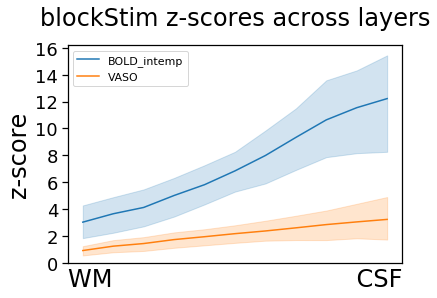

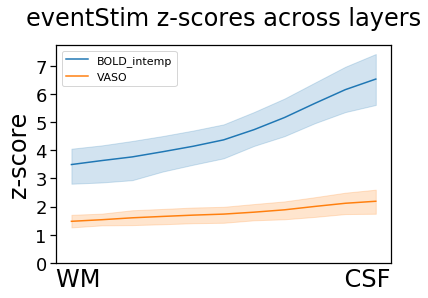

In [774]:
from matplotlib.ticker import MaxNLocator

# for focus in ['v1Focus', 's1Focus']:
for stimType in ['blockStim', 'eventStim']:
    fig, ax = plt.subplots()
    tmp = zscores.loc[(zscores['stimType']==stimType)&(zscores['focus']=='v1Focus')]

    sns.lineplot(data=tmp, x='layer', y='data', hue='modality')


    plt.ylabel('z-score', fontsize=24)
    
    plt.title(f"{stimType} z-scores across layers", fontsize=24, pad=20)
    plt.xlabel('WM                                CSF', fontsize=24)
    plt.xticks([])
    yLimits = ax.get_ylim()
    plt.ylim(0,yLimits[1])    

    plt.yticks(fontsize=18)

    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.legend(loc='upper left')
    
    
    plt.savefig(f'{root}/Group_V1_{stimType}_zScoreProfile.png', bbox_inches = "tight")
    plt.show()

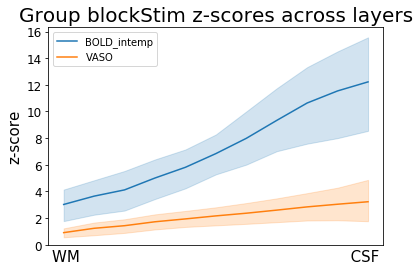

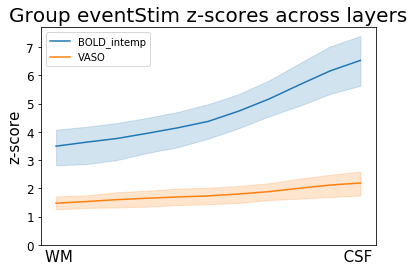

In [117]:
for stimType in ['blockStim', 'eventStim']:
    
    fig, ax = plt.subplots()
    
    tmp = zscores.loc[zscores['stimType']==stimType]

    sns.lineplot(data=tmp, x='layer', y='data', hue='modality')


    plt.ylabel('z-score', fontsize=24)
#     plt.xlabel('cortical depth', fontsize=15)
    plt.title(f"Group {stimType} z-scores across layers", fontsize=20)
    plt.xlabel('WM                                                         CSF')
    plt.xticks([])
    plt.yticks(fontsize=12)
    plt.legend(loc='upper left')
    
    yLimits = ax.get_ylim()
    plt.ylim(0,yLimits[1])
    
#     ax.set_yticklabels(ax.get_yticklabels(),fontsize=12)
    plt.savefig(f'{root}/Group_{stimType}_zScoreProfileTest.png')
    plt.show()

In [ ]:
g = sns.FacetGrid(zscores, col="modality", hue="stimType", sharey=True, height= 5, aspect = 1.5)
g.map_dataframe(sns.lineplot, x="layer", y="data")
g.add_legend()
g.axes[0,0].set_ylabel('z-score', fontsize=15)

# g.axes[0,1].set_xlabel('TR', fontsize=15)
# g.axes[0,0].set_xlabel('TR', fontsize=15)


# g.axes[0,1].set_title('eventStim', fontsize=20)
# g.axes[0,0].set_title('blockStim', fontsize=20)


# g.axes[0,0].axvspan(4, 4 + (2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
# g.axes[0,1].axvspan(4, 4 + (2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')


plt.setp(g._legend.get_title(), fontsize=15)
plt.setp(g._legend.get_texts(), fontsize=12)
g.axes[0,0].set_xlabel('WM                                                                                              GM', fontsize = 15)
g.axes[0,0].set_xticks([])
g.axes[0,1].set_xlabel('WM                                                                                              GM', fontsize = 15)
g.axes[0,1].set_xticks([])

g.savefig("/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/comparingV1Zscores.png")

In [ ]:
g = sns.FacetGrid(zscores, col="stimType", hue="modality", sharey=True, height= 5, aspect = 1.5)
g.map_dataframe(sns.lineplot, x="layer", y="data")
g.add_legend()
g.axes[0,0].set_ylabel('z-score', fontsize=15)

# g.axes[0,1].set_xlabel('TR', fontsize=15)
# g.axes[0,0].set_xlabel('TR', fontsize=15)


g.axes[0,1].set_title('eventStim', fontsize=20)
g.axes[0,0].set_title('blockStim', fontsize=20)


# g.axes[0,0].axvspan(4, 4 + (2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
# g.axes[0,1].axvspan(4, 4 + (2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')


plt.setp(g._legend.get_title(), fontsize=15)
plt.setp(g._legend.get_texts(), fontsize=12)
g.axes[0,0].set_xlabel('WM                                                                                              GM', fontsize = 15)
g.axes[0,0].set_xticks([])
g.axes[0,1].set_xlabel('WM                                                                                              GM', fontsize = 15)
g.axes[0,1].set_xticks([])

g.savefig("/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/comparingZscores.png")

## S1 Focus

In [ ]:
# Slices for each subject

# sub-05 - 5 3
# sub-06 
# sub-07 - 8 3
# sub-08 - 5 3

In [ ]:
%%bash




for sub in 05
do
echo ""
echo ""
echo ""
echo ""
echo 'processing sub-'$sub''

cd /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-$sub/ses-001/s1Focus/


declare -a runs=('/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-'$sub'/ses-001/func/*.nii.gz')
echo $runs

echo 'Found '${#runs[@]}' run(s) for sub-'$sub''

for run in $runs
do
echo 'processing run '$run''

# define basename for output files
base=`basename $run _cbv.nii.gz`

cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/s1Focus/sub-'$sub'_masks'

LN2_LAYERS -rim ''${base}'_rim.nii.gz' -nr_layers 11 -output ''${base}'_11layers'
LN2_LAYERS -rim ''${base}'_rim.nii.gz' -nr_layers 3 -output ''${base}'_3layers'

fslroi ''${base}'_11layers_layers_equidist.nii' ''${base}'_11layers_layers_equidist_slice.nii' 0 750 0 350 12 3
fslroi ''${base}'_3layers_layers_equidist.nii' ''${base}'_3layers_layers_equidist_slice.nii' 0 750 0 350 12 3


# cd /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-$sub/ses-001/s1Focus

# fslroi ''${base}'_VASO_scaled.nii' ''${base}'_VASO_scaled_slice.nii' 0 750 0 350 12 3
# echo 'VASO done'
# fslroi ''${base}'_BOLD_scaled.nii' ''${base}'_BOLD_scaled_slice.nii' 0 750 0 350 12 3
# echo 'BOLD done'



done
done

In [ ]:
%%bash




for sub in 06
do
echo ""
echo ""
echo ""
echo ""
echo 'processing sub-'$sub''

cd /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-$sub/ses-001/s1Focus/


declare -a runs=('/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-'$sub'/ses-001/func/*.nii.gz')
echo $runs

echo 'Found '${#runs[@]}' run(s) for sub-'$sub''

for run in $runs
do
echo 'processing run '$run''

# define basename for output files
base=`basename $run _cbv.nii.gz`

cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/s1Focus/sub-'$sub'_masks'

LN2_LAYERS -rim ''${base}'_rim.nii.gz' -nr_layers 11 -output ''${base}'_11layers'
LN2_LAYERS -rim ''${base}'_rim.nii.gz' -nr_layers 3 -output ''${base}'_3layers'

fslroi ''${base}'_11layers_layers_equidist.nii' ''${base}'_11layers_layers_equidist_slice.nii' 0 750 0 350 3 3
fslroi ''${base}'_3layers_layers_equidist.nii' ''${base}'_3layers_layers_equidist_slice.nii' 0 750 0 350 3 3


# cd /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-$sub/ses-001/s1Focus

# fslroi ''${base}'_VASO_scaled.nii' ''${base}'_VASO_scaled_slice.nii' 0 750 0 350 3 3
# echo 'VASO done'
# fslroi ''${base}'_BOLD_scaled.nii' ''${base}'_BOLD_scaled_slice.nii' 0 750 0 350 3 3
# echo 'BOLD done'



done
done

In [ ]:
%%bash




for sub in 07
do
echo ""
echo ""
echo ""
echo ""
echo 'processing sub-'$sub''

cd /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-$sub/ses-001/s1Focus/


declare -a runs=('/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-'$sub'/ses-001/func/*.nii.gz')
echo $runs

echo 'Found '${#runs[@]}' run(s) for sub-'$sub''

for run in $runs
do
echo 'processing run '$run''

# define basename for output files
base=`basename $run _cbv.nii.gz`

cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/s1Focus/sub-'$sub'_masks'

LN2_LAYERS -rim ''${base}'_rim.nii.gz' -nr_layers 11 -output ''${base}'_11layers'
LN2_LAYERS -rim ''${base}'_rim.nii.gz' -nr_layers 3 -output ''${base}'_3layers'

fslroi ''${base}'_11layers_layers_equidist.nii' ''${base}'_11layers_layers_equidist_slice.nii' 0 750 0 350 8 3
fslroi ''${base}'_3layers_layers_equidist.nii' ''${base}'_3layers_layers_equidist_slice.nii' 0 750 0 350 8 3


# cd /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-$sub/ses-001/s1Focus

# fslroi ''${base}'_VASO_scaled.nii' ''${base}'_VASO_scaled_slice.nii' 0 750 0 350 8 3
# echo 'VASO done'
# fslroi ''${base}'_BOLD_scaled.nii' ''${base}'_BOLD_scaled_slice.nii' 0 750 0 350 8 3
# echo 'BOLD done'



done
done

In [ ]:
%%bash




for sub in 08
do
echo ""
echo ""
echo ""
echo ""
echo 'processing sub-'$sub''

cd /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-$sub/ses-001/s1Focus/


declare -a runs=('/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/sub-'$sub'/ses-001/func/*.nii.gz')
echo $runs

echo 'Found '${#runs[@]}' run(s) for sub-'$sub''

for run in $runs
do
echo 'processing run '$run''

# define basename for output files
base=`basename $run _cbv.nii.gz`

cd '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-'$sub'/ses-001/s1Focus/sub-'$sub'_masks'

LN2_LAYERS -rim ''${base}'_rim.nii.gz' -nr_layers 11 -output ''${base}'_11layers'
LN2_LAYERS -rim ''${base}'_rim.nii.gz' -nr_layers 3 -output ''${base}'_3layers'

fslroi ''${base}'_11layers_layers_equidist.nii' ''${base}'_11layers_layers_equidist_slice.nii' 0 750 0 350 5 3
fslroi ''${base}'_3layers_layers_equidist.nii' ''${base}'_3layers_layers_equidist_slice.nii' 0 750 0 350 5 3


# cd /media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/sub-$sub/ses-001/s1Focus

# fslroi ''${base}'_VASO_scaled.nii' ''${base}'_VASO_scaled_slice.nii' 0 750 0 350 5 3
# echo 'VASO done'
# fslroi ''${base}'_BOLD_scaled.nii' ''${base}'_BOLD_scaled_slice.nii' 0 750 0 350 5 3
# echo 'BOLD done'



done
done

In [139]:
root = '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives'
subs = ['sub-05', 'sub-06','sub-07', 'sub-08']
# subs = ['sub-05']

numberOfRuns = 2
modalities = ['BOLD', 'VASO']

# blockResults = {}

for sub in subs:
    print(sub)
    blockResults[sub] = {}

    runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-bloc*_run-00*_cbv.nii.gz'))

    for run in runs:
            
        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        blockResults[sub][base] = {}
        
        
        for modality in modalities:
            blockResults[sub][base][modality] = {}
            
            print(f'processing {base}')

            run = f'{root}/{sub}/ses-001/s1Focus/{base}_{modality}_scaled_slice.nii.gz'
            mask = nb.load(f'{root}/{sub}/ses-001/s1Focus/{sub}_masks/{base}_3layers_layers_equidist_slice.nii.gz').get_fdata()

            Nii = nb.load(run)
            # As before, get the data as an array.
            data = Nii.get_fdata()[:,:,:,:-2]
            # load the nifty-header to get some meta-data.
            header = Nii.header

            # As the number of volumes which is the 4th position of
            # get_shape. This seems to be unused so I will comment it out to check.
            # nr_volumes = int(header.get_data_shape()[3])

            # Or the TR, which is the 4th position of get_zooms().
            tr = header.get_zooms()[3]

             # Get scan duration in s
            runTime = data.shape[-1]*tr

            events = pd.read_csv(f'{root}/{sub}/ses-001/events/{base}.txt', sep = ' ', names = ['start','duration','trialType'])

            # Load information on run-wise motion
            FDs = pd.read_csv(f'{root}/{sub}/ses-001/s1Focus/motionParameters/{sub}_FDs.csv')


            
            for i, row in events.iterrows():

                onset = round(row['start']/tr)
                # Do the same for the offset
                offset = round(onset + row['duration']/tr)
                
                # check whether trial is fully there
                if offset > data.shape[3]:
                    break
                    
                # Because we want the % signal-change, we need the mean
                # of the voxel we are looking at. This is done with
                # some fancy matrix operations.
                mask_mean = np.mean(data[:, :, :]
                                    [mask.astype(bool)])
                
                # truncate motion data to event
                tmp = FDs.loc[(FDs['volume']>=(onset-2)/2)&(FDs['volume']<=(offset+2)/2)&(FDs['run'].str.contains(f'{base}'))]

                if not (tmp['FD']>=2).any():
                    blockResults[sub][base][modality][f'trial {i}'] = np.mean((((data[:, :, :, int(onset-4):int(offset+ 8)][mask.astype(bool)]) / mask_mean)- 1) * 100,axis=0)

            

sub-05
processing sub-05_ses-001_task-blockStim_run-001
processing sub-05_ses-001_task-blockStim_run-001
processing sub-05_ses-001_task-blockStim_run-002
processing sub-05_ses-001_task-blockStim_run-002
sub-06
processing sub-06_ses-001_task-blockStim_run-001
processing sub-06_ses-001_task-blockStim_run-001
processing sub-06_ses-001_task-blockStim_run-002
processing sub-06_ses-001_task-blockStim_run-002
sub-07
processing sub-07_ses-001_task-blockStim_run-001
processing sub-07_ses-001_task-blockStim_run-001
processing sub-07_ses-001_task-blockStim_run-002
processing sub-07_ses-001_task-blockStim_run-002
sub-08
processing sub-08_ses-001_task-blockStim_run-001
processing sub-08_ses-001_task-blockStim_run-001
processing sub-08_ses-001_task-blockStim_run-002
processing sub-08_ses-001_task-blockStim_run-002


In [423]:
subs = ['sub-05', 'sub-06','sub-07', 'sub-08']

subList = []
dataList = []
xList = []
modalityList = []
trialList = []
runList = []

for sub in subs:
    print(sub)

    runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-bloc*_run-00*_cbv.nii.gz'))

    for run in runs:
            
        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        
        
        for modality in modalities:
                       
            subTrials = []
            for key, value in blockResults[sub][base][modality].items():
                subTrials.append(key)

            for trial in subTrials:
                print(trial)

                for n in range(len(blockResults[sub][base][modality][trial])):
 
                    if modality == "BOLD":
                        dataList.append(blockResults[sub][base][modality][trial][n])

                    if modality == "VASO":
                        dataList.append(-blockResults[sub][base][modality][trial][n])

                    modalityList.append(modality)
                    trialList.append(trial)
                    runList.append(run)
                    xList.append(n)
                    subList.append(sub)
        

blockData = pd.DataFrame({'subject': subList,'x':xList, 'data': dataList, 'modality': modalityList, 'trial': trialList, 'run':runList})

sub-05


KeyError: 'sub-05'

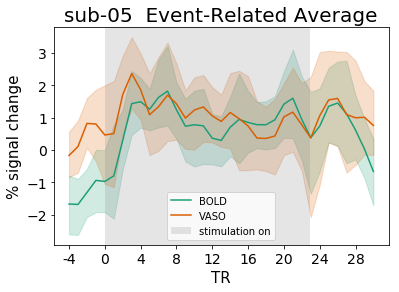

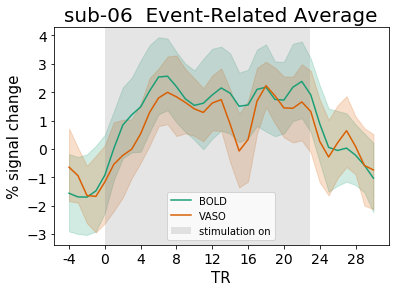

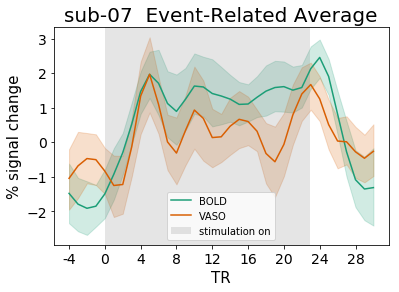

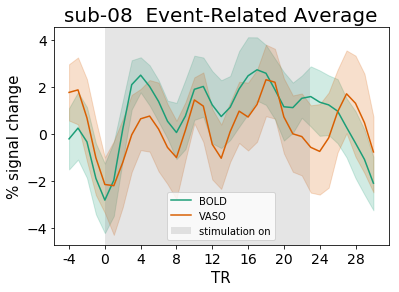

In [143]:
cmap = cm.get_cmap('Dark2')


for sub in subs:
    
    subData = blockData.loc[blockData['subject'] == sub]

    sns.lineplot(data=subData, x='x', y='data', hue='modality', palette='Dark2')



    plt.axvspan(4, 4+(30/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
    plt.ylabel('% signal change', fontsize=15)
    plt.xlabel('TR', fontsize=15)
    plt.title(f"{sub}  Event-Related Average", fontsize=20)
#     plt.title(f"{sub} Event-Related Average")
    plt.legend(loc='lower center')
    
    values = np.arange(-4,len(blockResults['sub-08']['sub-08_ses-001_task-blockStim_run-002']['BOLD']['trial 1'])-4,4)
    spacing = np.arange(0,len(blockResults['sub-08']['sub-08_ses-001_task-blockStim_run-002']['BOLD']['trial 1']),4)

    plt.xticks(spacing,values, fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(f'{root}/{sub}/ses-001/s1Focus/{sub}_blockResultsFromLayers.png')
    plt.show()

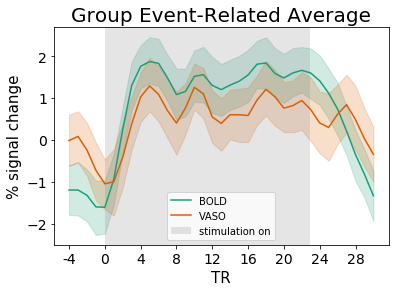

In [144]:
sns.lineplot(data=blockData, x='x', y='data', hue='modality', palette='Dark2')


plt.axvspan(4, 4+(30/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
plt.ylabel('% signal change', fontsize=15)
plt.xlabel('TR', fontsize=15)
plt.title(f"Group Event-Related Average", fontsize=20)
plt.legend(loc='lower center')


values = np.arange(-4,len(blockResults[sub][base][modality][trial])-4,4)
spacing = np.arange(0,len(blockResults[sub][base][modality][trial]),4)

plt.xticks(spacing,values, fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(f'{root}/Group_S1_blockResultsFromLayers.png')
plt.show()

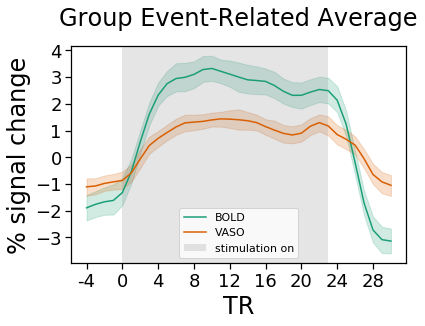

In [359]:
sns.lineplot(data=blockData, x='x', y='data', hue='modality', palette='Dark2')


plt.axvspan(4, 4+(30/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
plt.ylabel('% signal change', fontsize=24)
plt.xlabel('TR', fontsize=24)
plt.title(f"Group Event-Related Average", fontsize=24, pad=20)
plt.legend(loc='lower center')

values = np.arange(-4,len(blockResults['sub-08']['sub-08_ses-001_task-blockStim_run-002']['VASO']['trial 1'])-4,4)
spacing = np.arange(0,len(blockResults['sub-08']['sub-08_ses-001_task-blockStim_run-002']['VASO']['trial 1']),4)

plt.xticks(spacing,values, fontsize=18)
plt.yticks(fontsize=18)
plt.savefig(f'{root}/Group_S1_blockResultsFromLayers.png', bbox_inches='tight')
plt.show()

In [145]:

subs = ['sub-05', 'sub-06','sub-07', 'sub-08']
# subs = ['sub-05']
modalities = ['BOLD', 'VASO']

# eventResults = {}

for sub in subs:
    print(sub)
    eventResults[sub] = {}

    runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-event*_run-00*_cbv.nii.gz'))

    for run in runs:
            
        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        eventResults[sub][base] = {}
        
        
        for modality in modalities:
            eventResults[sub][base][modality] = {}
            
            print(f'processing {base}')

            run = f'{root}/{sub}/ses-001/s1Focus/{base}_{modality}_scaled_slice.nii.gz'
            mask = nb.load(f'{root}/{sub}/ses-001/s1Focus/{sub}_masks/{base}_3layers_layers_equidist_slice.nii.gz').get_fdata()

            Nii = nb.load(run)
            # As before, get the data as an array.
            data = Nii.get_fdata()[:,:,:,:-2]
            # load the nifty-header to get some meta-data.
            header = Nii.header

            # As the number of volumes which is the 4th position of
            # get_shape. This seems to be unused so I will comment it out to check.
            # nr_volumes = int(header.get_data_shape()[3])

            # Or the TR, which is the 4th position of get_zooms().
            tr = header.get_zooms()[3]

             # Get scan duration in s
            runTime = data.shape[-1]*tr

            events = pd.read_csv(f'{root}/{sub}/ses-001/events/{base}.txt', sep = ' ', names = ['start','duration','trialType'])

            # Load information on run-wise motion
            FDs = pd.read_csv(f'{root}/{sub}/ses-001/s1Focus/motionParameters/{sub}_FDs.csv')


            
            for i, row in events.iterrows():

                onset = round(row['start']/tr)
                # Do the same for the offset
                offset = round(onset + row['duration']/tr)
                
                # check whether trial is fully there
                if offset > data.shape[3]:
                    break
                    
                # Because we want the % signal-change, we need the mean
                # of the voxel we are looking at. This is done with
                # some fancy matrix operations.
                mask_mean = np.mean(data[:, :, :]
                                    [mask.astype(bool)])
                
                # truncate motion data to event
                tmp = FDs.loc[(FDs['volume']>=(onset-2)/2)&(FDs['volume']<=(offset+2)/2)&(FDs['run'].str.contains(f'blockStim_run-00{n}'))]

                if not (tmp['FD']>=2).any():
                    eventResults[sub][base][modality][f'trial {i}'] = np.mean((((data[:, :, :, int(onset-4):int(offset+ 8)][mask.astype(bool)]) / mask_mean)- 1) * 100,axis=0)

sub-05
processing sub-05_ses-001_task-eventStim_run-001
processing sub-05_ses-001_task-eventStim_run-001
processing sub-05_ses-001_task-eventStim_run-002
processing sub-05_ses-001_task-eventStim_run-002
sub-06
processing sub-06_ses-001_task-eventStim_run-001
processing sub-06_ses-001_task-eventStim_run-001
processing sub-06_ses-001_task-eventStim_run-002
processing sub-06_ses-001_task-eventStim_run-002
processing sub-06_ses-001_task-eventStim_run-003
processing sub-06_ses-001_task-eventStim_run-003
processing sub-06_ses-001_task-eventStim_run-004
processing sub-06_ses-001_task-eventStim_run-004
sub-07
processing sub-07_ses-001_task-eventStim_run-001
processing sub-07_ses-001_task-eventStim_run-001
processing sub-07_ses-001_task-eventStim_run-002
processing sub-07_ses-001_task-eventStim_run-002
processing sub-07_ses-001_task-eventStim_run-003
processing sub-07_ses-001_task-eventStim_run-003
processing sub-07_ses-001_task-eventStim_run-004
processing sub-07_ses-001_task-eventStim_run-004

In [146]:
## Event results created wih layers
subs = ['sub-05', 'sub-06','sub-07', 'sub-08']



subList = []
dataList = []
xList = []
modalityList = []
trialList = []
runList = []

for sub in subs:
    print(sub)

    runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-event*_run-00*_cbv.nii.gz'))

    for run in runs:
            
        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        
        
        for modality in modalities:
                       
            subTrials = []
            for key, value in eventResults[sub][base][modality].items():
                subTrials.append(key)

            for trial in subTrials[:-1]:
#                 print(trial)

                for n in range(len(eventResults[sub][base][modality][trial])):
 
                    if modality == "BOLD":
                        dataList.append(eventResults[sub][base][modality][trial][n])

                    if modality == "VASO":
                        dataList.append(-eventResults[sub][base][modality][trial][n])

                    modalityList.append(modality)
                    trialList.append(trial)
                    runList.append(run)
                    xList.append(n)
                    subList.append(sub)
        

eventData = pd.DataFrame({'subject': subList,'x':xList, 'data': dataList, 'modality': modalityList, 'trial': trialList, 'run':runList})

sub-05
sub-06
sub-07
sub-08


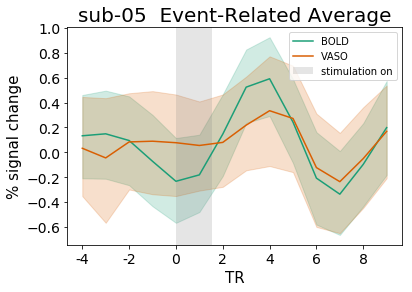

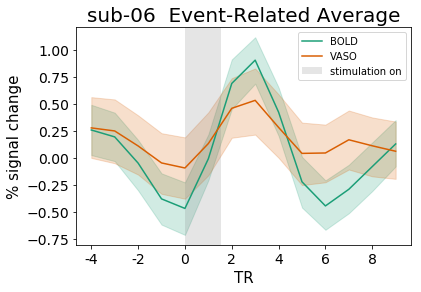

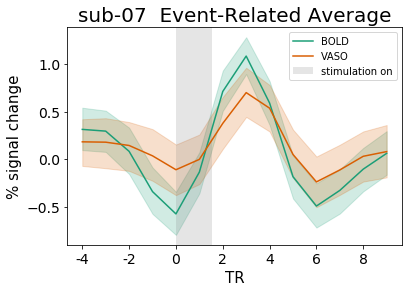

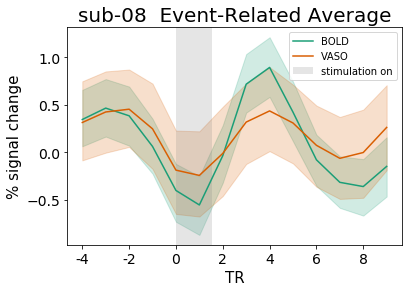

In [147]:
for sub in subs:
    
    subData = eventData.loc[eventData['subject'] == sub]

    sns.lineplot(data=subData, x='x', y='data', hue='modality', palette='Dark2')



    plt.axvspan(4, 4+(2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
    plt.ylabel('% signal change', fontsize=15)
    plt.xlabel('TR', fontsize=15)
    plt.title(f"{sub}  Event-Related Average", fontsize=20)
    plt.legend(loc='upper right')
    
    values = np.arange(-4,len(eventResults['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD']['trial 1'])-4,2)
    spacing = np.arange(0,len(eventResults['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD']['trial 1']),2)

    plt.xticks(spacing,values, fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(f'{root}/{sub}/ses-001/s1Focus/{sub}_eventResultsFromLayers.png')
    plt.show()

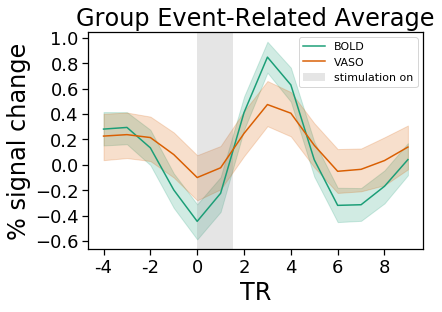

In [322]:
sns.lineplot(data=eventData, x='x', y='data', hue='modality', palette='Dark2')


plt.axvspan(4, 4+(2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
plt.ylabel('% signal change', fontsize=24)
plt.xlabel('TR', fontsize=24)
plt.title(f"Group Event-Related Average", fontsize=24, pad=20)
plt.legend(loc='upper right')

values = np.arange(-4,len(eventResults['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD']['trial 1'])-4,2)
spacing = np.arange(0,len(eventResults['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD']['trial 1']),2)

plt.xticks(spacing,values, fontsize=18)
plt.yticks(fontsize=18)
plt.savefig(f'{root}/GroupS1EventResultsFromLayers.png', bbox_inches = "tight")
plt.show()

In [ ]:
from matplotlib.ticker import MaxNLocator

# for focus in ['v1Focus', 's1Focus']:
for modality in ['VASO', 'BOLD_intemp']:
    fig, ax = plt.subplots()
    tmp = zscores.loc[(zscores['modality']==modality)&(zscores['focus']=='s1Focus')]

    sns.lineplot(data=tmp, x='layer', y='data', hue='stimType',palette='Dark2')


    plt.ylabel('z-score', fontsize=24)
    
    plt.title(f"{modality[:4]} z-scores across layers", fontsize=24)
    plt.xlabel('WM                                CSF', fontsize=24)
    plt.xticks([])
    

    plt.yticks(fontsize=18)

    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.legend(loc='upper left')
    
    
    plt.savefig(f'{root}/Group_S1_{modality}_zScoreProfile.png', bbox_inches = "tight")
    plt.show()

In [ ]:
root = '/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives'

subs = ['sub-05', 'sub-06','sub-07','sub-08']
# subs = ['sub-05']

# subs = ['sub-08']
modalities = ['BOLD', 'VASO']

eventResults = {}

singleEventResults = {}

for sub in subs:
    print(sub)
    eventResults[sub] = {}
    singleEventResults[sub] = {}
    
    runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-eventStim_run-00*_cbv.nii.gz'))

    for run in runs:
            
        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        print(base)
        singleEventResults[sub][base] = {}
        
        mask = nb.load(f'{root}/{sub}/ses-001/s1Focus/{sub}_masks/{base}_3layers_layers_equidist_slice.nii.gz').get_fdata()
    
        idx_layers = np.unique(mask.astype("int"))
        idx_layers = idx_layers[1:]

        for modality in modalities:
            print(modality)
            singleEventResults[sub][base][modality] = {}

            skippedTrials = 0


            run = f'{root}/{sub}/ses-001/s1Focus/{base}_{modality}_scaled_slice.nii.gz'

            Nii = nb.load(run)
            # As before, get the data as an array.
            data = Nii.get_fdata()[:,:,:,:-2]
            # load the nifty-header to get some meta-data.
            header = Nii.header

            # As the number of volumes which is the 4th position of
            # get_shape. This seems to be unused so I will comment it out to check.
            # nr_volumes = int(header.get_data_shape()[3])

            # Or the TR, which is the 4th position of get_zooms().
            tr = header.get_zooms()[3]

             # Get scan duration in s
            runTime = data.shape[-1]*tr

            events = pd.read_csv(f'{root}/{sub}/ses-001/events/{base}.txt', sep = ' ', names = ['start','duration','trialType'])[:-1]

            # Load information on run-wise motion
            FDs = pd.read_csv(f'{root}/{sub}/ses-001/s1Focus/motionParameters/{sub}_FDs.csv')

            # Because we want the % signal-change, we need the mean
            # of the voxel we are looking at. This is done with
            # some fancy matrix operations.

            for j in idx_layers:  # Compute bin averages

                singleEventResults[sub][base][modality][f'layer {j}'] = {}

                layerRoi = mask == j



                mask_mean = np.mean(data[:, :, :]
                                    [layerRoi.astype(bool)])

                includedTrials = []

                for i, row in events.iterrows():


                    onset = round(row['start']/tr)
                    # Do the same for the offset
                    offset = round(onset + row['duration']/tr)


                    # truncate motion data to event
                    tmp = FDs.loc[(FDs['volume']>=(onset-2)/2)&(FDs['volume']<=(offset+2)/2)&(FDs['run'].str.contains(f'{base}[-17:]'))]


                    if not (tmp['FD']>=2).any():

                        singleEventResults[sub][base][modality][f'layer {j}'][f'trial {i}'] = np.mean((((data[:, :, :, int(onset-4):int(offset+ 8)][layerRoi.astype(bool)]) / mask_mean)- 1) * 100,axis=0)
                        includedTrials.append(f'trial {i}')



In [ ]:
subList = []
dataList = []
xList = []
modalityList = []
trialList = []
runList = []
layerList = []

layers = {'1':'deep','2':'middle','3':'superficial'}

# subs = ['sub-05']

for sub in subs:
    print(sub)
    runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-event*_run-00*_cbv.nii.gz'))

    for run in runs:
            
        base = os.path.basename(run).rsplit('.', 2)[0][:-4]
        print(base)
        
        for modality in modalities:
            print(modality)
            
            for j in range(1, 4):
        
                subTrials = []
                for key, value in singleEventResults[sub][base][modality][f'layer {j}'].items():
                    subTrials.append(key)

                for trial in subTrials[:-1]:

                    for n in range(len(singleEventResults[sub][base][modality][f'layer {j}'][trial])):

                        if modality == "BOLD":
                            dataList.append(singleEventResults[sub][base][modality][f'layer {j}'][trial][n])

                        if modality == "VASO":
                            dataList.append(-singleEventResults[sub][base][modality][f'layer {j}'][trial][n])

                        modalityList.append(modality)
                        trialList.append(trial)
                        runList.append(base)
                        xList.append(n)
                        subList.append(sub)
                        layerList.append(layers[str(j)])
#                         layerList.append(j)
        

eventData = pd.DataFrame({'subject': subList,'x':xList, 'data': dataList, 'modality': modalityList, 'trial': trialList, 'run':runList, 'layer':layerList})

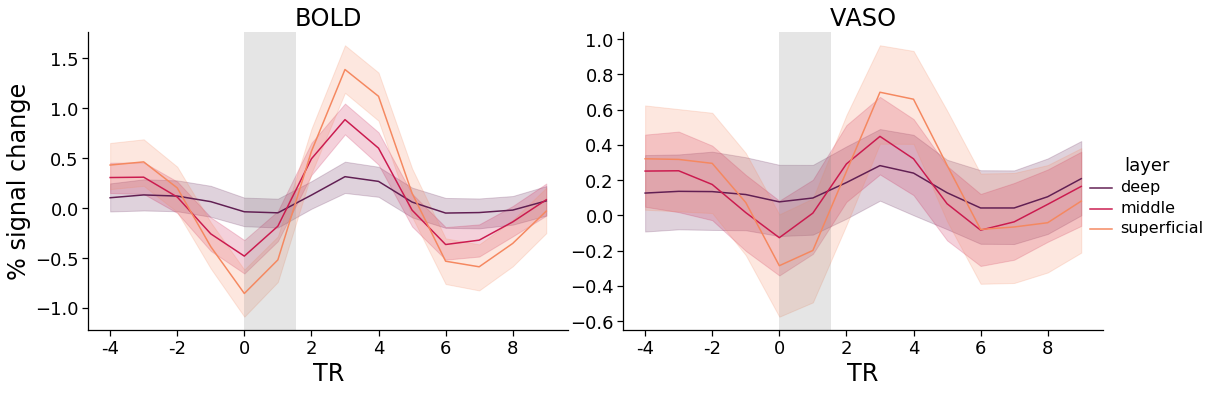

In [336]:
g = sns.FacetGrid(eventData, col="modality", hue="layer", sharey=False, height= 5, aspect = 1.5,palette='rocket')
g.map_dataframe(sns.lineplot, x="x", y="data")
g.add_legend()
g.axes[0,0].set_ylabel('% signal change', fontsize=24)

g.axes[0,1].set_xlabel('TR', fontsize=24)
g.axes[0,0].set_xlabel('TR', fontsize=24)


g.axes[0,1].set_title('VASO', fontsize=24)
g.axes[0,0].set_title('BOLD', fontsize=24)


g.axes[0,0].axvspan(4, 4 + (2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
g.axes[0,1].axvspan(4, 4 + (2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')


plt.setp(g._legend.get_title(), fontsize=18)
plt.setp(g._legend.get_texts(), fontsize=16)



values = np.arange(-4,len(singleEventResults['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD'][f'layer {3}']['trial 1'])-4,2)
spacing = np.arange(0,len(singleEventResults['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD'][f'layer {3}']['trial 1']),2)

g.axes[0,0].set_xticks(spacing)

g.axes[0,0].set_xticklabels(values,fontsize=18)
g.axes[0,1].set_xticklabels(values,fontsize=18)


plt.setp(g.axes[0,0].get_yticklabels(), fontsize=18)
plt.setp(g.axes[0,1].get_yticklabels(), fontsize=18)




g.savefig("/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/eventResultsS1LayersModalityVsLayers.png")

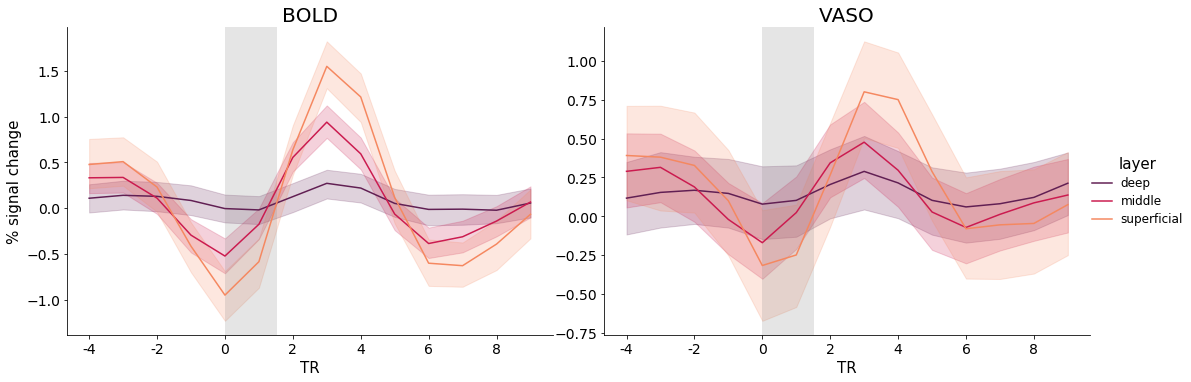

In [138]:
eventDataMunisSub = eventData.loc[eventData['subject']!='sub-05']

g = sns.FacetGrid(eventDataMunisSub, col="modality", hue="layer", sharey=False, height= 5, aspect = 1.5,palette='rocket')
g.map_dataframe(sns.lineplot, x="x", y="data")
g.add_legend()
g.axes[0,0].set_ylabel('% signal change', fontsize=15)

g.axes[0,1].set_xlabel('TR', fontsize=15)
g.axes[0,0].set_xlabel('TR', fontsize=15)


g.axes[0,1].set_title('VASO', fontsize=20)
g.axes[0,0].set_title('BOLD', fontsize=20)


g.axes[0,0].axvspan(4, 4 + (2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
g.axes[0,1].axvspan(4, 4 + (2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')


plt.setp(g._legend.get_title(), fontsize=15)
plt.setp(g._legend.get_texts(), fontsize=12)



values = np.arange(-4,len(singleEventResults['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD'][f'layer {3}']['trial 1'])-4,2)
spacing = np.arange(0,len(singleEventResults['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD'][f'layer {3}']['trial 1']),2)

g.axes[0,0].set_xticks(spacing)

g.axes[0,0].set_xticklabels(values,fontsize=14)
g.axes[0,1].set_xticklabels(values,fontsize=14)


plt.setp(g.axes[0,0].get_yticklabels(), fontsize=14)
plt.setp(g.axes[0,1].get_yticklabels(), fontsize=14)




g.savefig("/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/eventResultsS1LayersModalityVsLayersMinusSub-05.png")

In [ ]:
for sub in subs:
    tmp = eventData.loc[eventData['subject']==sub]
    g = sns.FacetGrid(tmp, col="modality", hue="layer", sharey=False, height= 5, aspect = 1.5)
    g.map_dataframe(sns.lineplot, x="x", y="data")
    g.add_legend()
    g.axes[0,0].set_ylabel('% signal change', fontsize=15)

    g.axes[0,1].set_xlabel('TR', fontsize=15)
    g.axes[0,0].set_xlabel('TR', fontsize=15)


    g.axes[0,1].set_title('VASO', fontsize=20)
    g.axes[0,0].set_title('BOLD', fontsize=20)


    g.axes[0,0].axvspan(4, 4 + (2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
    g.axes[0,1].axvspan(4, 4 + (2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')


    plt.setp(g._legend.get_title(), fontsize=15)
    plt.setp(g._legend.get_texts(), fontsize=12)
    plt.suptitle(sub)

    g.savefig(f"{root}/{sub}_eventResultsS1LayersModalityVsLayers.png")

In [218]:
subList = []
dataList = []
modalityList = []
layerList = []
stimTypeList = []
focusList = []

# layers = {'1':'deep','2':'middle','3':'superficial'}

# subs = ['sub-06']
subs = ['sub-05', 'sub-06', 'sub-07', 'sub-08']

# for focus in ['s1Focus']:
for focus in ['v1Focus', 's1Focus']:

    for sub in subs:
        for stimType in ['blockStim', 'eventStim']:

            runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-{stimType}_run-00*_cbv.nii.gz'))

            for run in runs:

                base = os.path.basename(run).rsplit('.', 2)[0][:-4]
                print(base)
                mask = nb.load(f'{root}/{sub}/ses-001/{focus}/{sub}_masks/{base}_11layers_layers_equidist.nii').get_fdata()

                

                    
                for modality in ['BOLD_intemp','VASO']:
                    data = nb.load(f'{root}/{sub}/ses-001/{focus}/{base}_{modality}.feat/stats/zstat1_scaled.nii.gz').get_fdata()

                    for j in range(1,12):  # Compute bin averages
                        layerRoi = mask == j
                        mask_mean = np.mean(data[layerRoi.astype(bool)])

                        subList.append(sub)
                        dataList.append(mask_mean)
                        modalityList.append(modality)
                        layerList.append(j)
                        stimTypeList.append(stimType)
                        focusList.append(focus)

            
zscores = pd.DataFrame({'subject': subList, 'data': dataList, 'modality': modalityList, 'layer':layerList, 'stimType':stimTypeList, 'focus':focusList})

sub-05_ses-001_task-blockStim_run-001
sub-05_ses-001_task-blockStim_run-002
sub-05_ses-001_task-eventStim_run-001
sub-05_ses-001_task-eventStim_run-002
sub-06_ses-001_task-blockStim_run-001
sub-06_ses-001_task-blockStim_run-002
sub-06_ses-001_task-eventStim_run-001
sub-06_ses-001_task-eventStim_run-002
sub-06_ses-001_task-eventStim_run-003
sub-06_ses-001_task-eventStim_run-004
sub-07_ses-001_task-blockStim_run-001
sub-07_ses-001_task-blockStim_run-002
sub-07_ses-001_task-eventStim_run-001
sub-07_ses-001_task-eventStim_run-002
sub-07_ses-001_task-eventStim_run-003
sub-07_ses-001_task-eventStim_run-004
sub-08_ses-001_task-blockStim_run-001
sub-08_ses-001_task-blockStim_run-002
sub-08_ses-001_task-eventStim_run-001
sub-08_ses-001_task-eventStim_run-002
sub-08_ses-001_task-eventStim_run-003
sub-08_ses-001_task-eventStim_run-004
sub-05_ses-001_task-blockStim_run-001
sub-05_ses-001_task-blockStim_run-002
sub-05_ses-001_task-eventStim_run-001
sub-05_ses-001_task-eventStim_run-002
sub-06_ses-0

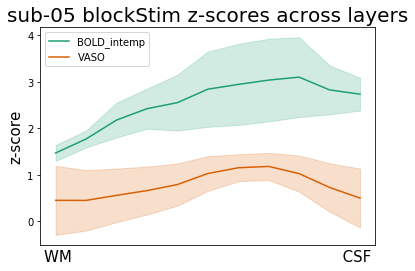

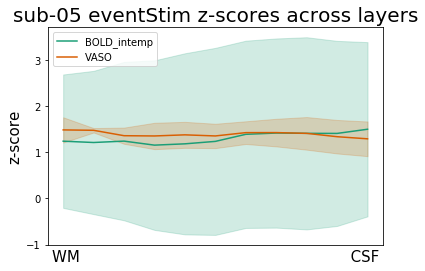

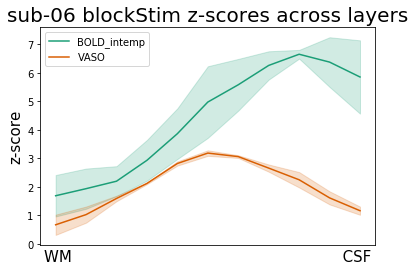

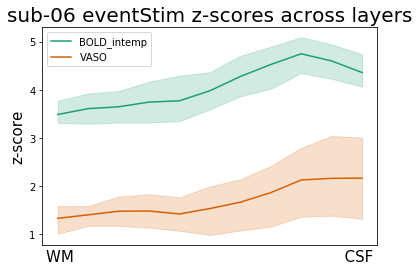

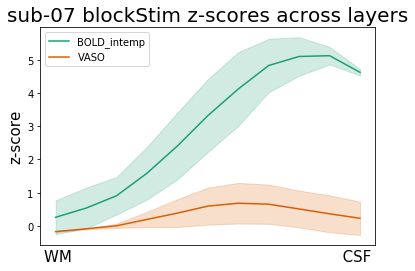

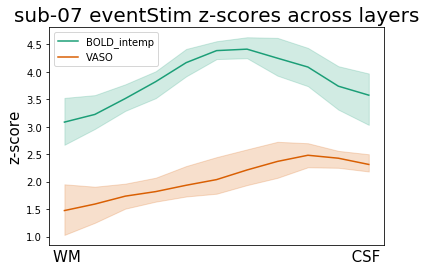

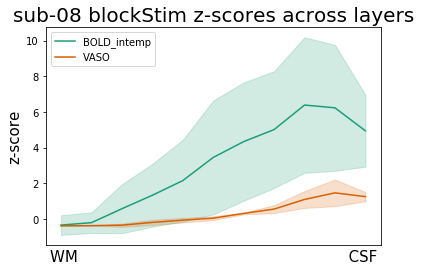

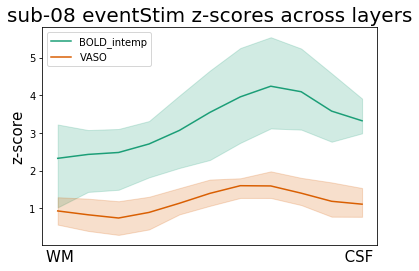

In [219]:
for sub in subs:
    for stimType in ['blockStim', 'eventStim']:

        tmp = zscores.loc[(zscores['stimType']==stimType)&(zscores['focus']=='s1Focus')&(zscores['subject']==sub)]

        sns.lineplot(data=tmp, x='layer', y='data', hue='modality',palette='Dark2')


        plt.ylabel('z-score', fontsize=15)
        plt.xlabel('cortical depth', fontsize=15)
        plt.title(f"{sub} {stimType} z-scores across layers", fontsize=20)
        plt.xlabel('WM                                                         CSF')
        plt.xticks([])
        plt.legend(loc='upper left')
        plt.savefig(f'{root}/{sub}_S1_{stimType}_zScoreProfile.png')
        plt.show()

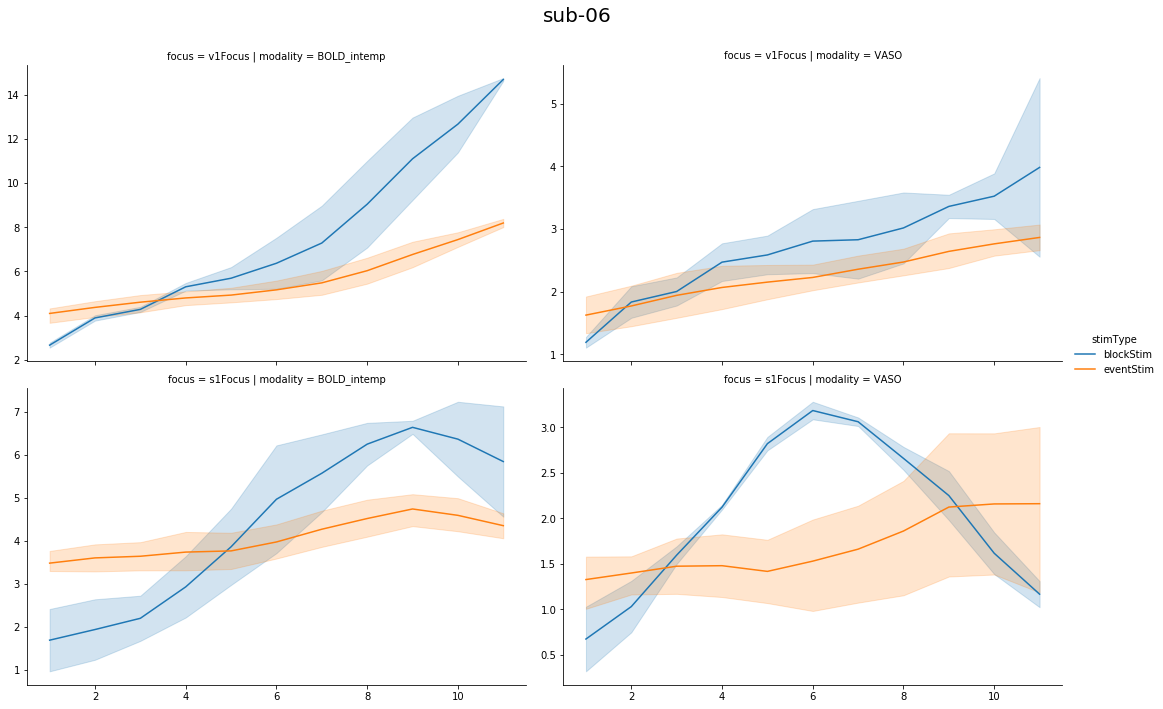

In [276]:
for sub in ['sub-06']:
    
    tmp = zscores.loc[zscores['subject']==sub]
    g = sns.FacetGrid(tmp, col="modality",row='focus', hue="stimType", sharey=False, height= 5, aspect = 1.5)
    g.map_dataframe(sns.lineplot, x="layer", y="data")
    g.add_legend()
#     g.set_titles('col_name','test','test2','testtt')
    g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
    g.fig.suptitle(sub, fontsize=20)

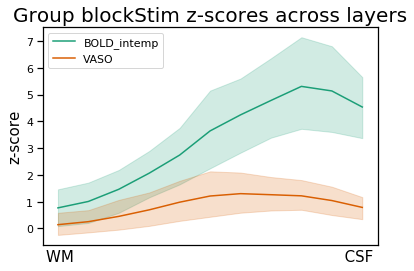

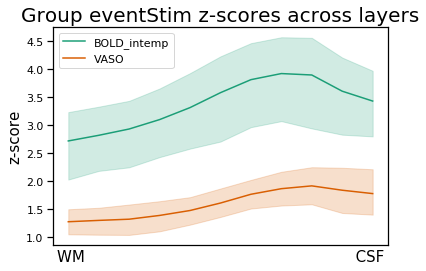

In [315]:
# for focus in ['v1Focus', 's1Focus']:
for stimType in ['blockStim', 'eventStim']:

    tmp = zscores.loc[(zscores['stimType']==stimType)&(zscores['focus']=='s1Focus')]

    sns.lineplot(data=tmp, x='layer', y='data', hue='modality',palette='Dark2')


    plt.ylabel('z-score', fontsize=15)
    plt.xlabel('cortical depth', fontsize=15)
    plt.title(f"{stimType} z-scores across layers", fontsize=20, pad=20)
    plt.xlabel('WM                                                         CSF')
    plt.xticks([])
    plt.legend(loc='upper left')
    plt.savefig(f'{root}/Group_S1_{stimType}_zScoreProfile.png')
    plt.show()

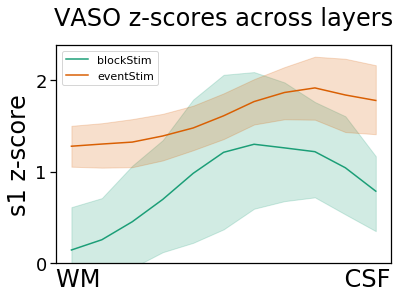

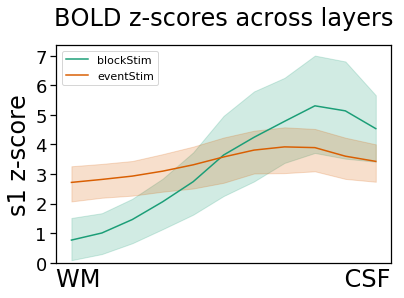

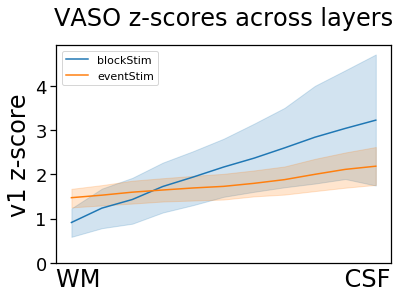

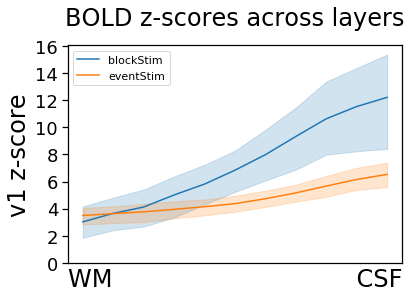

In [585]:
from matplotlib.ticker import MaxNLocator

for focus, cmap in zip(['s1Focus', 'v1Focus'],['Dark2', 'tab10']):
    for modality in ['VASO', 'BOLD_intemp']:
        fig, ax = plt.subplots()
        tmp = zscores.loc[(zscores['modality']==modality)&(zscores['focus']==focus)]

        sns.lineplot(data=tmp, x='layer', y='data', hue='stimType',palette=cmap)


        plt.ylabel(f'{focus[:2]} z-score', fontsize=24)

        plt.title(f"{modality[:4]} z-scores across layers", fontsize=24, pad=20)
        plt.xlabel('WM                                CSF', fontsize=24)
        plt.xticks([])


        plt.yticks(fontsize=18)

        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        plt.legend(loc='upper left')
        
        yLimits = ax.get_ylim()
        plt.ylim(0,yLimits[1])

        plt.savefig(f'{root}/Group_{focus}_{modality}_zScoreProfile.png', bbox_inches = "tight")
        plt.show()

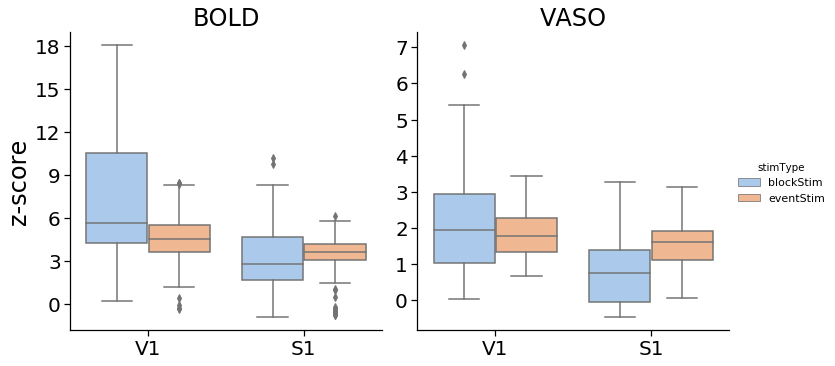

In [615]:
g = sns.catplot(x="focus", y="data",
                hue="stimType", col="modality",
                data=zscores, kind="box", sharey=False, palette='pastel')

    
    
g.axes[0,0].set_ylabel('z-score', fontsize=24)

g.axes[0,0].set_xlabel('', fontsize=24)
g.axes[0,1].set_xlabel('', fontsize=24)


g.axes[0,1].set_title('VASO', fontsize=24)
g.axes[0,0].set_title('BOLD', fontsize=24)

g.axes[0,0].set_xticklabels(['V1', 'S1'], fontsize=20)
g.axes[0,1].set_xticklabels(['V1', 'S1'], fontsize=20)

plt.setp(g.axes[0,0].get_yticklabels(), fontsize=20)
plt.setp(g.axes[0,1].get_yticklabels(), fontsize=20)

g.axes[0,0].yaxis.set_major_locator(MaxNLocator(integer=True))

g.savefig("/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/comparingZscoresBoxPlt.png")

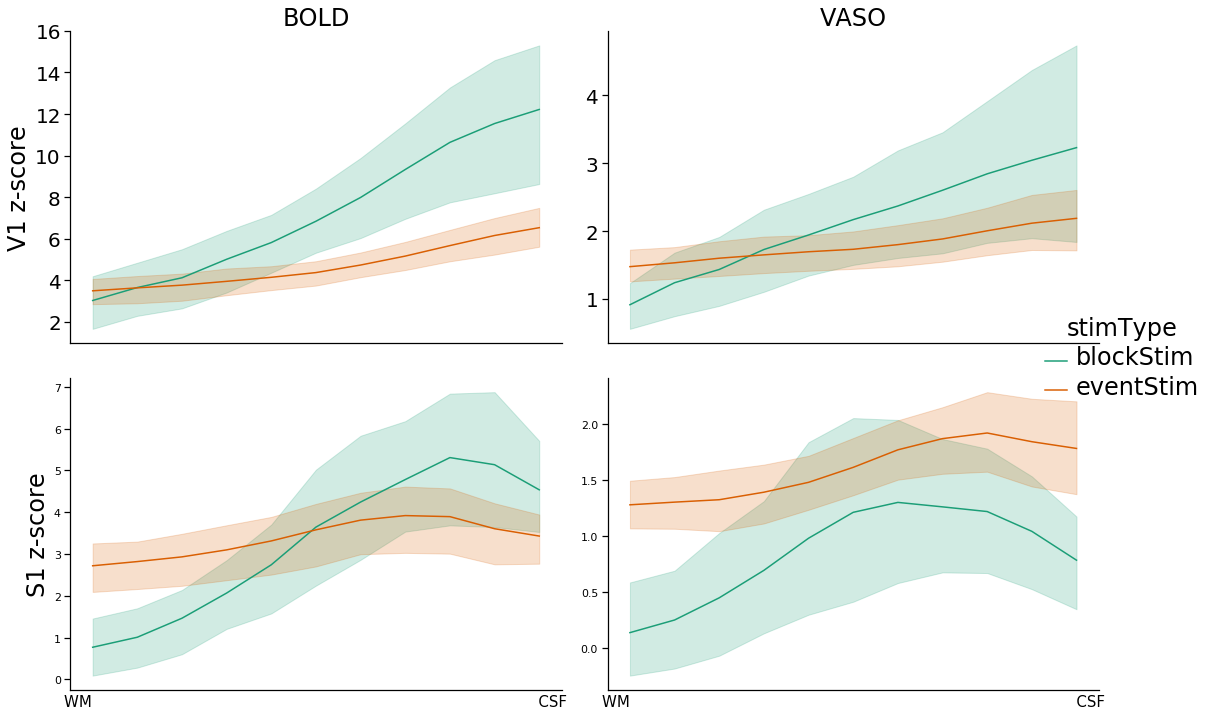

In [399]:
g = sns.FacetGrid(zscores, col="modality", row='focus', hue="stimType", sharey=False, height= 5, aspect = 1.5,palette='Dark2')
g.map_dataframe(sns.lineplot, x="layer", y="data")
g.add_legend()


g.axes[0,0].set_ylabel('V1 z-score', fontsize=24)
g.axes[1,0].set_ylabel('S1 z-score', fontsize=24)


g.axes[0,1].set_title('VASO', fontsize=24)
g.axes[0,0].set_title('BOLD', fontsize=24)

g.axes[1,1].set_title('', fontsize=24)
g.axes[1,0].set_title('', fontsize=24)

plt.setp(g._legend.get_title(), fontsize=24)
plt.setp(g._legend.get_texts(), fontsize=24)
g.axes[1,0].set_xlabel('WM                                                                                              CSF', fontsize = 15)
g.axes[1,0].set_xticks([])
g.axes[1,1].set_xlabel('WM                                                                                              CSF', fontsize = 15)
g.axes[1,1].set_xticks([])


g.axes[0,0].set_xticklabels(values,fontsize=20)
g.axes[0,1].set_xticklabels(values,fontsize=20)


plt.setp(g.axes[0,0].get_yticklabels(), fontsize=20)
plt.setp(g.axes[0,1].get_yticklabels(), fontsize=20)




g.savefig("/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/comparingZscores.png")

### extract betas

In [256]:
subList = []
dataList = []
modalityList = []
layerList = []
stimTypeList = []
focusList = []
baseList = []

# layers = {'1':'deep','2':'middle','3':'superficial'}

# subs = ['sub-08']
subs = ['sub-05', 'sub-06', 'sub-07', 'sub-08']

for focus in ['v1Focus', 's1Focus']:
# for focus in ['s1Focus']:
    for sub in subs:
#         for stimType in ['eventStim']:
#         for stimType in ['blockStim']:
        for stimType in ['blockStim', 'eventStim']:

            runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-{stimType}_run-00*_cbv.nii.gz'))

            for run in runs:

                base = os.path.basename(run).rsplit('.', 2)[0][:-4]
                print(base)
                mask = nb.load(f'{root}/{sub}/ses-001/{focus}/{sub}_masks/{base}_11layers_layers_equidist.nii').get_fdata()

                for modality in ['BOLD_intemp','VASO']:
                    data = nb.load(f'{root}/{sub}/ses-001/{focus}/{base}_{modality}.feat/stats/pe1_scaled.nii.gz').get_fdata()

                    for j in range(1,12):  # Compute bin averages
                        layerRoi = mask == j
                        mask_mean = np.mean(data[layerRoi.astype(bool)])

                        subList.append(sub)
                        if modality == 'VASO':
                            dataList.append(-mask_mean)
                        if modality == 'BOLD_intemp':
                            dataList.append(mask_mean)
                        modalityList.append(modality)
                        layerList.append(j)
                        stimTypeList.append(stimType)
                        focusList.append(focus)
                        baseList.append(base)



            
betaScores = pd.DataFrame({'subject': subList, 'data': dataList, 'modality': modalityList, 'layer':layerList, 'stimType':stimTypeList, 'focus':focusList, 'run':baseList})

sub-05_ses-001_task-blockStim_run-001
sub-05_ses-001_task-blockStim_run-002
sub-05_ses-001_task-eventStim_run-001
sub-05_ses-001_task-eventStim_run-002
sub-06_ses-001_task-blockStim_run-001
sub-06_ses-001_task-blockStim_run-002
sub-06_ses-001_task-eventStim_run-001
sub-06_ses-001_task-eventStim_run-002
sub-06_ses-001_task-eventStim_run-003
sub-06_ses-001_task-eventStim_run-004
sub-07_ses-001_task-blockStim_run-001
sub-07_ses-001_task-blockStim_run-002
sub-07_ses-001_task-eventStim_run-001
sub-07_ses-001_task-eventStim_run-002
sub-07_ses-001_task-eventStim_run-003
sub-07_ses-001_task-eventStim_run-004
sub-08_ses-001_task-blockStim_run-001
sub-08_ses-001_task-blockStim_run-002
sub-08_ses-001_task-eventStim_run-001
sub-08_ses-001_task-eventStim_run-002
sub-08_ses-001_task-eventStim_run-003
sub-08_ses-001_task-eventStim_run-004
sub-05_ses-001_task-blockStim_run-001
sub-05_ses-001_task-blockStim_run-002
sub-05_ses-001_task-eventStim_run-001
sub-05_ses-001_task-eventStim_run-002
sub-06_ses-0

In [190]:
subList = []
dataList = []
modalityList = []
layerList = []
stimTypeList = []
focusList = []
baseList = []

# layers = {'1':'deep','2':'middle','3':'superficial'}

subs = ['sub-06']
# subs = ['sub-05', 'sub-06', 'sub-07', 'sub-08']

# for focus in ['v1Focus', 's1Focus']:
for focus in ['s1Focus']:
    for sub in subs:
        for stimType in ['eventStim']:
#         for stimType in ['blockStim']:
#         for stimType in ['blockStim', 'eventStim']:

            runs = sorted(glob.glob(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/{sub}/ses-001/func/{sub}_ses-001_task-{stimType}_run-001_cbv.nii.gz'))

            for run in runs:

                base = os.path.basename(run).rsplit('.', 2)[0][:-4]
                print(base)
                mask = nb.load(f'{root}/{sub}/ses-001/{focus}/test_mask_event.nii.gz').get_fdata()

                for modality in ['BOLD_intemp','VASO']:
                    data = nb.load(f'{root}/{sub}/ses-001/{focus}/{base}_{modality}.feat/stats/cope1.nii.gz').get_fdata()

#                     for j in range(1,12):  # Compute bin averages
#                         layerRoi = mask == j
                    mask_mean = np.mean(data[mask.astype(bool)])

                    subList.append(sub)
                    dataList.append(mask_mean)
                    modalityList.append(modality)
#                     layerList.append(j)
                    stimTypeList.append(stimType)
                    focusList.append(focus)
                    baseList.append(base)



            
eventbetaScores = pd.DataFrame({'subject': subList, 'data': dataList, 'modality': modalityList, 'stimType':stimTypeList, 'focus':focusList, 'run':baseList})

sub-06_ses-001_task-eventStim_run-001


In [191]:
eventtmp = eventbetaScores.loc[(eventbetaScores['run']=='sub-06_ses-001_task-eventStim_run-001')]
sns.lineplot(data=eventtmp, x='layer', y='data', hue='modality',palette='Dark2')

ValueError: Could not interpret value `layer` for parameter `x`

In [194]:
meanBOLDevent = (np.mean(eventtmp['data'].loc[eventtmp['modality']=='BOLD_intemp']))
meanBOLDevent

1204.733142609292

In [195]:
meanVASOevent = (np.mean(eventtmp['data'].loc[eventtmp['modality']=='VASO']))
meanVASOevent

214.4499222775723

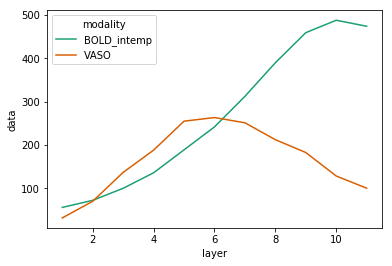

In [252]:
tmp = betaScores.loc[(betaScores['run']=='sub-06_ses-001_task-blockStim_run-001')]
sns.lineplot(data=tmp, x='layer', y='data', hue='modality',palette='Dark2')

In [180]:
meanBOLD = (np.mean(tmp['data'].loc[tmp['modality']=='BOLD_intemp']))*100
meanBOLD

3.12183339300953

In [181]:
meanVASO = (np.mean(tmp['data'].loc[tmp['modality']=='VASO']))*100
meanVASO

2.1279848107097132

In [ ]:
# for focus in ['v1Focus', 's1Focus']:
for stimType in ['blockStim', 'eventStim']:
    
    tmp = betaScores.loc[(betaScores['stimType']==stimType)]

    sns.lineplot(data=tmp, x='layer', y='data', hue='modality',palette='Dark2')


    plt.ylabel('Parameter Estimate', fontsize=15)
    plt.xlabel('cortical depth', fontsize=15)
    plt.title(f"Group {stimType} PEs across layers", fontsize=20)
    plt.xlabel('WM                                                         CSF')
    plt.xticks([])
    plt.legend(loc='upper left')
    plt.savefig(f'{root}/Group_S1_{stimType}_PEsProfile.png')
    plt.show()

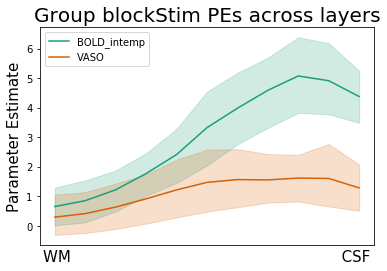

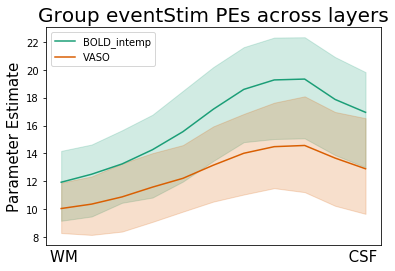

In [254]:
# for focus in ['v1Focus', 's1Focus']:
for stimType in ['blockStim', 'eventStim']:

    tmp = betaScores.loc[(betaScores['stimType']==stimType)]

    sns.lineplot(data=tmp, x='layer', y='data', hue='modality',palette='Dark2')


    plt.ylabel('Parameter Estimate', fontsize=15)
    plt.xlabel('cortical depth', fontsize=15)
    plt.title(f"Group {stimType} PEs across layers", fontsize=20)
    plt.xlabel('WM                                                         CSF')
    plt.xticks([])
    plt.legend(loc='upper left')
    plt.savefig(f'{root}/Group_S1_{stimType}_PEsProfile.png')
    plt.show()

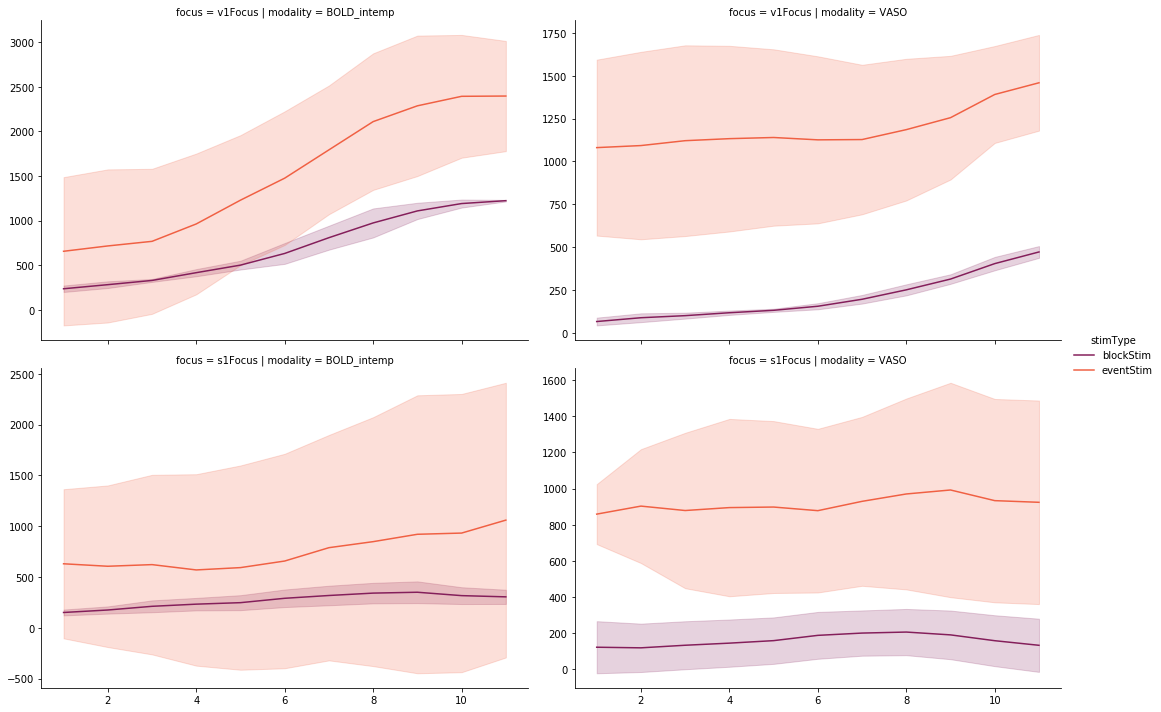

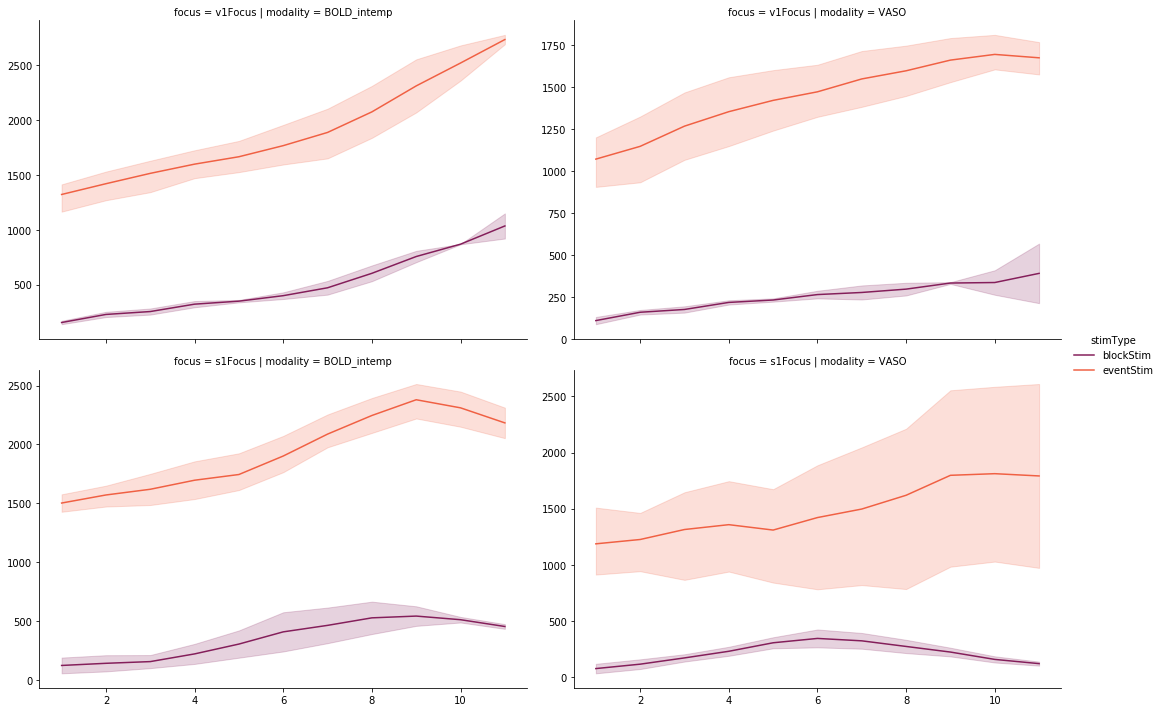

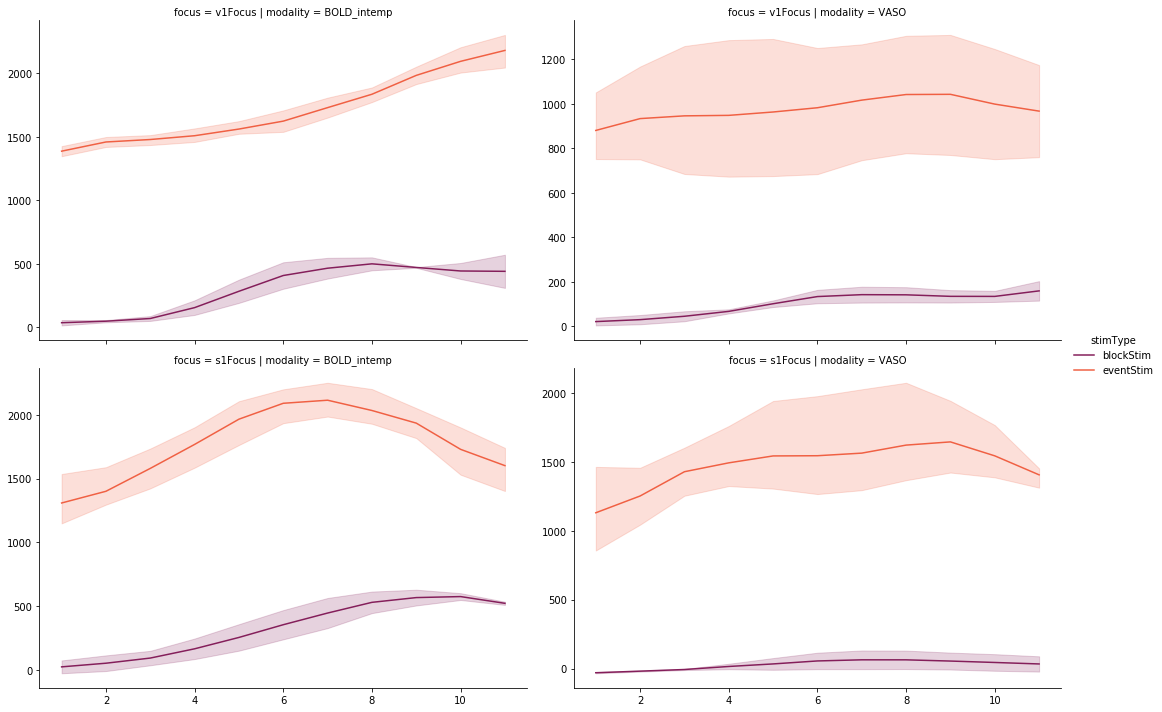

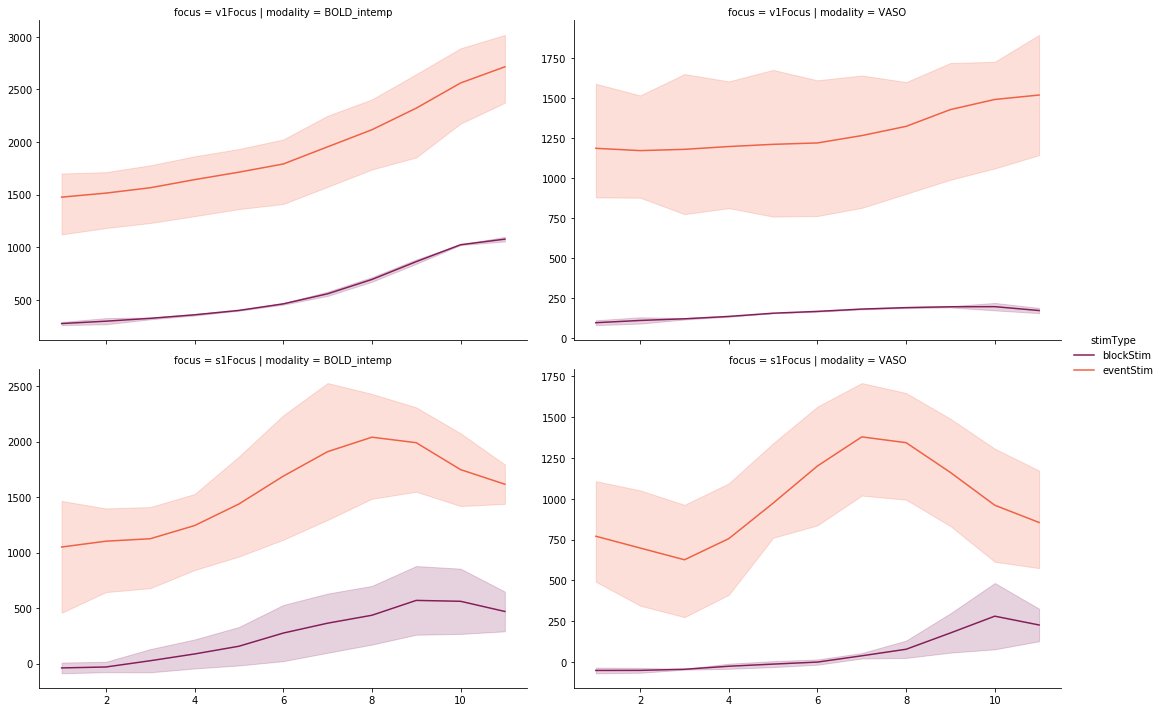

In [262]:
for sub in subs:
    tmp = betaScores.loc[betaScores['subject']==sub]
    g = sns.FacetGrid(tmp, col="modality",row='focus', hue="stimType", sharey=False, height= 5, aspect = 1.5,palette='rocket')
    g.map_dataframe(sns.lineplot, x="layer", y="data")
    g.add_legend()

In [ ]:
from random import seed
from random import choice


import nibabel as nb
import numpy as np
import imageio
import scipy
from scipy import ndimage
import os

cmap = cm.get_cmap('Dark2')
folder = '/home/sebastian/Desktop/test/s1Focus'


seed(1)

for sub in subs:
    

    subTrials = []
    for key, value in singleEventResults[sub]['BOLD_intemp']['run 1'].items():
        subTrials.append(key)


    includedTrials = []

    for n in range(40):
        fig = plt.figure()

        # choose a random trial
        selection = choice(subTrials)
        # remove that trial from the list of possible trials
        subTrials.remove(selection)

        includedTrials.append(selection)

        tmpBOLD = singleEventResults[sub]['BOLD_intemp']['run 1'][includedTrials[0]]
        tmpVASO = singleEventResults[sub]['VASO_LN']['run 1'][includedTrials[0]]

        for trial in range(0,len(includedTrials)):
                tmpBOLD = np.vstack((tmpBOLD, singleEventResults[sub]['BOLD_intemp']['run 1'][includedTrials[trial]]))
                tmpVASO = np.vstack((tmpVASO, singleEventResults[sub]['VASO_LN']['run 1'][includedTrials[trial]]))


        tmpVASO = np.mean(tmpVASO, axis=0)
        tmpBOLD = np.mean(tmpBOLD, axis=0)



        plt.plot(tmpBOLD, label = 'BOLD', color=cmap.colors[0])
        plt.plot(-tmpVASO, label = 'absolute VASO', color=cmap.colors[1])
        plt.axvspan(4, len(singleEventResults[sub]['BOLD_intemp']['run 1'][f'trial 1'])-8, color='grey', alpha=0.2, lw=0, label = 'stimulation on')
        plt.ylabel('% signal change')
        plt.xlabel('TR')
        plt.ylim(-1.5,1.5) 
        plt.title(f"{sub} Average of {n+1} trials")
        plt.savefig(f'{folder}/{sub}_eventRelatedAveragesOf{str(n+1).zfill(2)}Trials.png')
        plt.show()


In [ ]:
import nibabel as nb
import numpy as np
import imageio
import scipy
from scipy import ndimage
import os


for sub in subs:
    

    files = sorted(glob.glob(f'{folder}/{sub}*Trials.png'))
    images = []
    for file in files:
        images.append(imageio.imread(file))


    imageio.mimsave(f'{folder}/{sub}_movie.gif', images, duration = 1/0.75)
    
    
import os
[os.remove(f'{folder}/{file}') for file in os.listdir(folder) if file.endswith('.png')]


In [ ]:
cmap = cm.get_cmap('Dark2')

for sub in subs:
    

    plt.plot(singleEventResults[sub]['BOLD_intemp']['average'], label = 'BOLD', color=cmap.colors[0])
    plt.plot(-singleEventResults[sub]['VASO_LN']['average'], label = 'absolute VASO', color=cmap.colors[1])
    # plt.axvline(4, 0,2.8, color = 'r', label= f"stim onset")
    # plt.axvline(6, 0,2.8, color = 'g', label= f"stim offset")

    plt.axvspan(4, len(singleEventResults[sub]['BOLD_intemp']['average'])-8, color='grey', alpha=0.2, lw=0, label = 'stimulation on')
    plt.ylabel('% signal change')
    plt.xlabel('TR')
    plt.title(f"{sub} Event-Related Average S1")
    plt.legend()
    plt.savefig(root + f'/derivatives/{sub}/ses-001/s1Focus/mocoToEachRun/trunc/{sub}_eventResultsS1.png')
    plt.show()

In [ ]:
subList = []
dataList = []
xList = []
modalityList = []

for sub in subs:

    for modality in modalities:
        
        for n in range(len(singleEventResults[sub][modality]['average'])):
            
            xList.append(n)
            subList.append(sub)
            if modality == "BOLD_intemp":
                dataList.append(singleEventResults[sub][modality]['average'][n])
                
            if modality == "VASO_LN":
                dataList.append(-singleEventResults[sub][modality]['average'][n])
            
            modalityList.append(modality)
        

data = pd.DataFrame({'subject': subList,'x':xList, 'data': dataList, 'modality': modalityList})

In [ ]:

sns.lineplot(data=data, x='x', y='data', hue='modality', palette='Dark2')


plt.axvspan(4, len(singleEventResults[sub]['BOLD_intemp']['average'])-8, color='grey', alpha=0.2, lw=0, label = 'stimulation on')
plt.ylabel('% signal change')
plt.xlabel('TR')
plt.title(f"Group Event-Related Average S1")
plt.legend()
plt.savefig(root + f'/derivatives/eventResultsS1.png')
plt.show()

In [ ]:

subs = ['sub-05', 'sub-06', 'sub-07', 'sub-08']
# subs = ['sub-05']
modalities = ['BOLD_intemp', 'VASO_LN']

eventResults = {}

singleEventResults = {}

for sub in subs:
    print(sub)
    numberOfRuns = len(glob.glob(root + f'/{sub}/ses-00*/func/{sub}_ses-00*_task-eventStim*_cbv.nii.gz'))
    print(f'found {numberOfRuns} runs')
    

    eventResults[sub] = {}
    singleEventResults[sub] = {}

    mask = nb.load(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/{sub}/ses-001/v1Focus/visualMaskNoCSF.nii.gz').get_fdata()


    for modality in modalities:
        singleEventResults[sub][modality] = {}

        for n in range(1,numberOfRuns+1):
            singleEventResults[sub][modality][f'run {n}'] = {}
            
            skippedTrials = 0

            run = f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/{sub}/ses-001/v1Focus/{sub}_ses-001_task-eventStim_run-00{n}_{modality}.nii'

            Nii = nb.load(run)
            # As before, get the data as an array.
            data = Nii.get_fdata()[:,:,:,:-2]
            # load the nifty-header to get some meta-data.
            header = Nii.header

            # As the number of volumes which is the 4th position of
            # get_shape. This seems to be unused so I will comment it out to check.
            # nr_volumes = int(header.get_data_shape()[3])

            # Or the TR, which is the 4th position of get_zooms().
            tr = header.get_zooms()[3]

             # Get scan duration in s
            runTime = data.shape[-1]*tr

            events = pd.read_csv(f'/media/sebastian/Data/EVENTRELATED_PILOT/rawData/Nifti/derivatives/{sub}/ses-001/events/{sub}_ses-001_task-eventStim_run-00{n}.txt', sep = ' ', names = ['start','duration','trialType'])[:-1]
            
            # Load information on run-wise motion
            FDs = pd.read_csv(root + f'/derivatives/{sub}/ses-001/v1Focus/motionParameters/{sub}_FDs.csv')

            # Because we want the % signal-change, we need the mean
            # of the voxel we are looking at. This is done with
            # some fancy matrix operations.
            mask_mean = np.mean(data[:, :, :]
                                [mask.astype(bool)])

            includedTrials = []
            
            for i, row in events.iterrows():
                
                
                onset = round(row['start']/tr)
                # Do the same for the offset
                offset = round(onset + row['duration']/tr)
                
                
                # truncate motion data to event
                tmp = FDs.loc[(FDs['volume']>=(onset-2)/2)&(FDs['volume']<=(offset+2)/2)&(FDs['run'].str.contains(f'run-00{n}'))]

                
                if not (tmp['FD']>=2).any():
                
#                     trialwise_activity.append(np.mean((((data[:, :, :, int(onset-4):int(offset+ 8)][mask.astype(bool)]) / mask_mean)- 1) * 100,axis=0))
                    singleEventResults[sub][modality][f'run {n}'][f'trial {i}'] = np.mean((((data[:, :, :, int(onset-4):int(offset+ 8)][mask.astype(bool)]) / mask_mean)- 1) * 100,axis=0)
                    includedTrials.append(f'trial {i}')
            
            
            
            
            
            
            
            collapseTrials = singleEventResults[sub][modality][f'run {n}']['trial 0']

            for trial in includedTrials[1:]:
                collapseTrials = np.vstack((collapseTrials, singleEventResults[sub][modality][f'run {n}'][trial]))   
                
            
            singleEventResults[sub][modality][f'run {n}']['average'] = np.mean(collapseTrials, axis=0)
            
            
        collapseRuns = singleEventResults[sub][modality][f'run 1']['average']

        for x in range(2,len(singleEventResults[sub][modality])+1):
            collapseRuns = np.vstack((collapseRuns, singleEventResults[sub][modality][f'run {x}'][f'average']))   


        singleEventResults[sub][modality]['average'] = np.mean(collapseRuns, axis=0)



In [ ]:
# choose a random element from a list
from random import seed
from random import choice
# seed random number generator
seed(1)


# make choices from the sequence
for _ in range(5):
    selection = choice(subTrials)
    print(selection)

In [ ]:
eventData.loc[(eventData['subject']==sub)&('run-001' in eventData['run'])]

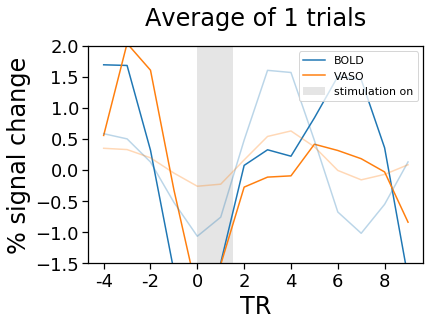

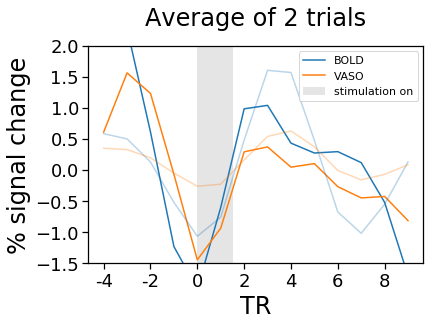

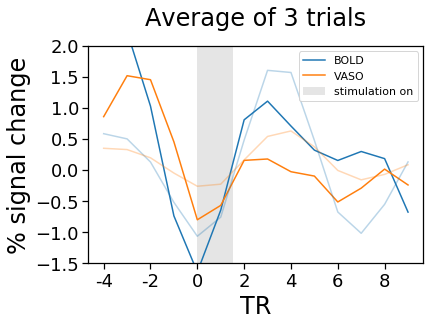

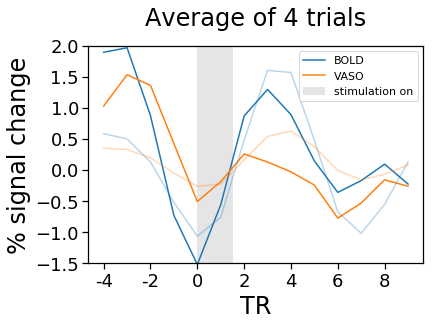

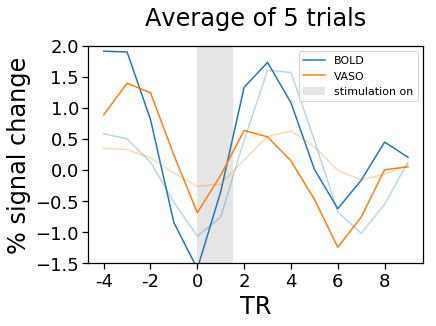

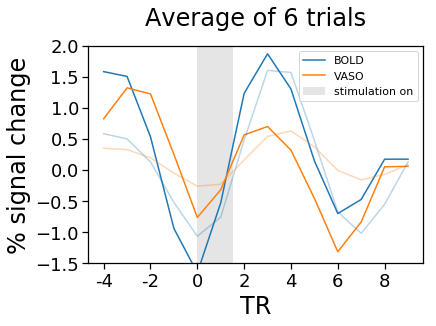

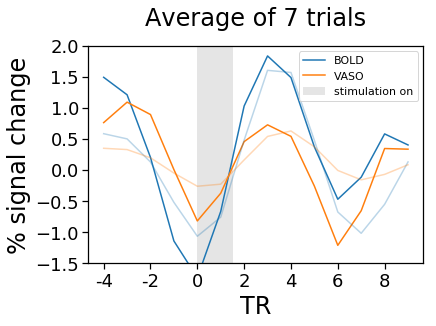

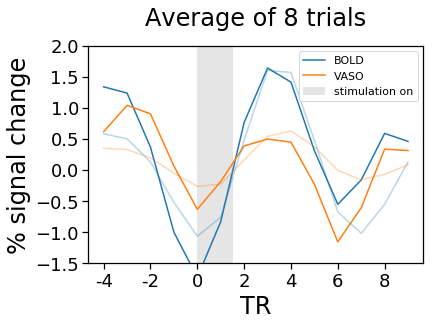

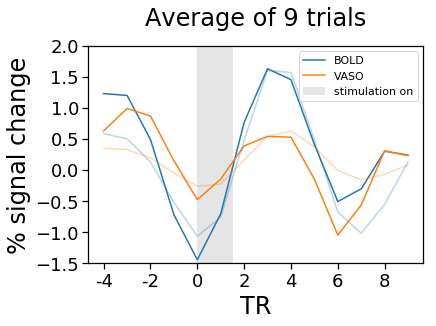

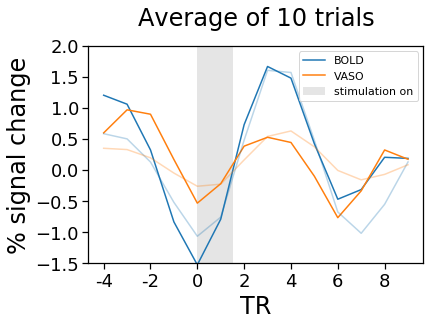

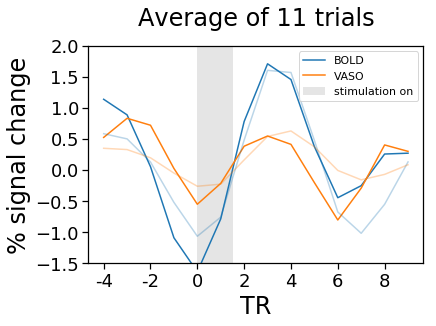

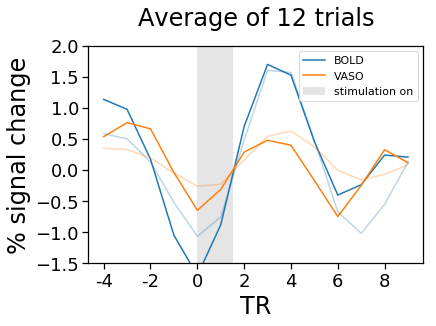

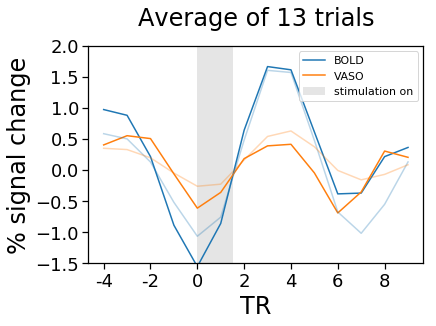

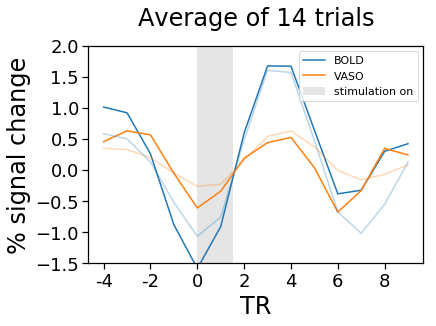

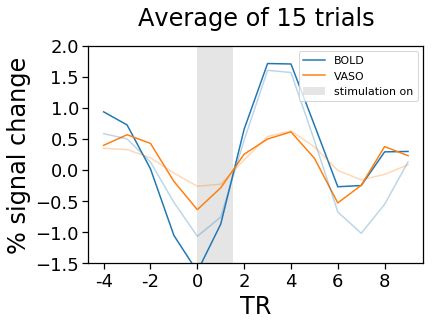

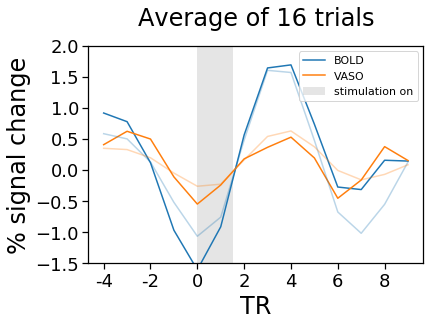

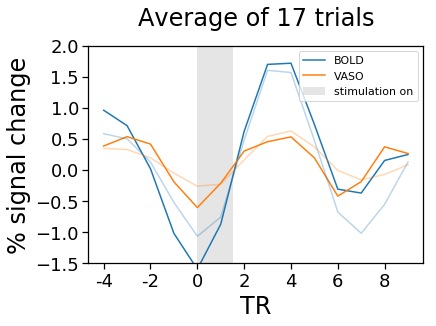

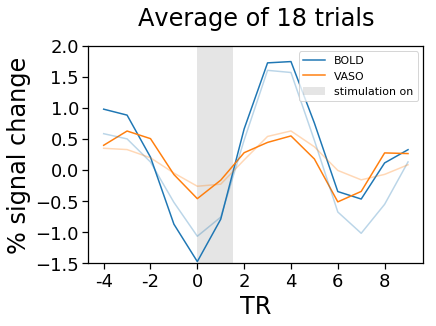

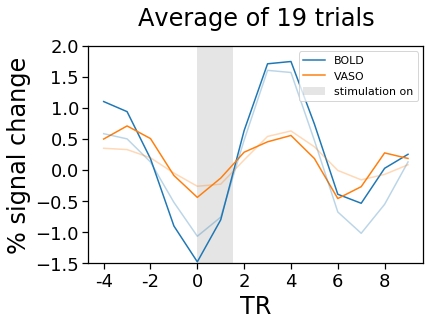

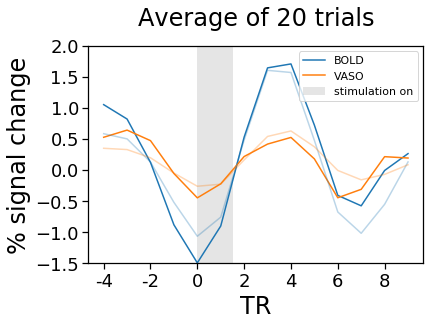

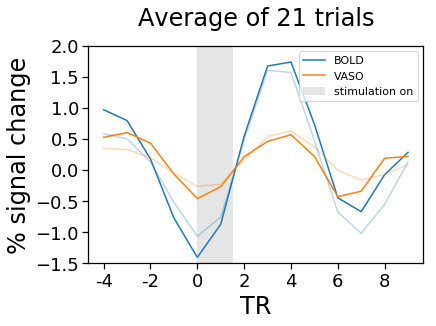

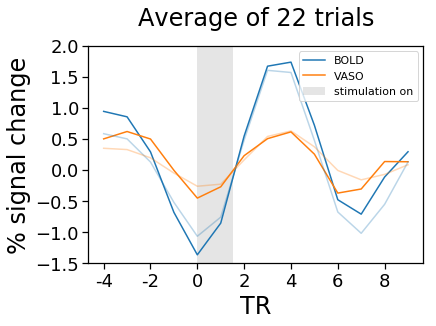

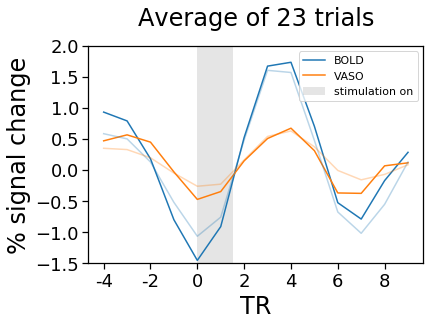

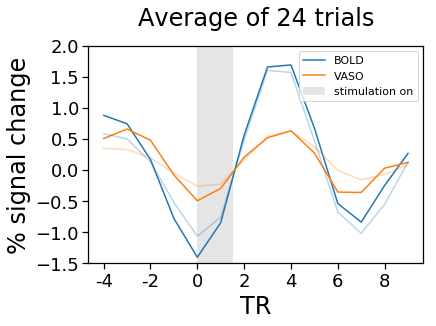

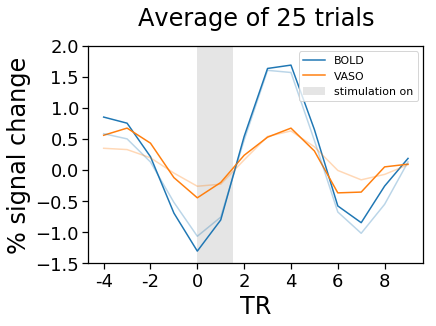

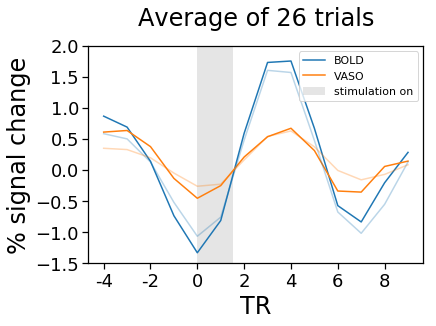

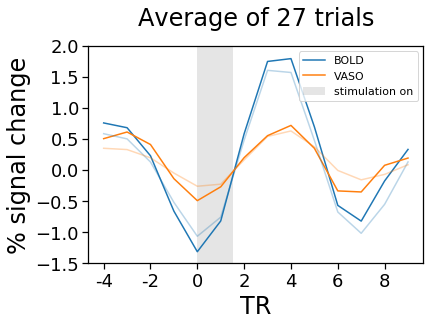

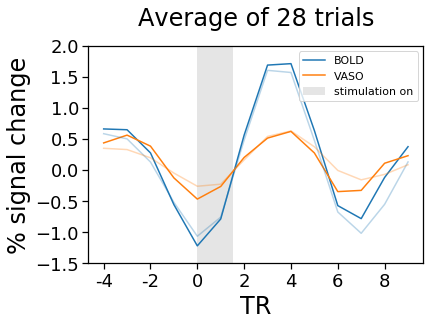

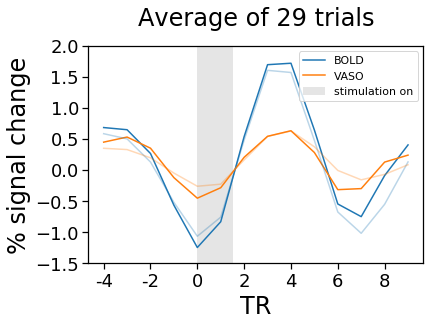

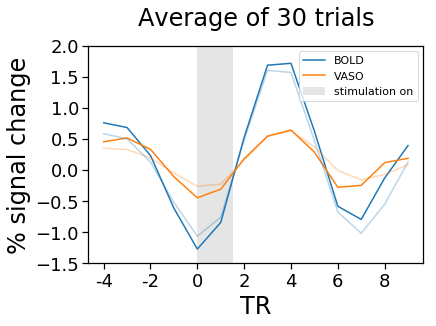

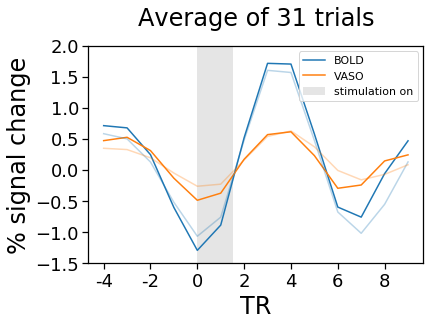

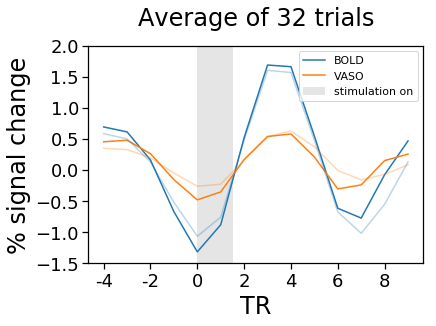

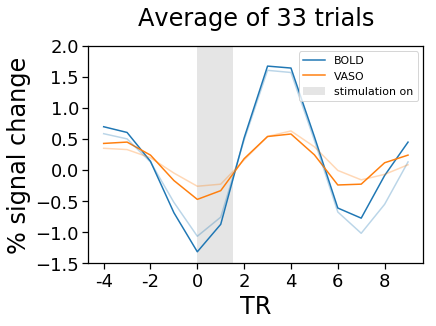

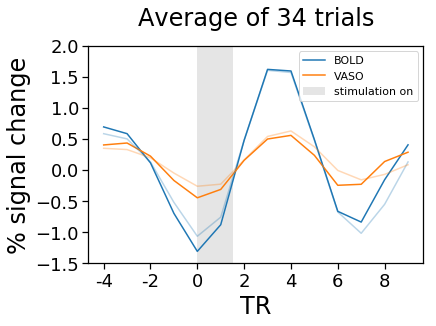

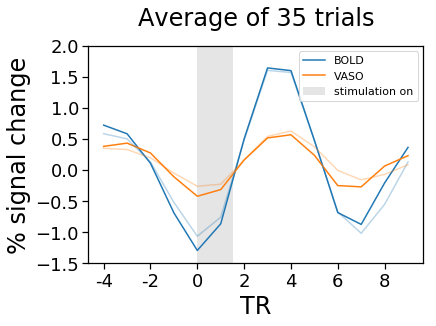

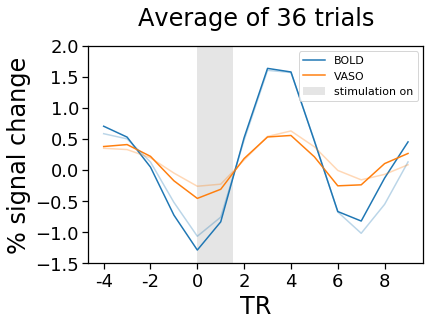

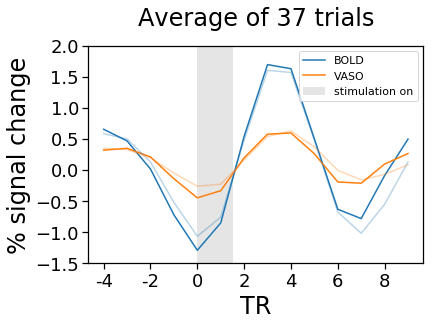

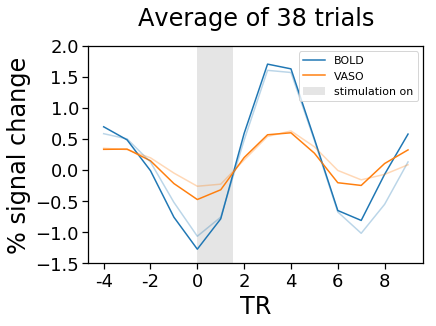

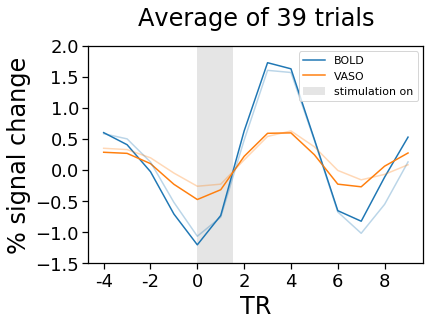

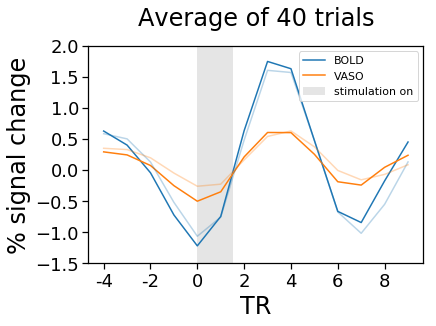

In [773]:
from random import seed
from random import choice


import nibabel as nb
import numpy as np
import imageio
import scipy
from scipy import ndimage
import os


folder = '/home/sebastian/Desktop/test'


seed(5)

for sub in subs[:1]:
    

    subTrials = []
    for key, value in eventResults['v1Focus'][sub][f'{sub}_ses-001_task-eventStim_run-001']['BOLD'].items():
        subTrials.append(key)


    includedTrials = []

    for n in range(40):
        fig = plt.figure()

        # choose a random trial
        selection = choice(subTrials)
        # remove that trial from the list of possible trials
        subTrials.remove(selection)

        includedTrials.append(selection)

        tmpBOLD = eventResults['v1Focus'][sub][f'{sub}_ses-001_task-eventStim_run-001']['BOLD'][includedTrials[0]]
        tmpVASO = eventResults['v1Focus'][sub][f'{sub}_ses-001_task-eventStim_run-001']['VASO'][includedTrials[0]]

        for trial in range(0,len(includedTrials)):
                tmpBOLD = np.vstack((tmpBOLD, eventResults['v1Focus'][sub][f'{sub}_ses-001_task-eventStim_run-001']['BOLD'][includedTrials[trial]]))
                tmpVASO = np.vstack((tmpVASO, eventResults['v1Focus'][sub][f'{sub}_ses-001_task-eventStim_run-001']['VASO'][includedTrials[trial]]))


        tmpVASO = np.mean(tmpVASO, axis=0)
        tmpBOLD = np.mean(tmpBOLD, axis=0)

        plt.plot(tmpBOLD, label='_nolegend_')
        plt.plot(-tmpVASO, label='_nolegend_')
        
        plt.axvspan(4, 4+(2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
        plt.ylabel('% signal change', fontsize=24)
        plt.xlabel('TR', fontsize=24)
#         plt.title(f"{sub}  Event-Related Average", fontsize=20)
#         plt.legend(loc='upper right')

        values = np.arange(-4,len(eventResults['v1Focus']['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD']['trial 1'])-4,2)
        spacing = np.arange(0,len(eventResults['v1Focus']['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD']['trial 1']),2)

        plt.xticks(spacing,values)
        
        
#         sns.lineplot(data=eventData.loc[(eventData['subject']==sub)&('run-001' in str(eventData['run']))], x='x', y='data', hue='modality', alpha=0.3, ci=None)
        sns.lineplot(data=eventData.loc[(eventData['focus']=="v1Focus")&(eventData['subject']=='sub-05')&(eventData['run'].str.contains('run-001'))], x='x', y='data', hue='modality', alpha=0.3, ci=None)
        
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
#         plt.xlabel('TR')
        plt.ylim(-1.5,2) 
        plt.title(f"Average of {n+1} trials", fontsize=24, pad=20)
        plt.legend(loc='upper right')
        
        plt.savefig(f'{folder}/{sub}_eventRelatedAveragesOf{str(n+1).zfill(2)}Trials.png', bbox_inches='tight')
        plt.show()


In [413]:
blockData['trial'].unique()

array(['trial 0', 'trial 1', 'trial 2', 'trial 3', 'trial 4', 'trial 5',
       'trial 6', 'trial 7', 'trial 8', 'trial 9', 'trial 10'],
      dtype=object)

In [418]:
    subTrials = []
    for key, value in blockResults['v1Focus'][sub][f'{sub}_ses-001_task-blockStim_run-002']['BOLD'].items():
        subTrials.append(key)

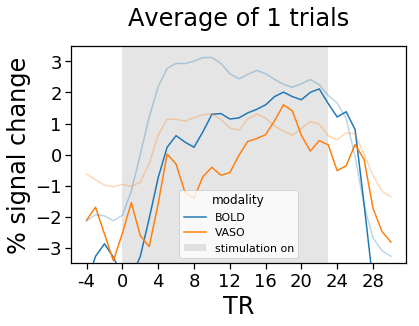

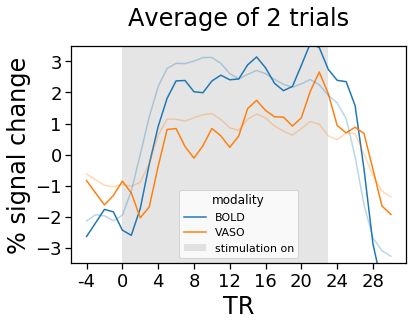

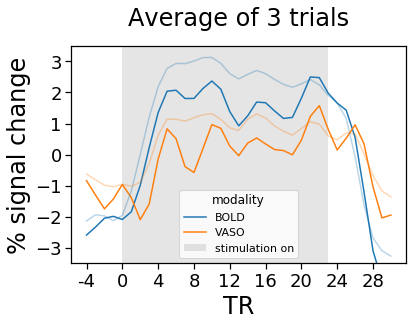

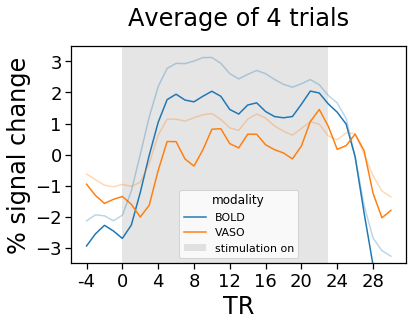

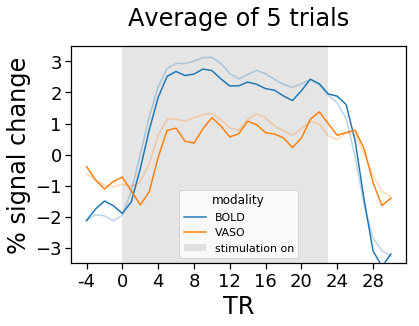

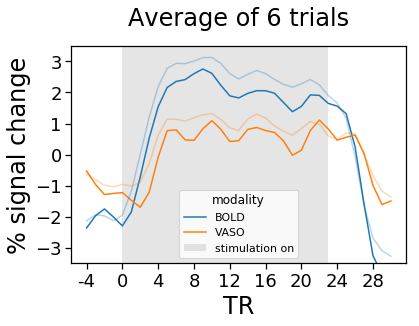

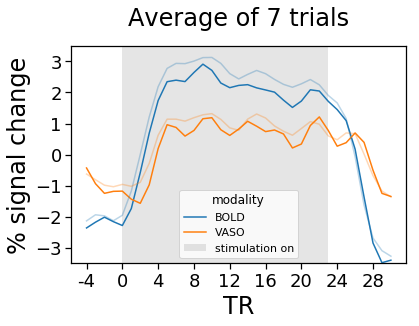

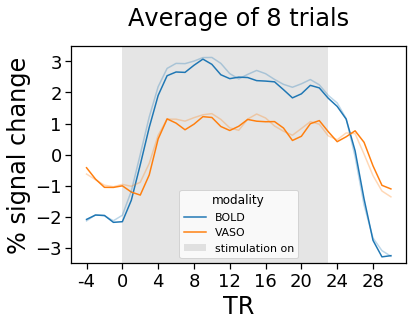

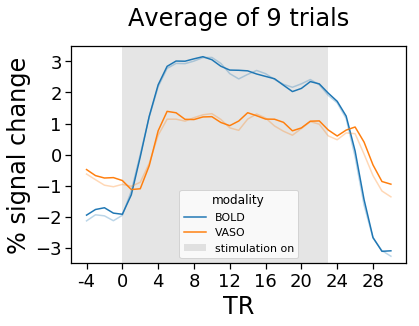

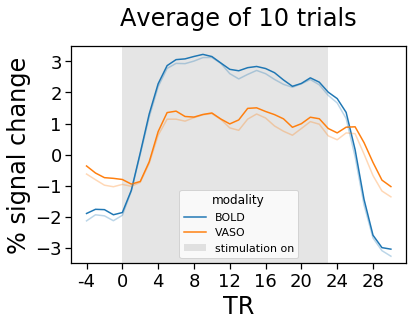

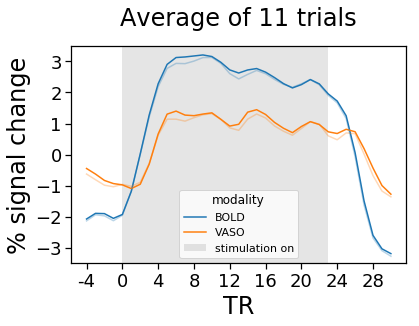

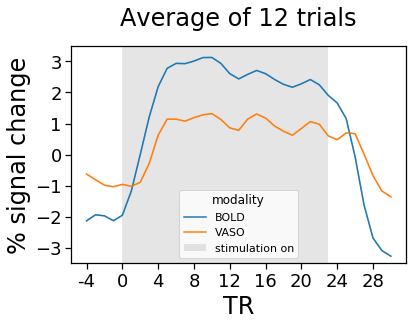

In [770]:
from random import seed
from random import choice


import nibabel as nb
import numpy as np
import imageio
import scipy
from scipy import ndimage
import os


folder = '/home/sebastian/Desktop/test'


seed(5)



for sub in subs[:1]:
    

    subTrials = []
    for key, value in blockResults['v1Focus'][sub][f'{sub}_ses-001_task-blockStim_run-002']['BOLD'].items():
        subTrials.append(key)


    includedTrials = []

    for n in range(len(subTrials)):
        fig = plt.figure()

        # choose a random trial
        selection = choice(subTrials)
        # remove that trial from the list of possible trials
        subTrials.remove(selection)

        includedTrials.append(selection)

        tmpBOLD = blockResults['v1Focus'][sub][f'{sub}_ses-001_task-blockStim_run-002']['BOLD'][includedTrials[0]]
        tmpVASO = blockResults['v1Focus'][sub][f'{sub}_ses-001_task-blockStim_run-002']['VASO'][includedTrials[0]]

        if n != 0:
            for trial in range(1,len(includedTrials)):
                tmpBOLD = np.vstack((tmpBOLD, blockResults['v1Focus'][sub][f'{sub}_ses-001_task-blockStim_run-002']['BOLD'][includedTrials[trial]]))
                tmpVASO = np.vstack((tmpVASO, blockResults['v1Focus'][sub][f'{sub}_ses-001_task-blockStim_run-002']['VASO'][includedTrials[trial]]))


            tmpVASO = np.mean(tmpVASO, axis=0)
            tmpBOLD = np.mean(tmpBOLD, axis=0)

        
        
        
        plt.plot(tmpBOLD, label='_nolegend_')
        plt.plot(-tmpVASO, label='_nolegend_')
        

        
        values = np.arange(-4,len(blockResults['v1Focus']['sub-08']['sub-08_ses-001_task-blockStim_run-002']['BOLD']['trial 1'])-4,4)
        spacing = np.arange(0,len(blockResults['v1Focus']['sub-08']['sub-08_ses-001_task-blockStim_run-002']['BOLD']['trial 1']),4)


        plt.axvspan(4, 4+(30/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
        plt.ylabel('% signal change', fontsize=24)
        plt.xlabel('TR', fontsize=24)


        plt.xticks(spacing,values, fontsize=18)
        plt.yticks(fontsize=18)

        
        plt.ylim(-3.5,3.5) 
        plt.title(f"Average of {n+1} trials", fontsize=24, pad=20)
        
        
        sns.lineplot(data=blockData.loc[(blockData['focus']=="v1Focus")&(blockData['subject']=='sub-05')&(blockData['run'].str.contains('run-002'))], x='x', y='data', hue='modality', alpha=0.3, ci=None)


        plt.savefig(f'{folder}/{sub}_blockEventRelatedAveragesOf{str(n+1).zfill(2)}Trials.png', bbox_inches='tight')
        plt.show()


In [528]:
differenceScoresBOLD[0]

IndexError: list index out of range

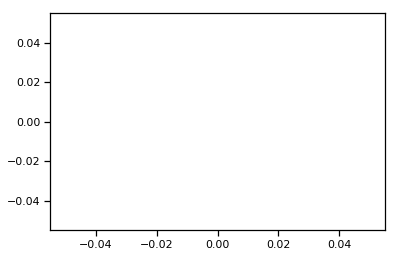

In [616]:
plt.plot(differenceScoresBOLD)
plt.plot(differenceScoresVASO)

In [ ]:
import nibabel as nb
import numpy as np
import imageio
import scipy
from scipy import ndimage
import os


folder = '/home/sebastian/Desktop/test'


for sub in subs:
    

    files = sorted(glob.glob(f'{folder}/{sub}_event*Trials.png'))
    images = []
    for file in files:
        images.append(imageio.imread(file))


    imageio.mimsave(f'{folder}/{sub}_movie.gif', images, duration = 1/0.75)
    
    
import os
[os.remove(f'{folder}/{file}') for file in os.listdir(folder) if file.endswith('.png')]


In [ ]:
os.listdir(folder)

In [ ]:
subTrials = []
for key, value in singleEventResults['sub-05']['BOLD_intemp']['run 1'].items():
    subTrials.append(key)
    
for trial in subTrials:
    plt.plot(singleEventResults['sub-05']['BOLD_intemp']['run 1'][trial], label = 'BOLD')
    plt.plot(-singleEventResults['sub-05']['VASO_LN']['run 1'][trial], label = 'absolute VASO')
    plt.axvspan(4, len(singleEventResults[sub]['BOLD_intemp']['run 1'][f'trial 1'])-8, color='grey', alpha=0.2, lw=0, label = 'stimulation on')
    plt.ylabel('% signal change')
    plt.xlabel('TR')
    plt.ylim(-1,1.5) 
    plt.title(f"{trial}")
#     plt.savefig(f'{folder}/eventRelatedAveragesOf{str(n+1).zfill(2)}Trials.png')
    plt.show()

In [461]:
subRuns = []

for sub in subs[:1]:
    
    for key, value in blockResults['v1Focus'][sub].items():
        subRuns.append(key)

In [489]:
tmpBOLD

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.89318865, -1.57473832, -1.84768083, ..., -4.08967133,
        -2.76430842, -2.74948707],
       [-3.63981197, -4.01232892, -4.15532366, ..., -3.07816621,
        -3.85273844, -3.25998872],
       ...,
       [-2.5818382 , -2.93981569, -3.1557644 , ..., -4.08356618,
        -4.56947214, -4.22217671],
       [-3.07765711, -2.14464248, -0.482598  , ..., -4.75192188,
        -4.89147242, -4.45931864],
       [-3.12500004, -3.28770932, -2.80923808, ..., -6.52531624,
        -6.63461517, -5.43471972]])

### Estimate efficiency

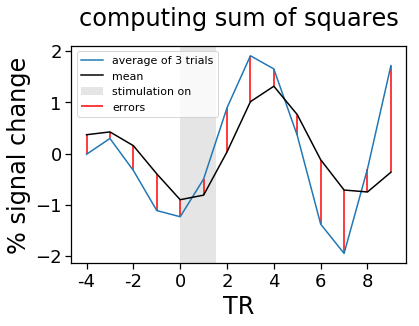

In [848]:
efficiencyData = {}
fig, ax = plt.subplots()

diffScoresBOLD = []
tmpBOLD = np.zeros(len(eventResults['v1Focus']['sub-05']['sub-05_ses-001_task-eventStim_run-002']['BOLD']['trial 1']))
tmpVASO = np.zeros(len(eventResults['v1Focus']['sub-05']['sub-05_ses-001_task-eventStim_run-002']['BOLD']['trial 1']))

for sub in subs:
    tmpBOLD = np.zeros(len(eventResults['v1Focus']['sub-05']['sub-05_ses-001_task-eventStim_run-002']['BOLD']['trial 1']))
    tmpVASO = np.zeros(len(eventResults['v1Focus']['sub-05']['sub-05_ses-001_task-eventStim_run-002']['BOLD']['trial 1']))

    subRuns = []
    for key, value in eventResults['v1Focus'][sub].items():
        subRuns.append(key)
    
    for run in subRuns:
        
        
        subTrials = []
        for key, value in eventResults['v1Focus'][sub][run]['BOLD'].items():
            subTrials.append(key)


        for trial in subTrials[:-1]:    
            tmpBOLD = np.vstack((tmpBOLD, eventResults['v1Focus'][sub][run]['BOLD'][trial]))
            tmpVASO = np.vstack((tmpVASO, eventResults['v1Focus'][sub][run]['VASO'][trial]))


tmpBOLD = np.delete(tmpBOLD, (0), axis=0)
tmpVASO = np.delete(tmpVASO, (0), axis=0)

meanVASO = -np.mean(tmpVASO, axis=0)
meanBOLD = np.mean(tmpBOLD, axis=0)

demeanBOLD = meanBOLD- np.mean(meanBOLD)

    
# efficiencyData[sub][run] = {"VASO": meanVASO, "BOLD": meanBOLD}
# efficiencyData = {}

#         differenceScoresBOLD = []
#         differenceScoresVASO = []


# diffScoresBOLD = []
    
for sub in subs:
    
    tmpBOLD1 = np.zeros(len(eventResults['v1Focus']['sub-05']['sub-05_ses-001_task-eventStim_run-002']['BOLD']['trial 1']))
    tmpVASO1 = np.zeros(len(eventResults['v1Focus']['sub-05']['sub-05_ses-001_task-eventStim_run-002']['BOLD']['trial 1']))

    subRuns = []
    for key, value in eventResults['v1Focus'][sub].items():
        subRuns.append(key)
    
    for run in subRuns:
        
        subTrials = []
        for key, value in eventResults['v1Focus'][sub][run]['BOLD'].items():
            subTrials.append(key)


        for trial in subTrials[:-1]:    
            
            tmpBOLD1 = np.vstack((tmpBOLD1, eventResults['v1Focus'][sub][run]['BOLD'][trial]))
            tmpVASO1 = np.vstack((tmpVASO1, eventResults['v1Focus'][sub][run]['VASO'][trial]))
            
            
            


# print(meanBOLD.shape)

    for n in range(1,tmpBOLD.shape[0]+1):
        avg = np.mean(tmpBOLD1[1:n+1,:], axis=0)-np.mean(tmpBOLD1[1:n+1,:])
        
        if sub=='sub-05' and n == 3:
            plt.plot(avg, label="average of 3 trials")

    #     print(avg.shape)
        diffScoresBOLD.append(abs(np.sum(np.subtract(demeanBOLD[4:-6],avg[4:-6]))))

        if sub=='sub-05' and n == 3:
            plt.plot(demeanBOLD, label="mean", color='black')
            
            for index, value in enumerate(demeanBOLD):
#                 print(x = index, y=[value,avg[index]])
                plt.vlines(index, value, avg[index], color='red', label='errors')
#                 plt.axvline(x = index, value,avg[index])



plt.axvspan(4, 4+(2/tr), color='grey', alpha=0.2, lw=0, label = 'stimulation on')
plt.ylabel('% signal change', fontsize=24)
plt.xlabel('TR', fontsize=24)

values = np.arange(-4,len(eventResults['v1Focus']['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD']['trial 1'])-4,2)
spacing = np.arange(0,len(eventResults['v1Focus']['sub-08']['sub-08_ses-001_task-eventStim_run-002']['BOLD']['trial 1']),2)

plt.xticks(spacing,values)



plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.title(f"Average of {n+1} trials", fontsize=24, pad=20)
# plt.legend(loc='upper right')

ax.yaxis.set_major_locator(MaxNLocator(integer=True))

handles, labels = plt.gca().get_legend_handles_labels()

plt.title('computing sum of squares', pad=20, fontsize=24)
plt.legend(handles[0:4], labels[0:4], loc='upper left')
plt.savefig('test.png',bbox_inches='tight')
plt.show()

In [830]:
handles[0:4]

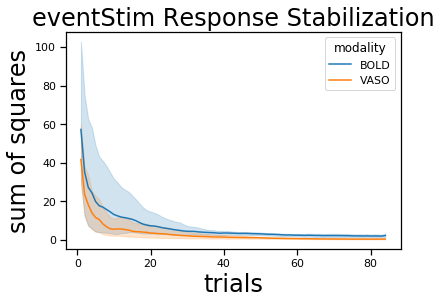

In [787]:

runList = []
nrTrialsList = []
scoresList = []
modalityList = []


for modality in modalities:
    for sub in subs:
        tmpBOLD = np.zeros(len(eventResults['v1Focus']['sub-05']['sub-05_ses-001_task-eventStim_run-002'][modality]['trial 1']))

        subRuns = []
        for key, value in eventResults['v1Focus'][sub].items():
            subRuns.append(key)

        for run in subRuns:

            subTrials = []
            for key, value in eventResults['v1Focus'][sub][run][modality].items():
                subTrials.append(key)

            tmpBOLD = np.zeros(len(eventResults['v1Focus']['sub-05']['sub-05_ses-001_task-eventStim_run-002'][modality]['trial 1']))

            for trial in subTrials[:-1]:
                tmpBOLD = np.vstack((tmpBOLD, eventResults['v1Focus'][sub][run][modality][trial]))


#             tmpBOLD = np.delete(tmpBOLD, (0), axis=0)

#             meanBOLD = np.mean(tmpBOLD, axis=0)

#             # now we have the run-wise mean



#             tmpBOLD1 = np.zeros(len(eventResults['v1Focus']['sub-05']['sub-05_ses-001_task-eventStim_run-002'][modality]['trial 1']))

#             diffScoresBOLD = []

#             subTrials = []
#             for key, value in eventResults['v1Focus'][sub][run][modality].items():
#                 subTrials.append(key)


#             for trial in subTrials[:-1]:    

#                 tmpBOLD1 = np.vstack((tmpBOLD1, eventResults['v1Focus'][sub][run][modality][trial]))



#             for n in range(1,tmpBOLD1.shape[0]+1):
#                 avg = np.mean(tmpBOLD1[1:n+1,:], axis=0)



#                 diffScoresBOLD.append(abs(np.sum(np.subtract(meanBOLD,avg))))

#                 runList.append(run)
#                 nrTrialsList.append(n)
#                 scoresList.append(np.sum(np.subtract(meanBOLD,avg)**2))
#                 modalityList.append(modality)




# efficiencyData = pd.DataFrame({'run':runList, 'nrTrials':nrTrialsList, 'score':scoresList, "modality":modalityList})
# sns.lineplot(data=efficiencyData, x='nrTrials', y='score', hue='modality')

    tmpBOLD = np.delete(tmpBOLD, (0), axis=0)

    meanBOLD = np.mean(tmpBOLD, axis=0)
    

        # now we have the modality specific mean

    for sub in subs:
        subRuns = []
        
        for key, value in eventResults['v1Focus'][sub].items():
            subRuns.append(key)

        for run in subRuns:

            tmpBOLD1 = np.zeros(len(eventResults['v1Focus']['sub-05']['sub-05_ses-001_task-eventStim_run-002'][modality]['trial 1']))

            diffScoresBOLD = []

            subTrials = []
            for key, value in eventResults['v1Focus'][sub][run][modality].items():
                subTrials.append(key)


            for trial in subTrials[:-1]:    

                tmpBOLD1 = np.vstack((tmpBOLD1, eventResults['v1Focus'][sub][run][modality][trial]))



            for n in range(1,tmpBOLD1.shape[0]+1):
                avg = np.mean(tmpBOLD1[1:n+1,:], axis=0)



                diffScoresBOLD.append(abs(np.sum(np.subtract(meanBOLD,avg))))

                runList.append(run)
                nrTrialsList.append(n)
                scoresList.append(np.sum(np.subtract(meanBOLD,avg)**2))
                modalityList.append(modality)




                
                
                
                



efficiencyData = pd.DataFrame({'run':runList, 'nrTrials':nrTrialsList, 'score':scoresList, "modality":modalityList})
sns.lineplot(data=efficiencyData, x='nrTrials', y='score', hue='modality')


                
plt.title('eventStim Response Stabilization', fontsize=24)



plt.ylabel(f"sum of squares", fontsize=24)

plt.xlabel('trials', fontsize=24)




plt.savefig(f'{root}/stabilizingPerEvent.png', bbox_inches = "tight")
plt.show()

In [670]:
ITImin = 3
ITImax = 10
stimDur = 2

ITImean = (ITImax-ITImin)/2
avgTrialDur = stimDur + ITImean

In [735]:
newDataPoints

array([0.])

In [736]:
np.amax(tmp['nrTrials'])

84

In [737]:
np.amax(tmp['nrTrials'])*avgTrialDur

714.0

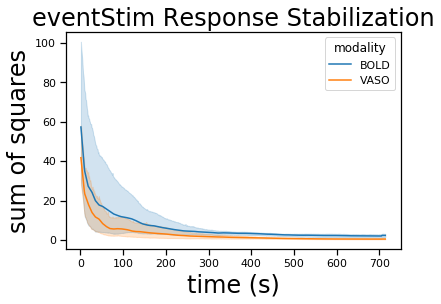

In [788]:
from skimage.transform import resize

ITImin = 3
ITImax = 10
stimDur = 2

ITImean = (ITImax+ITImin)/2
avgTrialDur = stimDur + ITImean

runListInterp = []
secondsList = []
scoresListInterp = []
modalityListInterp = []

for modality in modalities:
    for run in efficiencyData['run'].unique():

        tmp = efficiencyData.loc[(efficiencyData['run']==run)&(efficiencyData['modality']==modality)]

        x = np.arange(0, np.amax(tmp['nrTrials']))

        interpolator = interp1d(x,tmp['score'], kind='linear', bounds_error=False, fill_value= 'extrapolate')

        newDataPoints = np.linspace(0, np.amax(tmp['nrTrials']), int(np.amax(tmp['nrTrials'])*avgTrialDur))

        scoresPerUnitTimeList = interpolator(newDataPoints)
        
        scoresListInterp.append(scoresPerUnitTimeList.copy())

        for n in range(len(scoresPerUnitTimeList)):
            runListInterp.append(run)
            secondsList.append(n+1)
            modalityListInterp.append(modality)
            
scoresListInterp = [item for sublist in scoresListInterp for item in sublist]

efficiencyDataEvents = pd.DataFrame({'run':runListInterp, 'time':secondsList, 'score':scoresListInterp, "modality":modalityListInterp})
sns.lineplot(data=efficiencyDataEvents, x='time', y='score', hue='modality')


plt.title('eventStim Response Stabilization', fontsize=24)



plt.ylabel(f"sum of squares", fontsize=24)

plt.xlabel('time (s)', fontsize=24)




plt.savefig(f'{root}/stabilizingPerTime.png', bbox_inches = "tight")
plt.show()

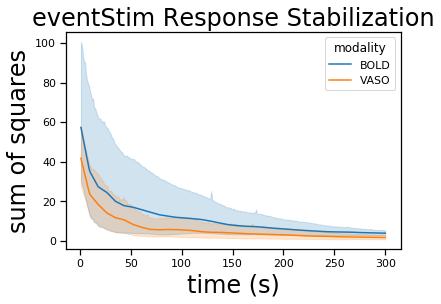

In [789]:
from skimage.transform import resize

ITImin = 3
ITImax = 10
stimDur = 2

ITImean = (ITImax+ITImin)/2
avgTrialDur = stimDur + ITImean

runListInterp = []
secondsList = []
scoresListInterp = []
modalityListInterp = []

for modality in modalities:
    for run in efficiencyData['run'].unique():

        tmp = efficiencyData.loc[(efficiencyData['run']==run)&(efficiencyData['modality']==modality)]

        x = np.arange(0, np.amax(tmp['nrTrials']))

        interpolator = interp1d(x,tmp['score'], kind='linear', bounds_error=False, fill_value= 'extrapolate')

        newDataPoints = np.linspace(0, np.amax(tmp['nrTrials']), int(np.amax(tmp['nrTrials'])*avgTrialDur))

        scoresPerUnitTimeList = interpolator(newDataPoints)
        
        scoresListInterp.append(scoresPerUnitTimeList[:300].copy())

        for n in range(len(scoresPerUnitTimeList[:300])):
            runListInterp.append(run)
            secondsList.append(n+1)
            modalityListInterp.append(modality)
            
scoresListInterp = [item for sublist in scoresListInterp for item in sublist]

efficiencyDataEvents = pd.DataFrame({'run':runListInterp, 'time':secondsList, 'score':scoresListInterp, "modality":modalityListInterp})
sns.lineplot(data=efficiencyDataEvents, x='time', y='score', hue='modality')

plt.title('eventStim Response Stabilization', fontsize=24)



plt.ylabel(f"sum of squares", fontsize=24)

plt.xlabel('time (s)', fontsize=24)




plt.savefig(f'{root}/stabilizingPerTimeTrunc.png', bbox_inches = "tight")
plt.show()

In [694]:
np.amax(secondsList)

714

In [676]:
scoresPerUnitTimeList.shape[0]==np.amax(nrTrialsList) * avgTrialDur

True

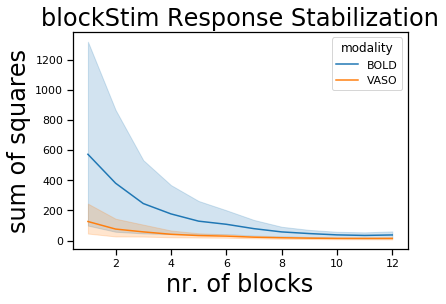

In [794]:

runList = []
nrTrialsList = []
scoresList = []
modalityList = []


for modality in modalities:
    tmpBOLD = np.zeros(len(blockResults['v1Focus']['sub-05']['sub-05_ses-001_task-blockStim_run-002'][modality]['trial 1']))
    for sub in subs:

        subRuns = []
        for key, value in blockResults['v1Focus'][sub].items():
            subRuns.append(key)

        for run in subRuns:

            subTrials = []
            for key, value in blockResults['v1Focus'][sub][run][modality].items():
                subTrials.append(key)

            tmpBOLD = np.zeros(len(blockResults['v1Focus']['sub-05']['sub-05_ses-001_task-blockStim_run-002'][modality]['trial 1']))

            for trial in subTrials[:-1]:
                tmpBOLD = np.vstack((tmpBOLD, blockResults['v1Focus'][sub][run][modality][trial]))


    tmpBOLD = np.delete(tmpBOLD, (0), axis=0)

    meanBOLD = np.mean(tmpBOLD, axis=0)
    

        # now we have the modality specific mean

    for sub in subs:
        subRuns = []
        
        for key, value in blockResults['v1Focus'][sub].items():
            subRuns.append(key)

        for run in subRuns:

            tmpBOLD1 = np.zeros(len(blockResults['v1Focus']['sub-05']['sub-05_ses-001_task-blockStim_run-002'][modality]['trial 1']))

            diffScoresBOLD = []

            subTrials = []
            for key, value in blockResults['v1Focus'][sub][run][modality].items():
                subTrials.append(key)


            for trial in subTrials[:-1]:    

                tmpBOLD1 = np.vstack((tmpBOLD1, blockResults['v1Focus'][sub][run][modality][trial]))



            for n in range(1,tmpBOLD1.shape[0]+1):
                avg = np.mean(tmpBOLD1[1:n+1,:], axis=0)



                diffScoresBOLD.append(abs(np.sum(np.subtract(meanBOLD,avg))))

                runList.append(run)
                nrTrialsList.append(n)
                scoresList.append(np.sum(np.subtract(meanBOLD,avg)**2))
                modalityList.append(modality)




efficiencyData = pd.DataFrame({'run':runList, 'nrTrials':nrTrialsList, 'score':scoresList, "modality":modalityList})
sns.lineplot(data=efficiencyData, x='nrTrials', y='score', hue='modality')

plt.title('blockStim Response Stabilization', fontsize=24)



plt.ylabel(f"sum of squares", fontsize=24)

plt.xlabel('nr. of blocks', fontsize=24)




plt.savefig(f'{root}/stabilizingPerBlock.png', bbox_inches = "tight")
plt.show()

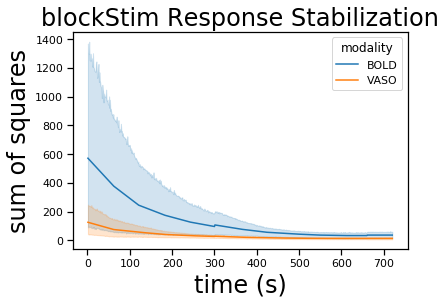

In [796]:
from skimage.transform import resize

ITImin = 30
ITImax = 30
stimDur = 30

ITImean = (ITImax+ITImin)/2
avgTrialDur = stimDur + ITImean

runListInterp = []
secondsList = []
scoresListInterp = []
modalityListInterp = []

for modality in modalities:
    for run in efficiencyData['run'].unique():

        tmp = efficiencyData.loc[(efficiencyData['run']==run)&(efficiencyData['modality']==modality)]

        x = np.arange(0, np.amax(tmp['nrTrials']))

        interpolator = interp1d(x,tmp['score'], kind='linear', bounds_error=False, fill_value= 'extrapolate')

        newDataPoints = np.linspace(0, np.amax(tmp['nrTrials']), int(np.amax(tmp['nrTrials'])*avgTrialDur))

        scoresPerUnitTimeList = interpolator(newDataPoints)
        
        scoresListInterp.append(scoresPerUnitTimeList.copy())

        for n in range(len(scoresPerUnitTimeList)):
            runListInterp.append(run)
            secondsList.append(n+1)
            modalityListInterp.append(modality)
            
scoresListInterp = [item for sublist in scoresListInterp for item in sublist]

efficiencyDataBlocks = pd.DataFrame({'run':runListInterp, 'time':secondsList, 'score':scoresListInterp, "modality":modalityListInterp})
sns.lineplot(data=efficiencyDataBlocks, x='time', y='score', hue='modality')

plt.title('blockStim Response Stabilization', fontsize=24)



plt.ylabel(f"sum of squares", fontsize=24)

plt.xlabel('time (s)', fontsize=24)




plt.savefig(f'{root}/stabilizingPerTimeBlocks.png', bbox_inches = "tight")
plt.show()

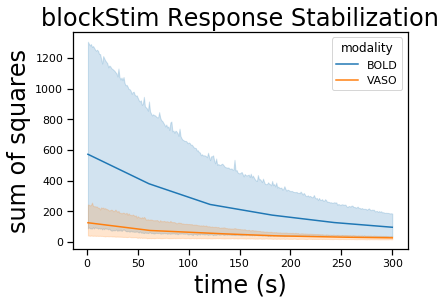

In [797]:
from skimage.transform import resize

ITImin = 30
ITImax = 30
stimDur = 30

ITImean = (ITImax+ITImin)/2
avgTrialDur = stimDur + ITImean

runListInterp = []
secondsList = []
scoresListInterp = []
modalityListInterp = []

for modality in modalities:
    for run in efficiencyData['run'].unique():

        tmp = efficiencyData.loc[(efficiencyData['run']==run)&(efficiencyData['modality']==modality)]

        x = np.arange(0, np.amax(tmp['nrTrials']))

        interpolator = interp1d(x,tmp['score'], kind='linear', bounds_error=False, fill_value= 'extrapolate')

        newDataPoints = np.linspace(0, np.amax(tmp['nrTrials']), int(np.amax(tmp['nrTrials'])*avgTrialDur))

        scoresPerUnitTimeList = interpolator(newDataPoints)
        
        scoresListInterp.append(scoresPerUnitTimeList[:300].copy())

        for n in range(len(scoresPerUnitTimeList[:300])):
            runListInterp.append(run)
            secondsList.append(n+1)
            modalityListInterp.append(modality)
            
scoresListInterp = [item for sublist in scoresListInterp for item in sublist]

efficiencyDataBlocks = pd.DataFrame({'run':runListInterp, 'time':secondsList, 'score':scoresListInterp, "modality":modalityListInterp})

sns.lineplot(data=efficiencyDataBlocks, x='time', y='score', hue='modality')

plt.title('blockStim Response Stabilization', fontsize=24)



plt.ylabel(f"sum of squares", fontsize=24)

plt.xlabel('time (s)', fontsize=24)




plt.savefig(f'{root}/stabilizingPerTimeBlocksTrunc.png', bbox_inches = "tight")
plt.show()

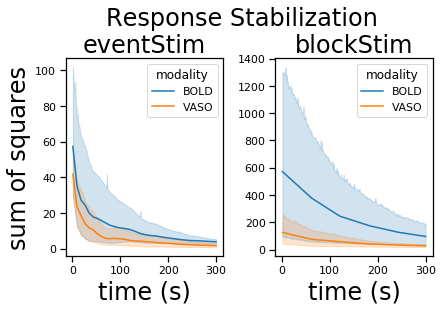

In [798]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.tight_layout()
fig.subplots_adjust(top=0.80)

sns.lineplot(data=efficiencyDataEvents, x='time', y='score', hue='modality', ax = ax1)
sns.lineplot(data=efficiencyDataBlocks, x='time', y='score', hue='modality', ax = ax2)

plt.suptitle('Response Stabilization', fontsize=24)

ax1.set_title('eventStim', fontsize=24)
ax2.set_title('blockStim', fontsize=24)

ax1.set_ylabel(f"sum of squares", fontsize=24)
ax2.set_ylabel('', fontsize=24)

ax1.set_xlabel('time (s)', fontsize=24)
ax2.set_xlabel('time (s)', fontsize=24)



# plt.yticks(fontsize=18)
# plt.xticks(fontsize=18)



plt.savefig(f'{root}/stabilizingPerTime2.png', bbox_inches = "tight")
plt.show()

### Find scaling factor Even related design

In [230]:
mat = np.loadtxt(f'{root}/sub-08/ses-001/s1Focus/sub-08_ses-001_task-eventStim_run-001_VASO.feat/design.mat', skiprows=5)

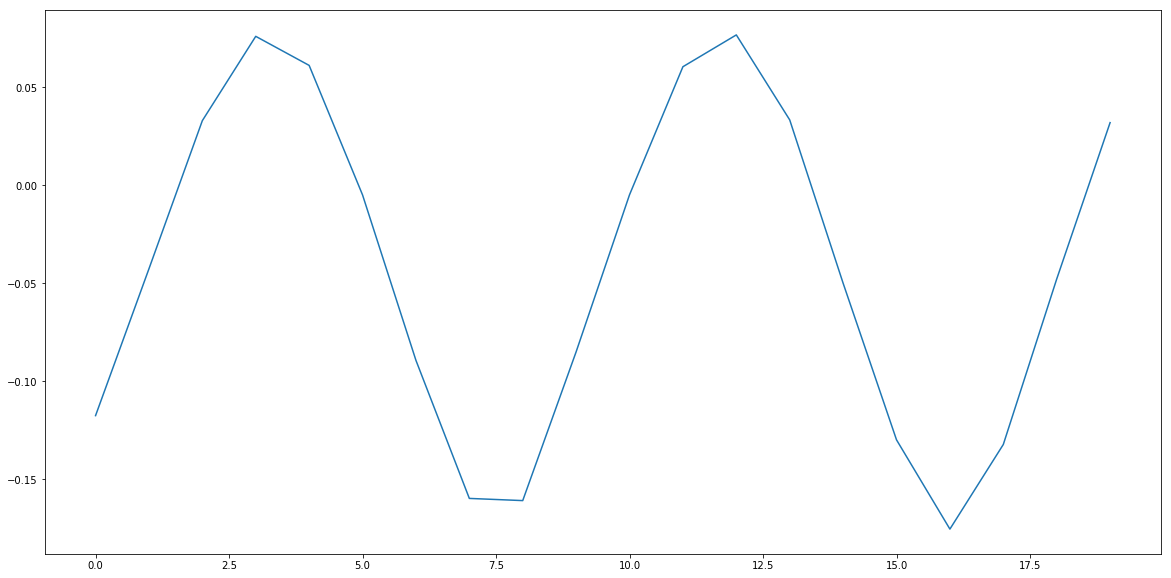

In [235]:
plt.subplots(figsize=(20,10))

plt.plot(mat[200:220])

In [238]:
matBlock = np.loadtxt(f'{root}/sub-08/ses-001/s1Focus/sub-08_ses-001_task-blockStim_run-001_VASO.feat/design.mat', skiprows=5)

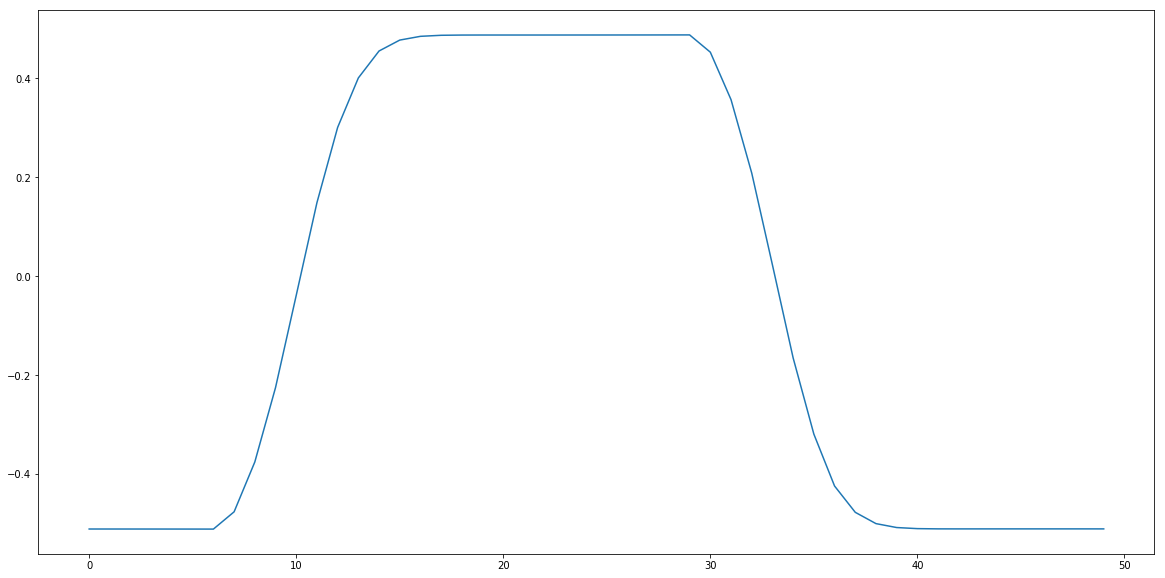

In [240]:
plt.subplots(figsize=(20,10))

plt.plot(matBlock[200:250])